#Import

In [ ]:
!pip install torchmetrics

     |████████████████████████████████| 409 kB 4.9 MB/s 


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn, optim
from torchmetrics import F1Score, Recall, Accuracy
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from tqdm import tqdm
import re
from collections import Counter
from copy import deepcopy
import json
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Prepearing text

In [ ]:
with open('/content/drive/MyDrive/Диплом/Code/data/data_5_tokens_1_sentences.json', 'r', encoding='utf-8') as f:
  data = f.read()
  data = json.loads(data)

In [ ]:
data_tokenized = []
targets = []
for prev, sent in data:
  prev_tokenized = []
  for s in prev:
    s = re.sub('-B|-I', '', s)
    s = s.lower()
    prev_tokenized.extend(word_tokenize(s))
  sent_tokenized = word_tokenize(sent)
  sent_targets = []
  for word in sent_tokenized:
    if word.endswith('-B'):
      sent_targets.append('B')
    elif word.endswith('-I'):
      sent_targets.append('I')
    else:
      sent_targets.append('O')
  sent_tokenized = re.sub('-B|-I', '', sent)
  sent_tokenized = sent_tokenized.lower()
  sent_tokenized = word_tokenize(sent_tokenized)
  data_tokenized.append((prev_tokenized, sent_tokenized))
  targets.append(sent_targets)

In [ ]:
vocab = []
[vocab.extend(text[0]) for text in data_tokenized]
vocab = Counter(vocab)
word2id = {'PAD': 0}
for word in vocab:
    word2id[word] = len(word2id)
word2id['UNK'] = len(word2id)
id2word = {i: word for word, i in word2id.items()}

subject2id = {'O': 0, 'B': 1, 'I': 2}
id2subject = {0: 'O', 1: 'B', 2: 'I'}

#Data

In [ ]:
class SubDataset(Dataset):
    def __init__(self, word2id, subject2id, data, targets, DEVICE):
        super().__init__()
        self.y = deepcopy(targets)
        self.device = DEVICE
        self.X = deepcopy(data)
        self.word2id = word2id
        self.vocab_size = len(word2id)
        self.subject2id = subject2id
    
    def __getitem__(self, index):
        x_prev = deepcopy((self.X[index][0]))
        x = deepcopy(self.X[index][1])
        y = deepcopy(self.y[index])
        for num, word in enumerate(x_prev):
            if word in self.word2id.keys():
                word = self.word2id[word]
            else:
                word = self.word2id['UNK']
            x_prev[num] = word
        for num, word in enumerate(x):
            if word in self.word2id.keys():
                word = self.word2id[word]
            else:
                word = self.word2id['UNK']
            x[num] = word
        y = [self.subject2id[tag] for tag in y]
        x_prev = torch.LongTensor(x_prev)
        x = torch.LongTensor(x)
        y = torch.LongTensor(y)
        return x_prev, x, y
    
    def __len__(self):
        return len(self.X)
    
    def collate_fn(self, batch):
        x_prevs = []
        xs = []
        ys = []
        for x_prev, x, y in batch:
          x_prevs.append(x_prev)
          xs.append(x)
          ys.append(y)
        # batch_size x longest_sequence
        x_prevs = pad_sequence(x_prevs, batch_first=True).to(self.device)
        xs = pad_sequence(xs, batch_first=True).to(self.device)
        ys = pad_sequence(ys, batch_first=True).to(self.device)
        return x_prevs, xs, ys

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

# Model

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.lstm = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, (h_n, c_n) = self.lstm(embedded_prev)
        output, _ = self.lstm(embedded_text, (h_n, c_n))
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Model 2 Cells

In [ ]:
class LSTM_2Cells(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.lstm_prev = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.lstm = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, (h_n, c_n) = self.lstm_prev(embedded_prev)
        output, _ = self.lstm(embedded_text, (h_n, c_n))
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Model Bi-directional

In [ ]:
class BiLSTM(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.lstm_bi = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 2 ∗ hidden_size -> output, 2 ∗ num_layers x hidden_size -> h_n
        _, (h_n, c_n) = self.lstm_bi(embedded_prev)
        shape_h_n = int(h_n.shape[0] / 2)
        h_n = h_n[:shape_h_n, :]
        c_n = c_n[:shape_h_n, :]
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 2 ∗ hidden_size -> output, 2 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        c_n = torch.cat([c_n, new_dir], dim=0)
        output, _ = self.lstm_bi(embedded_text, (h_n, c_n))
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Model Bi-directional 2 cells

In [ ]:
class BiLSTM_2Cells(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.lstm= nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.lstm_bi = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, (h_n, c_n) = self.lstm(embedded_prev)
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        c_n = torch.cat([c_n, new_dir], dim=0)
        output, _ = self.lstm_bi(embedded_text, (h_n, c_n))
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Prepearing embeddings

In [ ]:
vec_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Диплом/Code/vectors/numberbatch_ger.txt.gz', binary=False)

In [ ]:
weights = np.zeros((len(word2id), 300))
count = []
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = vec_model[word]    
    except KeyError:
        count.append(word)
        # oov словам сопоставляем случайный вектор
        weights[i] = np.random.normal(0,0.1,300)
print(f'Доля слов, отсутствующих в вокабуляре {len(count) / len(word2id)}')

Доля слов, отсутствующих в вокабуляре 0.2729710902124695


# Model Bi-directional 2 cells + embeddings

In [ ]:
class BiLSTM_2Cells_Embs(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, weights, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.lstm= nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.lstm_bi = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, (h_n, c_n) = self.lstm(embedded_prev)
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        c_n = torch.cat([c_n, new_dir], dim=0)
        output, _ = self.lstm_bi(embedded_text, (h_n, c_n))
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Training and evaluating functions

In [ ]:
def train(model, iterator, optimizer, criterion, device=DEVICE):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (prev, text, y) in tqdm(enumerate(iterator)): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        pred = model(prev, text)  #прогоняем данные через модель
        shape = pred.shape
        loss = criterion(pred.reshape(shape[0] * shape[1], 3), y.reshape(-1).long()) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/(i + 1)}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке


def evaluate(model, iterator, criterion, f1, accuracy):
    epoch_loss = 0
    epoch_f1 = 0
    epoch_accuracy = 0
    model.eval() 
    with torch.no_grad():
        for i, (prev, text, y) in tqdm(enumerate(iterator)):   
            pred = model(prev, text)  # делаем предсказания на тесте
            shape = pred.shape
            loss = criterion(pred.reshape(shape[0] * shape[1], 3), y.reshape(-1).long())   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            pred_tag = torch.argmax(pred.reshape(shape[0] * shape[1], 3), dim=1)
            epoch_f1 += f1(preds=pred_tag, target=y.reshape(-1).long()).item()
            epoch_accuracy += accuracy(preds=pred_tag, target=y.reshape(-1).long()).item()

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/(i + 1)}, Val f1: {epoch_f1/(i + 1)}, Val accuracy: {epoch_accuracy/(i + 1)}')
        
    return epoch_accuracy / len(iterator), epoch_f1 / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

# Experiment 1, testing testing weights (0.005, 1, 1)
* LSTM
* uni
* 1 cell
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = LSTM(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


51it [00:02, 30.41it/s]

Train loss: 0.7220887925889757


96it [00:03, 29.40it/s]

Train loss: 0.7055780351161957


138it [00:05, 27.54it/s]

Train loss: 0.701686931097949


184it [00:06, 30.06it/s]

Train loss: 0.706600296497345


226it [00:08, 26.46it/s]


Train loss: 0.7073844732178582

Evaluating on train...


47it [00:01, 24.04it/s]

Val loss: 0.7133775300449795, Val f1: 0.3627885222434998, Val accuracy: 0.36296297245555453


95it [00:03, 36.89it/s]

Val loss: 0.7129293031162686, Val f1: 0.37019771569304993, Val accuracy: 0.37037037975258297


142it [00:04, 38.10it/s]

Val loss: 0.7068392788922345, Val f1: 0.37390955730720804, Val accuracy: 0.3740740833459077


187it [00:05, 41.35it/s]

Val loss: 0.7056567665603426, Val f1: 0.36743014686637454, Val accuracy: 0.3675926019748052


226it [00:06, 33.78it/s]


Val loss: 0.7064537914594015, Val f1: 0.3665040602948931, Val accuracy: 0.36666667607095504

Evaluating on test...


21it [00:00, 38.96it/s]

Val loss: 0.758481486638387, Val f1: 0.33310478130976356, Val accuracy: 0.3333333432674408


37it [00:00, 38.33it/s]

Val loss: 0.7362935721874238, Val f1: 0.33313469688097636, Val accuracy: 0.3333333432674408


51it [00:01, 39.99it/s]

Val loss: 0.7245719565285577, Val f1: 0.34796397884686786, Val accuracy: 0.34814815786149766


66it [00:01, 40.23it/s]

Val loss: 0.7199039389689763, Val f1: 0.3442663525541623, Val accuracy: 0.3444444542129835


76it [00:01, 39.42it/s]


Val loss: 0.717389608224233, Val f1: 0.35093584219614665, Val accuracy: 0.35111112078030904

starting Epoch 1
Training...


49it [00:02, 19.98it/s]

Train loss: 0.7004666540357801


93it [00:03, 24.77it/s]

Train loss: 0.703282050953971


139it [00:05, 28.86it/s]

Train loss: 0.6999664147694905


185it [00:07, 27.17it/s]

Train loss: 0.7004814340008629


226it [00:09, 24.57it/s]


Train loss: 0.7050993609428405

Evaluating on train...


53it [00:01, 45.76it/s]

Val loss: 0.6973759531974792, Val f1: 0.36280984613630507, Val accuracy: 0.36296297245555453


93it [00:02, 24.29it/s]

Val loss: 0.6981426278750101, Val f1: 0.3628098491165373, Val accuracy: 0.36296297245555453


139it [00:04, 40.49it/s]

Val loss: 0.696773495497527, Val f1: 0.3677498292039942, Val accuracy: 0.3679012439869068


184it [00:05, 40.72it/s]

Val loss: 0.6999819907877181, Val f1: 0.3702147826552391, Val accuracy: 0.37037037975258297


226it [00:06, 34.55it/s]


Val loss: 0.7044996158281962, Val f1: 0.36576464109950596, Val accuracy: 0.3659259353743659

Evaluating on test...


18it [00:00, 24.19it/s]

Val loss: 0.7095757126808167, Val f1: 0.37760783235232037, Val accuracy: 0.3777777870496114


33it [00:01, 30.33it/s]

Val loss: 0.7060651461283366, Val f1: 0.3553919514020284, Val accuracy: 0.3555555651585261


49it [00:01, 32.09it/s]

Val loss: 0.7013121061854892, Val f1: 0.3479927261670431, Val accuracy: 0.34814815786149766


65it [00:02, 35.20it/s]

Val loss: 0.7092241366704305, Val f1: 0.34427883128325143, Val accuracy: 0.3444444542129835


76it [00:02, 29.95it/s]


Val loss: 0.7114205312728882, Val f1: 0.3420547413825989, Val accuracy: 0.3422222320238749

starting Epoch 2
Training...


47it [00:01, 27.18it/s]

Train loss: 0.7133282780647278


92it [00:03, 25.96it/s]

Train loss: 0.713931989007526


141it [00:05, 30.91it/s]

Train loss: 0.7074486701576798


185it [00:06, 29.22it/s]

Train loss: 0.7029858079221514


226it [00:08, 27.02it/s]


Train loss: 0.7045138544506497

Evaluating on train...


50it [00:01, 46.70it/s]

Val loss: 0.6974248290061951, Val f1: 0.36281159652603995, Val accuracy: 0.36296297245555453


95it [00:02, 45.14it/s]

Val loss: 0.700793895456526, Val f1: 0.35540081759293873, Val accuracy: 0.3555555651585261


140it [00:03, 42.75it/s]

Val loss: 0.7041346783991214, Val f1: 0.362804044396789, Val accuracy: 0.36296297245555453


185it [00:04, 40.54it/s]

Val loss: 0.7096454421679179, Val f1: 0.36649980892737705, Val accuracy: 0.3666666761040688


226it [00:05, 43.20it/s]


Val loss: 0.7048807220988803, Val f1: 0.3628021938270993, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 40.03it/s]

Val loss: 0.711018443107605, Val f1: 0.333164115746816, Val accuracy: 0.3333333432674408


35it [00:00, 41.37it/s]

Val loss: 0.7045840144157409, Val f1: 0.3331750512123108, Val accuracy: 0.3333333432674408


50it [00:01, 41.69it/s]

Val loss: 0.7101044456164042, Val f1: 0.3479802462789747, Val accuracy: 0.34814815786149766


65it [00:01, 40.84it/s]

Val loss: 0.710326024889946, Val f1: 0.355388184885184, Val accuracy: 0.3555555651585261


76it [00:01, 41.18it/s]


Val loss: 0.7157163627942403, Val f1: 0.35982542276382445, Val accuracy: 0.36000000953674316

starting Epoch 3
Training...


51it [00:01, 29.71it/s]

Train loss: 0.7061309509807163


93it [00:03, 28.22it/s]

Train loss: 0.6998896744516161


140it [00:05, 28.17it/s]

Train loss: 0.7092610902256435


184it [00:06, 28.17it/s]

Train loss: 0.7068298998806212


226it [00:08, 27.72it/s]


Train loss: 0.7056423399183486

Evaluating on train...


50it [00:01, 47.03it/s]

Val loss: 0.700675884882609, Val f1: 0.33318079710006715, Val accuracy: 0.3333333432674408


95it [00:02, 44.21it/s]

Val loss: 0.7122656173176236, Val f1: 0.3479769888851378, Val accuracy: 0.34814815786149766


140it [00:03, 42.95it/s]

Val loss: 0.7092209970509564, Val f1: 0.3430435244683866, Val accuracy: 0.3432098863301454


185it [00:04, 40.42it/s]

Val loss: 0.7060439209143321, Val f1: 0.35909694416655435, Val accuracy: 0.35925926880704034


226it [00:05, 42.49it/s]


Val loss: 0.706122190952301, Val f1: 0.3539117072688209, Val accuracy: 0.3540740836991204

Evaluating on test...


22it [00:00, 39.64it/s]

Val loss: 0.7487470388412476, Val f1: 0.3331182618935903, Val accuracy: 0.3333333432674408


34it [00:00, 36.91it/s]

Val loss: 0.7219407558441162, Val f1: 0.3331536481777827, Val accuracy: 0.3333333432674408


52it [00:01, 39.06it/s]

Val loss: 0.7208006673389011, Val f1: 0.33315499822298683, Val accuracy: 0.3333333432674408


65it [00:01, 38.39it/s]

Val loss: 0.7181774467229843, Val f1: 0.33315901160240174, Val accuracy: 0.3333333432674408


76it [00:01, 38.82it/s]


Val loss: 0.7141609660784404, Val f1: 0.33316397190093994, Val accuracy: 0.3333333432674408

starting Epoch 4
Training...


50it [00:01, 28.37it/s]

Train loss: 0.7155599037806193


93it [00:03, 27.67it/s]

Train loss: 0.7132248818874359


139it [00:04, 28.64it/s]

Train loss: 0.706747195897279


183it [00:06, 27.68it/s]

Train loss: 0.7087785773807102


226it [00:08, 28.24it/s]


Train loss: 0.7064196806483799

Evaluating on train...


48it [00:01, 43.05it/s]

Val loss: 0.7018479969766405, Val f1: 0.3776213261816237, Val accuracy: 0.3777777870496114


97it [00:02, 38.70it/s]

Val loss: 0.7142912699116601, Val f1: 0.3553841703467899, Val accuracy: 0.3555555651585261


142it [00:03, 37.79it/s]

Val loss: 0.7087439801957872, Val f1: 0.35292195589454084, Val accuracy: 0.35308642939284995


187it [00:04, 35.90it/s]

Val loss: 0.7072704162862565, Val f1: 0.3516886684629652, Val accuracy: 0.3518518615100119


226it [00:05, 38.04it/s]


Val loss: 0.703519937992096, Val f1: 0.3568774485588074, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 41.10it/s]

Val loss: 0.685911480585734, Val f1: 0.37764166792233783, Val accuracy: 0.3777777870496114


37it [00:00, 35.98it/s]

Val loss: 0.7103445112705231, Val f1: 0.3553903967142105, Val accuracy: 0.3555555651585261


50it [00:01, 34.84it/s]

Val loss: 0.7118047727478876, Val f1: 0.3627940462695228, Val accuracy: 0.36296297245555453


66it [00:01, 34.48it/s]

Val loss: 0.7111331601937612, Val f1: 0.35538824399312335, Val accuracy: 0.3555555651585261


76it [00:02, 36.79it/s]


Val loss: 0.7124061608314514, Val f1: 0.35094231367111206, Val accuracy: 0.35111112078030904

starting Epoch 5
Training...


48it [00:01, 29.77it/s]

Train loss: 0.7148017618391249


95it [00:03, 27.16it/s]

Train loss: 0.7097450203365749


139it [00:04, 27.40it/s]

Train loss: 0.7167391309031734


184it [00:06, 24.43it/s]

Train loss: 0.7080750637584262


226it [00:08, 27.10it/s]


Train loss: 0.7057627177238465

Evaluating on train...


48it [00:02, 21.17it/s]

Val loss: 0.7210292167133755, Val f1: 0.33315427237086825, Val accuracy: 0.3333333432674408


96it [00:03, 38.60it/s]

Val loss: 0.7121904088391198, Val f1: 0.3627928700711992, Val accuracy: 0.36296297245555453


142it [00:04, 36.90it/s]

Val loss: 0.7158495682257193, Val f1: 0.3578503463003371, Val accuracy: 0.35802470092420224


184it [00:05, 36.37it/s]

Val loss: 0.7093049814303716, Val f1: 0.36279639883173836, Val accuracy: 0.36296297245555453


226it [00:06, 33.09it/s]


Val loss: 0.7055995255046421, Val f1: 0.3687261080741882, Val accuracy: 0.3688888982931773

Evaluating on test...


20it [00:00, 42.33it/s]

Val loss: 0.6668176849683126, Val f1: 0.3776650210221609, Val accuracy: 0.3777777870496114


35it [00:00, 40.69it/s]

Val loss: 0.6923233767350515, Val f1: 0.37763400276501974, Val accuracy: 0.3777777870496114


50it [00:01, 40.39it/s]

Val loss: 0.7029062761200799, Val f1: 0.3628038254049089, Val accuracy: 0.36296297245555453


65it [00:01, 40.71it/s]

Val loss: 0.7037584880987803, Val f1: 0.3665064384539922, Val accuracy: 0.3666666761040688


76it [00:01, 40.82it/s]


Val loss: 0.7123054258028666, Val f1: 0.3687177300453186, Val accuracy: 0.3688888982931773

starting Epoch 6
Training...


48it [00:01, 29.01it/s]

Train loss: 0.7149378114276462


94it [00:03, 29.73it/s]

Train loss: 0.7105990131696065


139it [00:04, 27.95it/s]

Train loss: 0.7020795579309816


185it [00:06, 30.69it/s]

Train loss: 0.7089357564846674


226it [00:07, 28.65it/s]


Train loss: 0.7061857673856947

Evaluating on train...


54it [00:01, 44.48it/s]

Val loss: 0.6842167735099792, Val f1: 0.39245722161398994, Val accuracy: 0.39259260164366827


97it [00:02, 38.82it/s]

Val loss: 0.6967715117666456, Val f1: 0.3776263952255249, Val accuracy: 0.3777777870496114


143it [00:03, 40.93it/s]

Val loss: 0.7021993350099635, Val f1: 0.37268248001734416, Val accuracy: 0.3728395155182591


188it [00:04, 39.19it/s]

Val loss: 0.702855400244395, Val f1: 0.37761821332905027, Val accuracy: 0.3777777870496114


226it [00:05, 39.78it/s]


Val loss: 0.7052939266628689, Val f1: 0.377614944908354, Val accuracy: 0.3777777870496114

Evaluating on test...


19it [00:00, 39.86it/s]

Val loss: 0.6941140572230021, Val f1: 0.37763039271036786, Val accuracy: 0.3777777870496114


36it [00:00, 39.02it/s]

Val loss: 0.7002474268277487, Val f1: 0.3776223133007685, Val accuracy: 0.3777777870496114


52it [00:01, 38.67it/s]

Val loss: 0.7067696160740322, Val f1: 0.377611454990175, Val accuracy: 0.3777777870496114


65it [00:01, 38.90it/s]

Val loss: 0.7135791103045146, Val f1: 0.37760061969359715, Val accuracy: 0.3777777870496114


76it [00:01, 39.31it/s]


Val loss: 0.7086794805526734, Val f1: 0.3687195217609405, Val accuracy: 0.3688888982931773

starting Epoch 7
Training...


50it [00:01, 27.77it/s]

Train loss: 0.7045677622159322


94it [00:03, 25.25it/s]

Train loss: 0.7048396461539799


139it [00:05, 28.31it/s]

Train loss: 0.7050599795800668


185it [00:06, 29.24it/s]

Train loss: 0.7038542287217247


226it [00:08, 28.02it/s]


Train loss: 0.704367962943183

Evaluating on train...


53it [00:01, 43.46it/s]

Val loss: 0.6948349873224894, Val f1: 0.3924442046218448, Val accuracy: 0.39259260164366827


98it [00:02, 41.72it/s]

Val loss: 0.6937419063515133, Val f1: 0.38503841095500524, Val accuracy: 0.38518519434663984


143it [00:03, 42.26it/s]

Val loss: 0.7000120767840633, Val f1: 0.37268557990038836, Val accuracy: 0.3728395155182591


186it [00:04, 38.95it/s]

Val loss: 0.7062614659468333, Val f1: 0.366503919992182, Val accuracy: 0.3666666761040688


226it [00:05, 40.95it/s]


Val loss: 0.7056437908278571, Val f1: 0.3628009535206689, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 36.26it/s]

Val loss: 0.6946263273557027, Val f1: 0.3776269793510437, Val accuracy: 0.3777777870496114


37it [00:00, 38.67it/s]

Val loss: 0.7080951412518819, Val f1: 0.37761086920897163, Val accuracy: 0.3777777870496114


50it [00:01, 38.69it/s]

Val loss: 0.7123061564233568, Val f1: 0.3627929230531057, Val accuracy: 0.36296297245555453


66it [00:01, 36.20it/s]

Val loss: 0.7131642550230026, Val f1: 0.35538575301567715, Val accuracy: 0.3555555651585261


76it [00:02, 37.36it/s]


Val loss: 0.709931735197703, Val f1: 0.35983416755994163, Val accuracy: 0.36000000953674316

starting Epoch 8
Training...


49it [00:01, 27.74it/s]

Train loss: 0.706369780169593


93it [00:03, 29.01it/s]

Train loss: 0.7072888135910034


140it [00:04, 28.65it/s]

Train loss: 0.7107586405895374


185it [00:06, 27.18it/s]

Train loss: 0.7099847588274214


226it [00:07, 28.26it/s]


Train loss: 0.707390721903907

Evaluating on train...


50it [00:01, 46.13it/s]

Val loss: 0.7005811174710591, Val f1: 0.40725059707959493, Val accuracy: 0.40740741623772514


95it [00:02, 44.73it/s]

Val loss: 0.7037476619084676, Val f1: 0.38502530488702985, Val accuracy: 0.38518519434663984


140it [00:03, 41.89it/s]

Val loss: 0.7057135224342346, Val f1: 0.36773909661504955, Val accuracy: 0.3679012439869068


184it [00:04, 41.92it/s]

Val loss: 0.7079964170853297, Val f1: 0.36650064521365694, Val accuracy: 0.3666666761040688


226it [00:05, 42.28it/s]


Val loss: 0.7056716582510206, Val f1: 0.37465105838245816, Val accuracy: 0.37481482413080003

Evaluating on test...


20it [00:00, 43.05it/s]

Val loss: 0.7245123624801636, Val f1: 0.3331495443979899, Val accuracy: 0.3333333432674408


35it [00:00, 42.18it/s]

Val loss: 0.7244806468486786, Val f1: 0.33314378559589386, Val accuracy: 0.3333333432674408


50it [00:01, 41.24it/s]

Val loss: 0.7236979338857863, Val f1: 0.33314679198794894, Val accuracy: 0.3333333432674408


65it [00:01, 40.58it/s]

Val loss: 0.7213587294022242, Val f1: 0.34426205505927404, Val accuracy: 0.3444444542129835


76it [00:01, 41.02it/s]


Val loss: 0.7183014861742656, Val f1: 0.3509323477745056, Val accuracy: 0.35111112078030904

starting Epoch 9
Training...


49it [00:01, 29.19it/s]

Train loss: 0.6939303106731839


94it [00:03, 24.68it/s]

Train loss: 0.6987927443451352


140it [00:05, 28.03it/s]

Train loss: 0.6988860342237685


183it [00:06, 29.07it/s]

Train loss: 0.7011666655540466


226it [00:08, 27.84it/s]


Train loss: 0.7042089229159885

Evaluating on train...


50it [00:01, 43.15it/s]

Val loss: 0.7204863058196174, Val f1: 0.3479688518577152, Val accuracy: 0.34814815786149766


95it [00:02, 41.08it/s]

Val loss: 0.7200184616777632, Val f1: 0.3553766366508272, Val accuracy: 0.3555555651585261


140it [00:03, 39.25it/s]

Val loss: 0.7181534387447216, Val f1: 0.36278492940796747, Val accuracy: 0.36296297245555453


186it [00:04, 37.08it/s]

Val loss: 0.712718908323182, Val f1: 0.35538507087363136, Val accuracy: 0.3555555651585261


226it [00:05, 40.94it/s]


Val loss: 0.7069304561614991, Val f1: 0.3568731384807163, Val accuracy: 0.3570370466179318

Evaluating on test...


23it [00:00, 41.98it/s]

Val loss: 0.7166519443194072, Val f1: 0.3776034593582153, Val accuracy: 0.3777777870496114


36it [00:00, 36.18it/s]

Val loss: 0.7158906161785126, Val f1: 0.37760617434978483, Val accuracy: 0.3777777870496114


52it [00:01, 35.71it/s]

Val loss: 0.719261211819119, Val f1: 0.36278488437334694, Val accuracy: 0.36296297245555453


64it [00:01, 36.04it/s]

Val loss: 0.7202310264110565, Val f1: 0.35537764032681785, Val accuracy: 0.3555555651585261


76it [00:02, 37.17it/s]


Val loss: 0.7150885518391927, Val f1: 0.36871536493301393, Val accuracy: 0.3688888982931773

starting Epoch 10
Training...


50it [00:01, 28.02it/s]

Train loss: 0.7074568721983168


93it [00:03, 26.40it/s]

Train loss: 0.7057602398925358


138it [00:04, 28.73it/s]

Train loss: 0.7063755048645868


184it [00:06, 30.66it/s]

Train loss: 0.703975976838006


226it [00:08, 26.92it/s]


Train loss: 0.7056229469511244

Evaluating on train...


50it [00:01, 43.65it/s]

Val loss: 0.7033883227242363, Val f1: 0.3924317763911353, Val accuracy: 0.39259260164366827


95it [00:02, 44.22it/s]

Val loss: 0.7052490843666924, Val f1: 0.3776137898365656, Val accuracy: 0.3777777870496114


140it [00:03, 43.19it/s]

Val loss: 0.7097869091563754, Val f1: 0.3627946297327677, Val accuracy: 0.36296297245555453


185it [00:04, 42.01it/s]

Val loss: 0.7108893473943074, Val f1: 0.3627939754062229, Val accuracy: 0.36296297245555453


226it [00:05, 42.77it/s]


Val loss: 0.7068712200058831, Val f1: 0.3716876792907715, Val accuracy: 0.37185186121198865

Evaluating on test...


23it [00:00, 40.73it/s]

Val loss: 0.6882749358812968, Val f1: 0.4220813969771067, Val accuracy: 0.422222230831782


33it [00:00, 40.56it/s]

Val loss: 0.703757244348526, Val f1: 0.3776213546593984, Val accuracy: 0.3777777870496114


51it [00:01, 37.40it/s]

Val loss: 0.6961080458429124, Val f1: 0.3776290158430735, Val accuracy: 0.3777777870496114


63it [00:01, 34.69it/s]

Val loss: 0.7027147481838862, Val f1: 0.36651049852371215, Val accuracy: 0.3666666761040688


76it [00:01, 38.42it/s]


Val loss: 0.7084090852737427, Val f1: 0.3598356517155965, Val accuracy: 0.36000000953674316

starting Epoch 11
Training...


50it [00:01, 27.81it/s]

Train loss: 0.7025607109069825


93it [00:03, 28.94it/s]

Train loss: 0.7098977506160736


140it [00:05, 29.38it/s]

Train loss: 0.7076987023706789


182it [00:06, 28.09it/s]

Train loss: 0.709511524438858


226it [00:08, 27.79it/s]


Train loss: 0.706198284096188

Evaluating on train...


52it [00:01, 42.31it/s]

Val loss: 0.7319887359937032, Val f1: 0.33314093285136753, Val accuracy: 0.3333333432674408


97it [00:02, 43.78it/s]

Val loss: 0.723365349902047, Val f1: 0.3479660716321733, Val accuracy: 0.34814815786149766


142it [00:03, 39.21it/s]

Val loss: 0.7179785953627692, Val f1: 0.3529109998985573, Val accuracy: 0.35308642939284995


184it [00:04, 37.37it/s]

Val loss: 0.7095526248216629, Val f1: 0.35538994289106796, Val accuracy: 0.3555555651585261


226it [00:05, 40.10it/s]


Val loss: 0.707291395134396, Val f1: 0.36279958354102243, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 37.29it/s]

Val loss: 0.6818490902582804, Val f1: 0.33320206801096597, Val accuracy: 0.3333333432674408


38it [00:00, 40.03it/s]

Val loss: 0.6925298810005188, Val f1: 0.3331905762354533, Val accuracy: 0.3333333432674408


51it [00:01, 38.88it/s]

Val loss: 0.6995738334125943, Val f1: 0.34799602892663745, Val accuracy: 0.34814815786149766


64it [00:01, 39.81it/s]

Val loss: 0.7030523280302684, Val f1: 0.3665073956052462, Val accuracy: 0.3666666761040688


76it [00:01, 38.68it/s]


Val loss: 0.7091822624206543, Val f1: 0.368721559047699, Val accuracy: 0.3688888982931773

starting Epoch 12
Training...


48it [00:01, 28.29it/s]

Train loss: 0.7143520500924853


95it [00:03, 21.27it/s]

Train loss: 0.7104234039783478


138it [00:05, 25.69it/s]

Train loss: 0.7064817084206475


184it [00:06, 27.88it/s]

Train loss: 0.7031193412012524


226it [00:08, 26.69it/s]


Train loss: 0.7056921415858799

Evaluating on train...


50it [00:01, 46.14it/s]

Val loss: 0.6889113346735637, Val f1: 0.36282114187876385, Val accuracy: 0.36296297245555453


94it [00:02, 38.58it/s]

Val loss: 0.6987275163332621, Val f1: 0.362809184855885, Val accuracy: 0.36296297245555453


143it [00:03, 42.03it/s]

Val loss: 0.6966076709606029, Val f1: 0.36775016321076287, Val accuracy: 0.3679012439869068


186it [00:04, 33.26it/s]

Val loss: 0.6984213206503126, Val f1: 0.3776235121819708, Val accuracy: 0.3777777870496114


226it [00:05, 38.43it/s]


Val loss: 0.7029613900184631, Val f1: 0.37169244527816775, Val accuracy: 0.37185186121198865

Evaluating on test...


19it [00:00, 41.00it/s]

Val loss: 0.6893073201179505, Val f1: 0.46652310093243915, Val accuracy: 0.4666666746139526


37it [00:00, 36.43it/s]

Val loss: 0.7008174161116282, Val f1: 0.4442869524161021, Val accuracy: 0.4444444527228673


49it [00:01, 35.67it/s]

Val loss: 0.7044097582499186, Val f1: 0.4072471936543783, Val accuracy: 0.40740741623772514


65it [00:01, 34.61it/s]

Val loss: 0.7132849345604578, Val f1: 0.3887170612812042, Val accuracy: 0.3888888979951541


76it [00:02, 36.87it/s]


Val loss: 0.7143807482719421, Val f1: 0.3776051024595896, Val accuracy: 0.3777777870496114

starting Epoch 13
Training...


50it [00:01, 29.00it/s]

Train loss: 0.709860180483924


95it [00:03, 26.49it/s]

Train loss: 0.7006464600563049


140it [00:05, 28.84it/s]

Train loss: 0.6982116217966433


183it [00:06, 27.34it/s]

Train loss: 0.699698543548584


226it [00:08, 27.89it/s]


Train loss: 0.7049498414993286

Evaluating on train...


51it [00:01, 46.00it/s]

Val loss: 0.6969595405790541, Val f1: 0.362810222307841, Val accuracy: 0.36296297245555453


96it [00:02, 44.02it/s]

Val loss: 0.7041671766175164, Val f1: 0.3702098389466604, Val accuracy: 0.37037037975258297


141it [00:03, 40.91it/s]

Val loss: 0.7037127742060909, Val f1: 0.3677409079339769, Val accuracy: 0.3679012439869068


186it [00:04, 42.70it/s]

Val loss: 0.7049961222542657, Val f1: 0.36280073159270815, Val accuracy: 0.36296297245555453


226it [00:05, 43.31it/s]


Val loss: 0.7044472318225437, Val f1: 0.35687591671943664, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 42.04it/s]

Val loss: 0.6811081131299337, Val f1: 0.4220904072125753, Val accuracy: 0.422222230831782


35it [00:00, 40.79it/s]

Val loss: 0.6994606991608937, Val f1: 0.44428316652774813, Val accuracy: 0.4444444527228673


50it [00:01, 41.14it/s]

Val loss: 0.7100466026200188, Val f1: 0.40723657939169144, Val accuracy: 0.40740741623772514


65it [00:01, 40.77it/s]

Val loss: 0.7148635943730672, Val f1: 0.3887130116422971, Val accuracy: 0.3888888979951541


76it [00:01, 41.03it/s]


Val loss: 0.7146676786740621, Val f1: 0.38649205446243284, Val accuracy: 0.3866666758060455

starting Epoch 14
Training...


49it [00:01, 29.54it/s]

Train loss: 0.7120873822106255


94it [00:03, 29.70it/s]

Train loss: 0.7106169879436492


139it [00:05, 26.36it/s]

Train loss: 0.7103945347997878


185it [00:06, 26.98it/s]

Train loss: 0.7105579571591483


226it [00:08, 27.10it/s]


Train loss: 0.7072834637429979

Evaluating on train...


49it [00:01, 41.19it/s]

Val loss: 0.7203895741038853, Val f1: 0.36277859210968016, Val accuracy: 0.36296297245555453


97it [00:02, 37.37it/s]

Val loss: 0.7110891189840105, Val f1: 0.37760537995232474, Val accuracy: 0.3777777870496114


143it [00:03, 39.56it/s]

Val loss: 0.7082204668610185, Val f1: 0.37761023022510387, Val accuracy: 0.3777777870496114


189it [00:04, 41.08it/s]

Val loss: 0.708015442556805, Val f1: 0.37020382632811866, Val accuracy: 0.37037037975258297


226it [00:05, 38.73it/s]


Val loss: 0.7064339907964071, Val f1: 0.3657619924015469, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 35.52it/s]

Val loss: 0.7275446613629659, Val f1: 0.3331496814886729, Val accuracy: 0.3333333432674408


36it [00:00, 36.67it/s]

Val loss: 0.7229959030946096, Val f1: 0.3775957157214483, Val accuracy: 0.3777777870496114


52it [00:01, 36.82it/s]

Val loss: 0.7149514502949185, Val f1: 0.3776060627566444, Val accuracy: 0.3777777870496114


67it [00:01, 39.75it/s]

Val loss: 0.701798219482104, Val f1: 0.3887313132484754, Val accuracy: 0.3888888979951541


76it [00:01, 38.10it/s]


Val loss: 0.712960577805837, Val f1: 0.37760568022727964, Val accuracy: 0.3777777870496114

starting Epoch 15
Training...


49it [00:01, 27.35it/s]

Train loss: 0.7266766322983635


93it [00:03, 28.76it/s]

Train loss: 0.7142785284254286


140it [00:05, 26.60it/s]

Train loss: 0.7106077485614353


184it [00:06, 27.86it/s]

Train loss: 0.7107296533054775


226it [00:08, 27.56it/s]


Train loss: 0.7067473655276828

Evaluating on train...


54it [00:01, 43.24it/s]

Val loss: 0.702159031232198, Val f1: 0.377621140744951, Val accuracy: 0.3777777870496114


94it [00:02, 42.71it/s]

Val loss: 0.7183632486396365, Val f1: 0.37019381125768025, Val accuracy: 0.37037037975258297


139it [00:03, 40.03it/s]

Val loss: 0.714706352463475, Val f1: 0.3627917969668353, Val accuracy: 0.36296297245555453


186it [00:04, 37.21it/s]

Val loss: 0.708334430721071, Val f1: 0.3702057063579559, Val accuracy: 0.37037037975258297


226it [00:05, 40.40it/s]


Val loss: 0.7056804275512696, Val f1: 0.3628012135293749, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 36.88it/s]

Val loss: 0.7094160993893941, Val f1: 0.422052397330602, Val accuracy: 0.422222230831782


37it [00:00, 38.05it/s]

Val loss: 0.7233381191889445, Val f1: 0.3998133530219396, Val accuracy: 0.4000000089406967


50it [00:01, 39.70it/s]

Val loss: 0.7213441292444865, Val f1: 0.39240580598513286, Val accuracy: 0.39259260164366827


66it [00:01, 36.06it/s]

Val loss: 0.7170429935057958, Val f1: 0.3998181149363518, Val accuracy: 0.4000000089406967


76it [00:02, 37.18it/s]


Val loss: 0.7129293688138326, Val f1: 0.39537943720817564, Val accuracy: 0.39555556456247964

starting Epoch 16
Training...


49it [00:02, 23.65it/s]

Train loss: 0.7037789291805692


93it [00:03, 29.03it/s]

Train loss: 0.7105532871352301


138it [00:05, 28.24it/s]

Train loss: 0.7084993675903037


184it [00:06, 28.12it/s]

Train loss: 0.7070094714562098


226it [00:08, 26.55it/s]


Train loss: 0.705267911222246

Evaluating on train...


50it [00:01, 46.09it/s]

Val loss: 0.7019897262255351, Val f1: 0.37761971751848855, Val accuracy: 0.3777777870496114


95it [00:02, 42.53it/s]

Val loss: 0.7041899687714047, Val f1: 0.3702110101779302, Val accuracy: 0.37037037975258297


140it [00:03, 43.03it/s]

Val loss: 0.7035925105766013, Val f1: 0.37267922472070764, Val accuracy: 0.3728395155182591


183it [00:04, 40.79it/s]

Val loss: 0.7042191899485059, Val f1: 0.37020890447828503, Val accuracy: 0.37037037975258297


226it [00:05, 42.61it/s]


Val loss: 0.7064982782469855, Val f1: 0.36576243970129224, Val accuracy: 0.3659259353743659

Evaluating on test...


19it [00:00, 40.17it/s]

Val loss: 0.7023865302403768, Val f1: 0.3331771949927012, Val accuracy: 0.3333333432674408


34it [00:00, 40.13it/s]

Val loss: 0.6967425922552745, Val f1: 0.37762848536173504, Val accuracy: 0.3777777870496114


49it [00:01, 40.58it/s]

Val loss: 0.7109259525934856, Val f1: 0.362795000606113, Val accuracy: 0.36296297245555453


68it [00:01, 39.77it/s]

Val loss: 0.7143429557482401, Val f1: 0.36649389962355294, Val accuracy: 0.3666666761040688


76it [00:01, 40.30it/s]


Val loss: 0.7109092791875203, Val f1: 0.37760788361231484, Val accuracy: 0.3777777870496114

starting Epoch 17
Training...


49it [00:01, 27.58it/s]

Train loss: 0.6940849304199219


94it [00:03, 27.75it/s]

Train loss: 0.7030794269508785


140it [00:05, 26.77it/s]

Train loss: 0.7005895309978061


182it [00:06, 27.61it/s]

Train loss: 0.7077431089348263


226it [00:08, 27.59it/s]


Train loss: 0.7082918198903402

Evaluating on train...


50it [00:01, 41.04it/s]

Val loss: 0.7083023985226949, Val f1: 0.36279314226574366, Val accuracy: 0.36296297245555453


95it [00:02, 42.42it/s]

Val loss: 0.7113346762127346, Val f1: 0.3627930214007696, Val accuracy: 0.36296297245555453


141it [00:03, 39.40it/s]

Val loss: 0.7060751773692944, Val f1: 0.3578620469128644, Val accuracy: 0.35802470092420224


185it [00:04, 39.70it/s]

Val loss: 0.7078838970926072, Val f1: 0.3553915336728096, Val accuracy: 0.3555555651585261


226it [00:05, 40.46it/s]


Val loss: 0.7057644250657823, Val f1: 0.3657633746994866, Val accuracy: 0.3659259353743659

Evaluating on test...


19it [00:00, 40.99it/s]

Val loss: 0.7145496845245362, Val f1: 0.33316682974497475, Val accuracy: 0.3333333432674408


34it [00:00, 40.15it/s]

Val loss: 0.695414561033249, Val f1: 0.3776317934195201, Val accuracy: 0.3777777870496114


53it [00:01, 39.45it/s]

Val loss: 0.6974797964096069, Val f1: 0.36281341711680093, Val accuracy: 0.36296297245555453


68it [00:01, 40.07it/s]

Val loss: 0.7130472928285598, Val f1: 0.3553859586517016, Val accuracy: 0.3555555651585261


76it [00:01, 40.14it/s]


Val loss: 0.7143607362111409, Val f1: 0.3509402946631114, Val accuracy: 0.35111112078030904

starting Epoch 18
Training...


49it [00:01, 26.65it/s]

Train loss: 0.6943364024162293


93it [00:03, 25.23it/s]

Train loss: 0.6959707121054332


139it [00:05, 25.06it/s]

Train loss: 0.7036186439019663


185it [00:06, 28.69it/s]

Train loss: 0.7022457447316911


226it [00:08, 26.32it/s]


Train loss: 0.7025926269425287

Evaluating on train...


46it [00:02, 15.26it/s]

Val loss: 0.7127305481168958, Val f1: 0.36279176274935404, Val accuracy: 0.36296297245555453


96it [00:04, 31.05it/s]

Val loss: 0.7160407324632009, Val f1: 0.3627883106470108, Val accuracy: 0.36296297245555453


137it [00:06, 19.18it/s]

Val loss: 0.7106849939734847, Val f1: 0.3627947590969227, Val accuracy: 0.36296297245555453


183it [00:08, 18.38it/s]

Val loss: 0.7102887839078903, Val f1: 0.35909148338768215, Val accuracy: 0.35925926880704034


226it [00:11, 20.33it/s]


Val loss: 0.7063544872072008, Val f1: 0.36576293057865567, Val accuracy: 0.3659259353743659

Evaluating on test...


21it [00:00, 37.33it/s]

Val loss: 0.6632383624712627, Val f1: 0.3776665965716044, Val accuracy: 0.3777777870496114


37it [00:00, 38.29it/s]

Val loss: 0.7034494280815125, Val f1: 0.3553950011730194, Val accuracy: 0.3555555651585261


50it [00:01, 36.71it/s]

Val loss: 0.7048902286423577, Val f1: 0.362801370355818, Val accuracy: 0.36296297245555453


62it [00:01, 30.17it/s]

Val loss: 0.7010946303606034, Val f1: 0.35539917250474296, Val accuracy: 0.3555555651585261


76it [00:02, 29.78it/s]


Val loss: 0.7148570815722147, Val f1: 0.3509356733163198, Val accuracy: 0.35111112078030904

starting Epoch 19
Training...


48it [00:02, 27.08it/s]

Train loss: 0.7110328714052836


94it [00:03, 28.19it/s]

Train loss: 0.7079992128743066


139it [00:05, 28.52it/s]

Train loss: 0.7061537354080766


184it [00:07, 27.31it/s]

Train loss: 0.7054951224062178


226it [00:08, 26.05it/s]


Train loss: 0.7039068018065558

Evaluating on train...


52it [00:01, 45.61it/s]

Val loss: 0.688373961713579, Val f1: 0.3776331106821696, Val accuracy: 0.3777777870496114


97it [00:02, 43.79it/s]

Val loss: 0.7007292641533746, Val f1: 0.3628055582443873, Val accuracy: 0.36296297245555453


142it [00:03, 41.72it/s]

Val loss: 0.7037780196578415, Val f1: 0.3628023895952437, Val accuracy: 0.36296297245555453


186it [00:04, 39.69it/s]

Val loss: 0.7057313561439514, Val f1: 0.3590971337424384, Val accuracy: 0.35925926880704034


226it [00:05, 41.42it/s]


Val loss: 0.7060158522923787, Val f1: 0.3627999544143677, Val accuracy: 0.36296297245555453

Evaluating on test...


21it [00:00, 37.49it/s]

Val loss: 0.6980327804883321, Val f1: 0.3776284654935201, Val accuracy: 0.3777777870496114


35it [00:00, 40.43it/s]

Val loss: 0.7035633067289988, Val f1: 0.35539929966131845, Val accuracy: 0.3555555651585261


53it [00:01, 39.78it/s]

Val loss: 0.7071094897058275, Val f1: 0.34798807435565526, Val accuracy: 0.34814815786149766


65it [00:01, 38.89it/s]

Val loss: 0.7157139738400777, Val f1: 0.34427227874596916, Val accuracy: 0.3444444542129835


76it [00:01, 39.07it/s]

Val loss: 0.7128586554527283, Val f1: 0.3509425055980682, Val accuracy: 0.35111112078030904


## Graphics

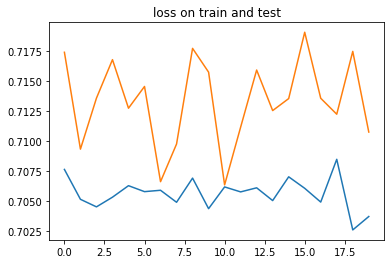

Last loss on train: 0.7037155121828602
Last loss on test: 0.7107347869559338


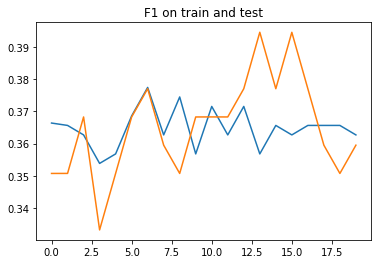

Last F1 on train: 0.36266836524009705
Last F1 on test: 0.35948273578756734


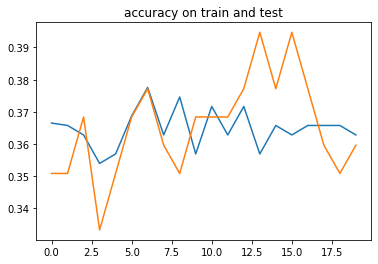

Last accuracy on train: 0.3628318679016248
Last accuracy on test: 0.3596491323489892


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.987440315549097


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

Доля предложений с ДФ среди правильных 0.0
Количество предложений с ДФ среди правильных 0


# Experiment 1, testing weights (0.001734, 1, 0.72)

* LSTM
* uni
* 1 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation



## Training

In [ ]:
model = LSTM(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


50it [00:01, 29.15it/s]

Train loss: 0.8532075219684176


91it [00:03, 20.31it/s]

Train loss: 0.8422480894459619


139it [00:06, 17.37it/s]

Train loss: 0.8439883170304475


183it [00:08, 22.05it/s]

Train loss: 0.8404129256804784


226it [00:09, 23.75it/s]


Train loss: 0.8473220366901821

Evaluating on train...


53it [00:01, 41.42it/s]

Val loss: 0.8321488618850708, Val f1: 0.3628112071090274, Val accuracy: 0.36296297245555453


98it [00:02, 41.52it/s]

Val loss: 0.8526157670550876, Val f1: 0.35538675718837315, Val accuracy: 0.3555555651585261


138it [00:03, 40.15it/s]

Val loss: 0.8479224381623445, Val f1: 0.36773565941386754, Val accuracy: 0.3679012439869068


185it [00:04, 34.87it/s]

Val loss: 0.8454472180869844, Val f1: 0.3627999504407247, Val accuracy: 0.36296297245555453


226it [00:05, 39.78it/s]


Val loss: 0.8460574984550476, Val f1: 0.3568748199939728, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 40.15it/s]

Val loss: 0.854658301671346, Val f1: 0.3776073892911275, Val accuracy: 0.3777777870496114


35it [00:00, 40.89it/s]

Val loss: 0.8466517766316731, Val f1: 0.37761278450489044, Val accuracy: 0.3777777870496114


50it [00:01, 40.29it/s]

Val loss: 0.8482001384099325, Val f1: 0.3627984384695689, Val accuracy: 0.36296297245555453


65it [00:01, 40.41it/s]

Val loss: 0.8520128498474757, Val f1: 0.37760515958070756, Val accuracy: 0.3777777870496114


76it [00:01, 40.76it/s]


Val loss: 0.8530064090092977, Val f1: 0.36871586124102274, Val accuracy: 0.3688888982931773

starting Epoch 1
Training...


50it [00:01, 27.94it/s]

Train loss: 0.8438297179010179


93it [00:03, 28.47it/s]

Train loss: 0.8533071478207906


139it [00:04, 28.25it/s]

Train loss: 0.8544831836665118


184it [00:06, 27.68it/s]

Train loss: 0.858540740940306


226it [00:07, 28.28it/s]


Train loss: 0.8489321348402236

Evaluating on train...


50it [00:01, 45.94it/s]

Val loss: 0.8504374980926513, Val f1: 0.3627985715866089, Val accuracy: 0.36296297245555453


95it [00:02, 39.33it/s]

Val loss: 0.8503321250279744, Val f1: 0.3479837871260113, Val accuracy: 0.34814815786149766


143it [00:03, 39.01it/s]

Val loss: 0.84240930168717, Val f1: 0.35786674839478955, Val accuracy: 0.35802470092420224


187it [00:04, 38.98it/s]

Val loss: 0.8400186876455943, Val f1: 0.35910279866721895, Val accuracy: 0.35925926880704034


226it [00:05, 40.35it/s]


Val loss: 0.8444069589508905, Val f1: 0.35391328944100275, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 34.89it/s]

Val loss: 0.8193743507067363, Val f1: 0.3331976811091105, Val accuracy: 0.3333333432674408


37it [00:01, 37.32it/s]

Val loss: 0.8396485249201456, Val f1: 0.3331811298926671, Val accuracy: 0.3333333432674408


50it [00:01, 37.44it/s]

Val loss: 0.8648319707976447, Val f1: 0.3331557995743222, Val accuracy: 0.3333333432674408


67it [00:01, 39.10it/s]

Val loss: 0.861538486679395, Val f1: 0.3331574653585752, Val accuracy: 0.3333333432674408


76it [00:02, 37.66it/s]


Val loss: 0.8574676378568014, Val f1: 0.33315964897473654, Val accuracy: 0.3333333432674408

starting Epoch 2
Training...


50it [00:01, 30.18it/s]

Train loss: 0.8490204652150471


95it [00:03, 28.33it/s]

Train loss: 0.8407221012645297


138it [00:04, 28.32it/s]

Train loss: 0.8360399184403596


184it [00:06, 28.50it/s]

Train loss: 0.8072467082076602


226it [00:08, 28.01it/s]


Train loss: 0.7728356655438741

Evaluating on train...


50it [00:01, 43.63it/s]

Val loss: 0.6054693182309469, Val f1: 0.37302196423212686, Val accuracy: 0.8681205809116364


95it [00:02, 40.09it/s]

Val loss: 0.6082545042037963, Val f1: 0.3700187368525399, Val accuracy: 0.8782337334420945


141it [00:03, 41.87it/s]

Val loss: 0.611512683056019, Val f1: 0.3699386696020762, Val accuracy: 0.8802576491126308


186it [00:04, 35.63it/s]

Val loss: 0.6113970965147019, Val f1: 0.37020542174577714, Val accuracy: 0.8893075563841396


226it [00:05, 40.31it/s]


Val loss: 0.611428611278534, Val f1: 0.3691266206900279, Val accuracy: 0.8898761904239655

Evaluating on test...


22it [00:00, 40.37it/s]

Val loss: 0.6358719110488892, Val f1: 0.36288421352704364, Val accuracy: 0.8752120633920034


37it [00:00, 40.30it/s]

Val loss: 0.6373941481113434, Val f1: 0.3631685187419256, Val accuracy: 0.8608949333429337


52it [00:01, 40.33it/s]

Val loss: 0.6353925479782953, Val f1: 0.36330710450808207, Val accuracy: 0.8510974877410464


67it [00:01, 40.98it/s]

Val loss: 0.6406388094027837, Val f1: 0.3633739118774732, Val accuracy: 0.8503013715147972


76it [00:01, 40.56it/s]


Val loss: 0.6440496309598287, Val f1: 0.3650875473022461, Val accuracy: 0.8475699889659881

starting Epoch 3
Training...


50it [00:01, 27.88it/s]

Train loss: 0.6077543536822001


95it [00:03, 27.25it/s]

Train loss: 0.6035501208570269


140it [00:05, 27.24it/s]

Train loss: 0.6054852671093411


184it [00:06, 24.07it/s]

Train loss: 0.6063174840476778


226it [00:08, 27.55it/s]


Train loss: 0.6029674159155951

Evaluating on train...


50it [00:01, 40.00it/s]

Val loss: 0.5776628891626994, Val f1: 0.38252416915363735, Val accuracy: 0.9428301393985749


95it [00:02, 41.05it/s]

Val loss: 0.5803281333711412, Val f1: 0.383200940489769, Val accuracy: 0.9427371028396818


139it [00:03, 39.62it/s]

Val loss: 0.5815679064503423, Val f1: 0.3851241288361726, Val accuracy: 0.9382325938454381


188it [00:04, 39.71it/s]

Val loss: 0.5846030318074756, Val f1: 0.38460114316807853, Val accuracy: 0.9269373522864448


226it [00:05, 40.48it/s]


Val loss: 0.5852661617596944, Val f1: 0.3850581212838491, Val accuracy: 0.9252567259470622

Evaluating on test...


19it [00:00, 42.28it/s]

Val loss: 0.597983165582021, Val f1: 0.37410637537638347, Val accuracy: 0.933456552028656


34it [00:00, 40.99it/s]

Val loss: 0.6036177357037862, Val f1: 0.3728160540262858, Val accuracy: 0.9061718940734863


49it [00:01, 41.02it/s]

Val loss: 0.6140507022539775, Val f1: 0.3730608575873905, Val accuracy: 0.8939363121986389


64it [00:01, 39.85it/s]

Val loss: 0.61485915184021, Val f1: 0.3775801256299019, Val accuracy: 0.8984516113996506


76it [00:01, 40.35it/s]


Val loss: 0.6105501826604207, Val f1: 0.3786021534601847, Val accuracy: 0.9005040852228801

starting Epoch 4
Training...


49it [00:01, 27.46it/s]

Train loss: 0.580795783466763


95it [00:03, 30.57it/s]

Train loss: 0.581689938571718


138it [00:04, 28.35it/s]

Train loss: 0.5863266225214357


184it [00:06, 26.47it/s]

Train loss: 0.584845875038041


226it [00:08, 28.01it/s]


Train loss: 0.5856995068656073

Evaluating on train...


50it [00:01, 45.62it/s]

Val loss: 0.5780557102627224, Val f1: 0.4171117299132877, Val accuracy: 0.9543144835366143


95it [00:02, 44.52it/s]

Val loss: 0.5820162183708615, Val f1: 0.41908301545514, Val accuracy: 0.9318163646592035


142it [00:03, 35.79it/s]

Val loss: 0.581773285512571, Val f1: 0.41487288077672324, Val accuracy: 0.9421122016730132


186it [00:04, 41.46it/s]

Val loss: 0.5801596406433317, Val f1: 0.414502068526215, Val accuracy: 0.9505057758755154


226it [00:05, 42.48it/s]


Val loss: 0.5786144004927741, Val f1: 0.41470370027754044, Val accuracy: 0.9462355258729723

Evaluating on test...


20it [00:00, 35.73it/s]

Val loss: 0.5914698719978333, Val f1: 0.4016852537790934, Val accuracy: 0.8879894157250722


36it [00:01, 34.90it/s]

Val loss: 0.6071277856826782, Val f1: 0.40247374574343364, Val accuracy: 0.8729356427987417


49it [00:01, 38.24it/s]

Val loss: 0.6027142021391126, Val f1: 0.402501415544086, Val accuracy: 0.878664473692576


66it [00:01, 38.63it/s]

Val loss: 0.6049018879731496, Val f1: 0.4061470329761505, Val accuracy: 0.8826797236998876


76it [00:02, 37.19it/s]


Val loss: 0.6047524158159892, Val f1: 0.4071717802683512, Val accuracy: 0.8740822430451711

starting Epoch 5
Training...


50it [00:01, 27.88it/s]

Train loss: 0.577990092171563


95it [00:03, 29.36it/s]

Train loss: 0.5766440987586975


141it [00:05, 21.86it/s]

Train loss: 0.5761578264059843


184it [00:07, 25.72it/s]

Train loss: 0.5784396260976792


226it [00:08, 25.37it/s]


Train loss: 0.5804653456476

Evaluating on train...


53it [00:01, 44.44it/s]

Val loss: 0.5761343333456251, Val f1: 0.40007700787650213, Val accuracy: 0.9336111081971062


98it [00:02, 43.89it/s]

Val loss: 0.5757115019692315, Val f1: 0.3973495741685232, Val accuracy: 0.9379794518152873


143it [00:03, 42.14it/s]

Val loss: 0.5770037673137806, Val f1: 0.3999474326769511, Val accuracy: 0.9419245057635837


188it [00:04, 40.53it/s]

Val loss: 0.5757828308476343, Val f1: 0.402342700958252, Val accuracy: 0.9523625400331285


226it [00:05, 39.58it/s]


Val loss: 0.5752648952272204, Val f1: 0.4012843900256687, Val accuracy: 0.954589637517929

Evaluating on test...


20it [00:00, 40.36it/s]

Val loss: 0.5989670872688293, Val f1: 0.3851202328999837, Val accuracy: 0.8679816206296285


34it [00:00, 39.94it/s]

Val loss: 0.6008473376433054, Val f1: 0.384389665722847, Val accuracy: 0.8724126905202866


49it [00:01, 25.06it/s]

Val loss: 0.6039558238453335, Val f1: 0.3860038167900509, Val accuracy: 0.8567441827721066


65it [00:02, 33.95it/s]

Val loss: 0.6053675005833308, Val f1: 0.3912487457195918, Val accuracy: 0.8706809476017952


76it [00:02, 33.04it/s]


Val loss: 0.6060331726074218, Val f1: 0.39231387813886004, Val accuracy: 0.8722685197989146

starting Epoch 6
Training...


49it [00:01, 26.80it/s]

Train loss: 0.5688845210605198


95it [00:03, 27.15it/s]

Train loss: 0.5717156059212155


140it [00:05, 29.20it/s]

Train loss: 0.5747326541829992


184it [00:06, 28.66it/s]

Train loss: 0.5760001821650399


226it [00:08, 27.51it/s]


Train loss: 0.5771709579891628

Evaluating on train...


49it [00:01, 40.48it/s]

Val loss: 0.5735274818208482, Val f1: 0.3911955025460985, Val accuracy: 0.9351031925943163


94it [00:02, 41.58it/s]

Val loss: 0.5734455777539147, Val f1: 0.39597163332833185, Val accuracy: 0.9558326012558407


140it [00:03, 36.60it/s]

Val loss: 0.5733074837260776, Val f1: 0.3927342957920498, Val accuracy: 0.9547554439968533


185it [00:04, 40.97it/s]

Val loss: 0.5743465602397919, Val f1: 0.39269440902603997, Val accuracy: 0.9537972420454025


226it [00:05, 39.80it/s]


Val loss: 0.5739327952596877, Val f1: 0.39293963935640125, Val accuracy: 0.9533955658806695

Evaluating on test...


19it [00:00, 38.71it/s]

Val loss: 0.6009924689928691, Val f1: 0.37719809214274086, Val accuracy: 0.9020326217015584


37it [00:00, 38.05it/s]

Val loss: 0.5974925637245179, Val f1: 0.37966312368710836, Val accuracy: 0.9251315732796986


49it [00:01, 36.29it/s]

Val loss: 0.5978257444169787, Val f1: 0.37915267745653786, Val accuracy: 0.924013172255622


66it [00:01, 37.60it/s]

Val loss: 0.6010873655478159, Val f1: 0.3805049647887548, Val accuracy: 0.9244694729646047


76it [00:02, 37.83it/s]


Val loss: 0.601959015528361, Val f1: 0.3818066740036011, Val accuracy: 0.9264391899108887

starting Epoch 7
Training...


50it [00:01, 27.44it/s]

Train loss: 0.5697545064820184


95it [00:03, 28.03it/s]

Train loss: 0.5772968841923608


139it [00:05, 29.26it/s]

Train loss: 0.5774915430280897


184it [00:06, 26.25it/s]

Train loss: 0.5769944594966041


226it [00:08, 27.18it/s]


Train loss: 0.5761768605973986

Evaluating on train...


50it [00:01, 45.47it/s]

Val loss: 0.5688892390992907, Val f1: 0.4070639815595415, Val accuracy: 0.9266113917032878


95it [00:02, 43.44it/s]

Val loss: 0.5711176262961494, Val f1: 0.40708197289043, Val accuracy: 0.9050527768002616


140it [00:03, 42.46it/s]

Val loss: 0.5714603803775928, Val f1: 0.41080075215410305, Val accuracy: 0.9249482976065742


185it [00:04, 43.25it/s]

Val loss: 0.5716619471708934, Val f1: 0.4105701400174035, Val accuracy: 0.9343273348278469


226it [00:05, 43.18it/s]


Val loss: 0.5725222675005595, Val f1: 0.4118066879113515, Val accuracy: 0.9397747503386603

Evaluating on test...


22it [00:00, 40.97it/s]

Val loss: 0.5962509671847026, Val f1: 0.40126575231552125, Val accuracy: 0.8990048170089722


37it [00:00, 40.89it/s]

Val loss: 0.611721787850062, Val f1: 0.401602174838384, Val accuracy: 0.8805384337902069


52it [00:01, 41.18it/s]

Val loss: 0.6099487013287015, Val f1: 0.3961825721793705, Val accuracy: 0.8555885798401303


67it [00:01, 42.25it/s]

Val loss: 0.6096130758523941, Val f1: 0.3986758942405383, Val accuracy: 0.8656628871957461


76it [00:01, 41.27it/s]


Val loss: 0.6051530504226684, Val f1: 0.39440670649210613, Val accuracy: 0.8664401539166768

starting Epoch 8
Training...


49it [00:01, 28.51it/s]

Train loss: 0.5749839107195537


95it [00:03, 28.85it/s]

Train loss: 0.574889616171519


140it [00:05, 25.92it/s]

Train loss: 0.5728286350214923


184it [00:06, 27.25it/s]

Train loss: 0.5733787622716692


226it [00:08, 27.20it/s]


Train loss: 0.5751914427015516

Evaluating on train...


51it [00:01, 43.86it/s]

Val loss: 0.572535404894087, Val f1: 0.38552705711788604, Val accuracy: 0.9858824888865153


96it [00:02, 39.36it/s]

Val loss: 0.5746301909287771, Val f1: 0.37965681089295283, Val accuracy: 0.9545448409186469


140it [00:03, 39.45it/s]

Val loss: 0.5758375644683837, Val f1: 0.3788541703312485, Val accuracy: 0.9482264114750756


186it [00:04, 41.61it/s]

Val loss: 0.5758674326870177, Val f1: 0.3797214825948079, Val accuracy: 0.9457096053494347


226it [00:05, 39.91it/s]


Val loss: 0.5760786255200704, Val f1: 0.37858234683672587, Val accuracy: 0.9461420534716712

Evaluating on test...


22it [00:00, 39.82it/s]

Val loss: 0.6019638220469157, Val f1: 0.3657936990261078, Val accuracy: 0.8561513304710389


35it [00:00, 39.52it/s]

Val loss: 0.5971928457419078, Val f1: 0.37014521261056266, Val accuracy: 0.886441844701767


51it [00:01, 38.89it/s]

Val loss: 0.5955243402057224, Val f1: 0.36811621321572197, Val accuracy: 0.9092923376295302


64it [00:01, 39.20it/s]

Val loss: 0.5974596331516902, Val f1: 0.36962425510088603, Val accuracy: 0.9180916170279185


76it [00:01, 39.58it/s]


Val loss: 0.6000095995267233, Val f1: 0.3703853952884674, Val accuracy: 0.9125791724522908

starting Epoch 9
Training...


48it [00:01, 28.41it/s]

Train loss: 0.57020972304874


95it [00:03, 28.30it/s]

Train loss: 0.5730891327063242


140it [00:05, 28.31it/s]

Train loss: 0.5730790147074947


185it [00:06, 25.97it/s]

Train loss: 0.5720443215635088


226it [00:08, 27.40it/s]


Train loss: 0.5730787022908529

Evaluating on train...


50it [00:01, 27.39it/s]

Val loss: 0.5715055094824897, Val f1: 0.395379892985026, Val accuracy: 0.9038922038343218


98it [00:03, 36.71it/s]

Val loss: 0.5720244301689996, Val f1: 0.3964521669679218, Val accuracy: 0.9264364865091111


143it [00:04, 39.85it/s]

Val loss: 0.5728859720406709, Val f1: 0.3996401753690508, Val accuracy: 0.933252137016367


183it [00:05, 38.76it/s]

Val loss: 0.5718801021575928, Val f1: 0.39978804091612496, Val accuracy: 0.9323129324449433


226it [00:06, 34.63it/s]


Val loss: 0.5714241679509481, Val f1: 0.4004833400249481, Val accuracy: 0.9339883569876353

Evaluating on test...


20it [00:00, 38.64it/s]

Val loss: 0.5884939352671306, Val f1: 0.3894567827383677, Val accuracy: 0.954802147547404


37it [00:00, 38.91it/s]

Val loss: 0.5939978659152985, Val f1: 0.38281344970067344, Val accuracy: 0.9152956306934357


49it [00:01, 37.25it/s]

Val loss: 0.5996000793245103, Val f1: 0.3843897846009996, Val accuracy: 0.915288405948215


65it [00:01, 34.00it/s]

Val loss: 0.6015901774168014, Val f1: 0.3858227089047432, Val accuracy: 0.9123187184333801


76it [00:02, 36.84it/s]


Val loss: 0.6041938757896423, Val f1: 0.38402815143267316, Val accuracy: 0.9063949370384217

starting Epoch 10
Training...


48it [00:01, 25.93it/s]

Train loss: 0.5730991270807054


93it [00:03, 26.53it/s]

Train loss: 0.5738550894790225


140it [00:05, 26.63it/s]

Train loss: 0.573167414576919


183it [00:06, 26.27it/s]

Train loss: 0.5716947088638942


226it [00:08, 26.69it/s]


Train loss: 0.5711851056416829

Evaluating on train...


49it [00:01, 40.03it/s]

Val loss: 0.5738848765691121, Val f1: 0.4091368748082055, Val accuracy: 0.9735161185264587


97it [00:02, 42.13it/s]

Val loss: 0.5710096895694733, Val f1: 0.4112355589866638, Val accuracy: 0.9665886650482813


142it [00:03, 42.45it/s]

Val loss: 0.5704492237832811, Val f1: 0.4101532914020397, Val accuracy: 0.9683335355034581


187it [00:04, 42.96it/s]

Val loss: 0.5706445505221684, Val f1: 0.4089454092913204, Val accuracy: 0.9540819706188308


226it [00:05, 41.88it/s]


Val loss: 0.5699043652746413, Val f1: 0.40820833060476513, Val accuracy: 0.9528177425596449

Evaluating on test...


19it [00:00, 41.04it/s]

Val loss: 0.6096101601918539, Val f1: 0.3979677398999532, Val accuracy: 0.9232258955637614


37it [00:00, 38.51it/s]

Val loss: 0.6005947113037109, Val f1: 0.3942907204230626, Val accuracy: 0.9190689365069071


50it [00:01, 39.22it/s]

Val loss: 0.601419370704227, Val f1: 0.3971791750854916, Val accuracy: 0.9216524097654555


66it [00:01, 38.83it/s]

Val loss: 0.6056899686654409, Val f1: 0.3954507494966189, Val accuracy: 0.9019153366486231


76it [00:01, 39.69it/s]


Val loss: 0.6055034065246582, Val f1: 0.3923886156082153, Val accuracy: 0.9075203855832418

starting Epoch 11
Training...


49it [00:01, 26.40it/s]

Train loss: 0.5699054863717821


94it [00:03, 25.12it/s]

Train loss: 0.5692880537774828


137it [00:05, 26.03it/s]

Train loss: 0.5702673373398958


183it [00:06, 27.35it/s]

Train loss: 0.5708164347542657


226it [00:08, 26.74it/s]


Train loss: 0.5703823712137011

Evaluating on train...


50it [00:01, 44.89it/s]

Val loss: 0.5756247997283935, Val f1: 0.3830538074175517, Val accuracy: 0.9520011716418796


98it [00:02, 38.85it/s]

Val loss: 0.574892090426551, Val f1: 0.3818154169453515, Val accuracy: 0.9613046275244819


139it [00:03, 38.51it/s]

Val loss: 0.5753811571333144, Val f1: 0.377615483822646, Val accuracy: 0.945049829394729


185it [00:04, 40.52it/s]

Val loss: 0.5739230457279417, Val f1: 0.380444911453459, Val accuracy: 0.9528977892465061


226it [00:05, 38.68it/s]


Val loss: 0.5733966747919719, Val f1: 0.38159999158647323, Val accuracy: 0.9572835524876913

Evaluating on test...


21it [00:00, 39.35it/s]

Val loss: 0.6011221369107564, Val f1: 0.37725836833318077, Val accuracy: 0.901148388783137


34it [00:00, 40.16it/s]

Val loss: 0.6131521979967753, Val f1: 0.37531814475854236, Val accuracy: 0.9005943129460017


51it [00:01, 36.35it/s]

Val loss: 0.6073720243242052, Val f1: 0.3719273587067922, Val accuracy: 0.9016855484909482


65it [00:01, 39.15it/s]

Val loss: 0.6055768658717473, Val f1: 0.3714067727327347, Val accuracy: 0.9118943865100543


76it [00:01, 38.03it/s]


Val loss: 0.604320158958435, Val f1: 0.3711466828982035, Val accuracy: 0.9146039867401123

starting Epoch 12
Training...


48it [00:01, 26.52it/s]

Train loss: 0.5719319820404053


94it [00:03, 27.20it/s]

Train loss: 0.5722038156456417


140it [00:05, 26.43it/s]

Train loss: 0.5717568697752776


185it [00:06, 27.83it/s]

Train loss: 0.5704752898878521


226it [00:08, 26.87it/s]


Train loss: 0.5700163711441888

Evaluating on train...


50it [00:01, 45.98it/s]

Val loss: 0.564818807442983, Val f1: 0.4110159416993459, Val accuracy: 0.9629441214932336


95it [00:02, 44.12it/s]

Val loss: 0.566586473915312, Val f1: 0.4215580168697569, Val accuracy: 0.9665275841951371


140it [00:03, 42.81it/s]

Val loss: 0.5658873633102134, Val f1: 0.42578014245739687, Val accuracy: 0.959536819767069


185it [00:04, 42.23it/s]

Val loss: 0.5663888980944951, Val f1: 0.4258280812038316, Val accuracy: 0.9630515257517497


226it [00:05, 42.18it/s]


Val loss: 0.5661506952179802, Val f1: 0.42558224148220486, Val accuracy: 0.9680614105860392

Evaluating on test...


21it [00:00, 37.68it/s]

Val loss: 0.5778376777966817, Val f1: 0.4096577882766724, Val accuracy: 0.9592181126276652


36it [00:00, 40.26it/s]

Val loss: 0.5921481986840565, Val f1: 0.406776495774587, Val accuracy: 0.9172952731450399


51it [00:01, 39.01it/s]

Val loss: 0.5950987842347887, Val f1: 0.40400015248192683, Val accuracy: 0.917523894045088


68it [00:01, 39.55it/s]

Val loss: 0.6076118439435959, Val f1: 0.40208349376916885, Val accuracy: 0.8952956984440485


76it [00:01, 39.14it/s]


Val loss: 0.6081937583287557, Val f1: 0.4006265028317769, Val accuracy: 0.8931143466631571

starting Epoch 13
Training...


49it [00:01, 27.92it/s]

Train loss: 0.5677209933598836


94it [00:03, 25.92it/s]

Train loss: 0.5653471555974748


139it [00:05, 25.43it/s]

Train loss: 0.5672857712816309


183it [00:06, 27.32it/s]

Train loss: 0.5686790466308593


226it [00:08, 26.75it/s]


Train loss: 0.5688944988780551

Evaluating on train...


50it [00:01, 41.53it/s]

Val loss: 0.5721614122390747, Val f1: 0.4159129030174679, Val accuracy: 0.8944964468479156


95it [00:02, 42.52it/s]

Val loss: 0.5688715113533868, Val f1: 0.4244358976682027, Val accuracy: 0.935091021988127


143it [00:03, 39.81it/s]

Val loss: 0.5680419586322926, Val f1: 0.42308769755893283, Val accuracy: 0.9480786584041737


186it [00:04, 38.84it/s]

Val loss: 0.5667792661322488, Val f1: 0.42449255138635633, Val accuracy: 0.9485770450698005


226it [00:05, 40.71it/s]


Val loss: 0.5670798823568556, Val f1: 0.4261814978387621, Val accuracy: 0.9553504943847656

Evaluating on test...


20it [00:00, 38.41it/s]

Val loss: 0.6199388901392618, Val f1: 0.38828581968943277, Val accuracy: 0.8231388012568156


36it [00:00, 37.84it/s]

Val loss: 0.6221582035223643, Val f1: 0.39731292724609374, Val accuracy: 0.8347904523213704


52it [00:01, 35.92it/s]

Val loss: 0.6141867544915941, Val f1: 0.39460235834121704, Val accuracy: 0.8494947936799792


64it [00:01, 36.39it/s]

Val loss: 0.6164508084456126, Val f1: 0.3996302291750908, Val accuracy: 0.8567763656377793


76it [00:02, 37.71it/s]


Val loss: 0.6130362240473429, Val f1: 0.4009091254075368, Val accuracy: 0.8483588631947835

starting Epoch 14
Training...


49it [00:01, 28.53it/s]

Train loss: 0.5658640768792894


93it [00:03, 26.01it/s]

Train loss: 0.5666011505656772


140it [00:05, 26.68it/s]

Train loss: 0.5665187981393602


183it [00:06, 26.08it/s]

Train loss: 0.5674128138356739


226it [00:08, 27.15it/s]


Train loss: 0.5668923531638251

Evaluating on train...


50it [00:01, 44.25it/s]

Val loss: 0.5653690218925476, Val f1: 0.4259505801730686, Val accuracy: 0.9615680661466387


95it [00:02, 44.43it/s]

Val loss: 0.5652073237631056, Val f1: 0.43453501959641777, Val accuracy: 0.9759224000904295


142it [00:03, 39.22it/s]

Val loss: 0.5667397521160267, Val f1: 0.4315482285287645, Val accuracy: 0.963544472279372


184it [00:04, 35.30it/s]

Val loss: 0.5670061863130993, Val f1: 0.43153867572546006, Val accuracy: 0.9685632429189153


226it [00:05, 40.49it/s]


Val loss: 0.5662264408005608, Val f1: 0.43450438963042365, Val accuracy: 0.9730775410599178

Evaluating on test...


21it [00:00, 36.54it/s]

Val loss: 0.5919851978619893, Val f1: 0.40290204882621766, Val accuracy: 0.8568573554356893


33it [00:00, 32.79it/s]

Val loss: 0.6215369502703348, Val f1: 0.3942455033461253, Val accuracy: 0.8110793699820836


49it [00:01, 35.34it/s]

Val loss: 0.6164897508091397, Val f1: 0.3990302907096015, Val accuracy: 0.8222896926932864


65it [00:01, 37.52it/s]

Val loss: 0.6144070267677307, Val f1: 0.4010175024469694, Val accuracy: 0.84742042273283


76it [00:02, 36.36it/s]


Val loss: 0.6151964847246806, Val f1: 0.40372140844662985, Val accuracy: 0.8557326384385426

starting Epoch 15
Training...


49it [00:01, 27.23it/s]

Train loss: 0.5704436328676011


94it [00:03, 28.01it/s]

Train loss: 0.5694732546806336


139it [00:05, 25.87it/s]

Train loss: 0.5681871966079429


183it [00:06, 27.20it/s]

Train loss: 0.5677795128689872


226it [00:08, 26.54it/s]


Train loss: 0.5670236455069648

Evaluating on train...


49it [00:01, 39.05it/s]

Val loss: 0.5648449367947048, Val f1: 0.4360223538345761, Val accuracy: 0.9445674214098189


96it [00:02, 43.56it/s]

Val loss: 0.5647900793287489, Val f1: 0.428510989745458, Val accuracy: 0.9375489503145218


140it [00:03, 40.18it/s]

Val loss: 0.5640445881419711, Val f1: 0.4337825781769223, Val accuracy: 0.9464249021477169


185it [00:04, 41.56it/s]

Val loss: 0.5647217813465331, Val f1: 0.4368637866444058, Val accuracy: 0.9385121352142758


226it [00:05, 40.40it/s]


Val loss: 0.5648923121558296, Val f1: 0.43862508177757265, Val accuracy: 0.9459948378139073

Evaluating on test...


20it [00:00, 38.09it/s]

Val loss: 0.6348541061083476, Val f1: 0.3963565468788147, Val accuracy: 0.8210402091344198


38it [00:00, 39.37it/s]

Val loss: 0.6259138683478037, Val f1: 0.39810135364532473, Val accuracy: 0.792927140990893


50it [00:01, 37.31it/s]

Val loss: 0.6197013073497348, Val f1: 0.4021454665395949, Val accuracy: 0.8340551369720035


66it [00:01, 38.21it/s]

Val loss: 0.6141423106193542, Val f1: 0.4048721854885419, Val accuracy: 0.8478352844715118


76it [00:01, 38.27it/s]


Val loss: 0.6121008483568827, Val f1: 0.40675101240475975, Val accuracy: 0.8599293192227682

starting Epoch 16
Training...


48it [00:01, 29.22it/s]

Train loss: 0.5639739486906263


95it [00:03, 27.15it/s]

Train loss: 0.5648767332235972


138it [00:05, 27.49it/s]

Train loss: 0.5649114622010125


183it [00:06, 26.66it/s]

Train loss: 0.5649018512831794


226it [00:08, 27.15it/s]


Train loss: 0.5657191885842218

Evaluating on train...


53it [00:01, 40.66it/s]

Val loss: 0.5635404043727451, Val f1: 0.42882421215375266, Val accuracy: 0.9492087225119273


96it [00:02, 39.64it/s]

Val loss: 0.5637753321064843, Val f1: 0.44062870211071437, Val accuracy: 0.9637301746341917


140it [00:03, 40.10it/s]

Val loss: 0.563759117214768, Val f1: 0.4409116601502454, Val accuracy: 0.9536977480959009


184it [00:04, 39.81it/s]

Val loss: 0.5639461490843031, Val f1: 0.44713850518067677, Val accuracy: 0.9552812587883738


226it [00:05, 40.62it/s]


Val loss: 0.5648450965351529, Val f1: 0.44744586242569817, Val accuracy: 0.95688884973526

Evaluating on test...


19it [00:00, 39.97it/s]

Val loss: 0.6145735581715902, Val f1: 0.40633275707562766, Val accuracy: 0.8150820910930634


37it [00:00, 39.61it/s]

Val loss: 0.6194698750972748, Val f1: 0.4050211449464162, Val accuracy: 0.8408311078945796


49it [00:01, 38.48it/s]

Val loss: 0.6158722771538628, Val f1: 0.4035631709628635, Val accuracy: 0.8167059938112895


65it [00:01, 35.61it/s]

Val loss: 0.6113919128974279, Val f1: 0.4134627396861712, Val accuracy: 0.8374847590923309


76it [00:01, 38.33it/s]


Val loss: 0.6148860359191894, Val f1: 0.41256046295166016, Val accuracy: 0.8429002094268799

starting Epoch 17
Training...


49it [00:01, 27.18it/s]

Train loss: 0.5654552472962273


94it [00:03, 27.37it/s]

Train loss: 0.5652104920811123


139it [00:05, 25.64it/s]

Train loss: 0.5646425180965


184it [00:06, 27.28it/s]

Train loss: 0.5650500317414602


226it [00:08, 26.81it/s]


Train loss: 0.5663710769017537

Evaluating on train...


50it [00:01, 46.14it/s]

Val loss: 0.5625067154566447, Val f1: 0.44528343743748133, Val accuracy: 0.9500688837634192


95it [00:02, 38.68it/s]

Val loss: 0.5642317798402574, Val f1: 0.4497043470541636, Val accuracy: 0.9481767574946086


142it [00:03, 36.33it/s]

Val loss: 0.5649126648902894, Val f1: 0.4447787578459139, Val accuracy: 0.936723866948375


184it [00:04, 40.51it/s]

Val loss: 0.564728100101153, Val f1: 0.4396171152591705, Val accuracy: 0.9285836946633127


226it [00:05, 38.93it/s]


Val loss: 0.5643096884091695, Val f1: 0.43993475053045483, Val accuracy: 0.935767885711458

Evaluating on test...


20it [00:00, 40.27it/s]

Val loss: 0.6076766689618428, Val f1: 0.40601946314175924, Val accuracy: 0.8817523837089538


35it [00:00, 38.33it/s]

Val loss: 0.6137948532899221, Val f1: 0.4142668584982554, Val accuracy: 0.8914912899335226


49it [00:01, 40.30it/s]

Val loss: 0.6078779631190829, Val f1: 0.4128956046369341, Val accuracy: 0.8919559631082746


68it [00:01, 39.50it/s]

Val loss: 0.6087750494480133, Val f1: 0.40790580610434213, Val accuracy: 0.8836682672301929


76it [00:01, 40.02it/s]


Val loss: 0.6101197934150696, Val f1: 0.4070760071277618, Val accuracy: 0.8782073028882345

starting Epoch 18
Training...


49it [00:01, 27.03it/s]

Train loss: 0.5637732651498583


93it [00:03, 28.05it/s]

Train loss: 0.5649080163902707


138it [00:05, 26.96it/s]

Train loss: 0.5649354184115375


184it [00:06, 26.92it/s]

Train loss: 0.5651413238710827


226it [00:08, 26.93it/s]


Train loss: 0.5658686039182875

Evaluating on train...


50it [00:01, 43.25it/s]

Val loss: 0.562901594903734, Val f1: 0.4472119324737125, Val accuracy: 0.9790654447343614


95it [00:02, 39.19it/s]

Val loss: 0.564995410044988, Val f1: 0.44202987286779616, Val accuracy: 0.9666689958837297


142it [00:03, 39.87it/s]

Val loss: 0.5644742029684561, Val f1: 0.4433791513796206, Val accuracy: 0.9706885262771889


185it [00:04, 38.05it/s]

Val loss: 0.564606499671936, Val f1: 0.4477850556373596, Val accuracy: 0.9741215775410335


226it [00:05, 40.25it/s]


Val loss: 0.5641799815495809, Val f1: 0.44777340597576565, Val accuracy: 0.9694140413072374

Evaluating on test...


19it [00:00, 41.12it/s]

Val loss: 0.624536915620168, Val f1: 0.4231014569600423, Val accuracy: 0.8442776004473368


34it [00:00, 39.29it/s]

Val loss: 0.6343203326066335, Val f1: 0.40893875261147816, Val accuracy: 0.8330035030841827


53it [00:01, 39.87it/s]

Val loss: 0.6230576700634427, Val f1: 0.41206343438890247, Val accuracy: 0.8620767368210687


68it [00:01, 40.74it/s]

Val loss: 0.6180080821116766, Val f1: 0.41066294560829797, Val accuracy: 0.8609515423576037


76it [00:01, 40.13it/s]


Val loss: 0.6157169938087463, Val f1: 0.4123766831556956, Val accuracy: 0.8729094056288401

starting Epoch 19
Training...


50it [00:01, 28.50it/s]

Train loss: 0.564485314157274


92it [00:04, 16.06it/s]

Train loss: 0.5634249647458395


138it [00:07, 16.38it/s]

Train loss: 0.5651940323688366


185it [00:10, 24.68it/s]

Train loss: 0.5652538359165191


226it [00:11, 19.16it/s]


Train loss: 0.5656613609525892

Evaluating on train...


50it [00:01, 44.37it/s]

Val loss: 0.5668718934059143, Val f1: 0.4376919753021664, Val accuracy: 0.933172517352634


95it [00:02, 42.80it/s]

Val loss: 0.5672807263003455, Val f1: 0.43762307465076444, Val accuracy: 0.9342013041178385


139it [00:03, 39.93it/s]

Val loss: 0.5659563598809418, Val f1: 0.4359603488886798, Val accuracy: 0.9538323137495253


183it [00:04, 40.33it/s]

Val loss: 0.5658769226736493, Val f1: 0.4339313589864307, Val accuracy: 0.9513439007931286


226it [00:05, 41.69it/s]


Val loss: 0.5655340247684055, Val f1: 0.4343056248293983, Val accuracy: 0.9567569185627831

Evaluating on test...


16it [00:00, 25.66it/s]

Val loss: 0.5790398200352986, Val f1: 0.4007444123427073, Val accuracy: 0.9601136525472005


34it [00:01, 21.75it/s]

Val loss: 0.6007400035858155, Val f1: 0.40200894077618915, Val accuracy: 0.9226146499315898


49it [00:02, 21.05it/s]

Val loss: 0.6082165956497192, Val f1: 0.4039254175292121, Val accuracy: 0.8961918009652032


67it [00:02, 28.88it/s]

Val loss: 0.6125796298185985, Val f1: 0.4049878641963005, Val accuracy: 0.8877708375453949


76it [00:03, 24.42it/s]

Val loss: 0.6131036067008973, Val f1: 0.40598689039548236, Val accuracy: 0.8872488069534302


## Graphics

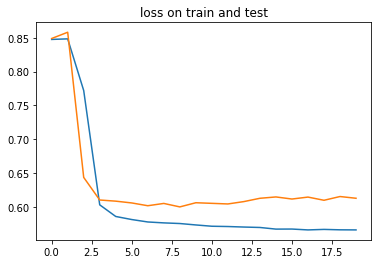

Last loss on train: 0.5657239369059031
Last loss on test: 0.6125650625479849


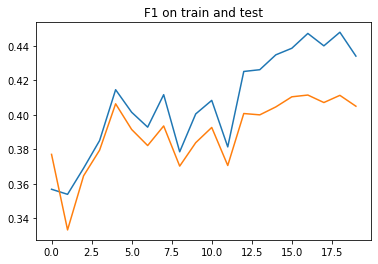

Last F1 on train: 0.4340775752753283
Last F1 on test: 0.40498338208386775


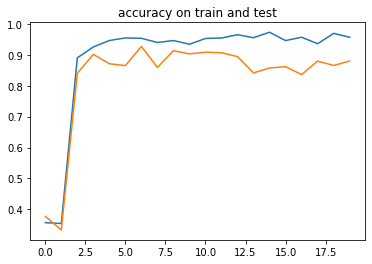

Last accuracy on train: 0.9569215699370983
Last accuracy on test: 0.8798663839697838


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.5662756902636495


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

was-B geht-I dich-I das-I an-I ?-O
ich-B glaube-I schon-I .-O
keine-B ahnung-I ,-O aber-O ein-O paar-O tage-O bestimmt-O noch-O .-O
ach-B was-I !-O
--O na-B klar-I .-O
ja-O ,-O ich-B verstehe-I .-O
also-B gut-I ,-O in-B ordnung-I ,-O aber-O halt-O ihn-O mir-O vom-O leib-O .-O
madame-O kali-O ,-O nicht-B wahr-I ?-O
nicht-B wahr-I ?-O
--O keine-B ahnung-I .-O
also-B gut-I .-O
ich-B glaube-I schon-I .-O
--O ich-B bin-I dabei-I .-O
hör-B auf-I !-O
--O ich-B bin-I dabei-I .-O
--O kein-B problem-I .-O
na-B gut-I ,-O äh-O ,-O wir-O sehen-O uns-O dann-O nachher-O .-O
und-B ob-I !-O
keine-B ahnung-I .-O
na-B schön-I ,-O aber-O als-O jemand-O ,-O dem-O etwas-O an-O dir-O liegt-O ,-O sag-O ich-O dir-O :-O --O du-O hast-O ernste-O probleme-O mit-O männern-O .-O
keine-B ahnung-I .-O
du-B hast-I recht-I .-O
--O in-B ordnung-I .-O
nein-O ,-O es-B geht-I nicht-I .-O
--O schon-B gut-I .-O
keine-B ahnung-I .-O
klar-B doch-I .-O
keine-B ahnung-I .-O
ist-B schon-I ok-I .-O
--O keine-B ahnung-I .-O
ich-B w

# Experiment 2, testing layers

* LSTM
* bi
* 1 cell
* 2 layers
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = LSTM(vocab_size=len(word2id), num_layers=2, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


47it [00:02, 20.46it/s]

Train loss: 0.853452475865682


92it [00:04, 17.43it/s]

Train loss: 0.8599564757612016


137it [00:07, 17.73it/s]

Train loss: 0.8478548301590814


183it [00:09, 20.15it/s]

Train loss: 0.8452999962700738


226it [00:12, 18.60it/s]


Train loss: 0.8465022007624309

Evaluating on train...


49it [00:01, 26.46it/s]

Val loss: 0.8668071415689257, Val f1: 0.33315648569001094, Val accuracy: 0.3333333432674408


96it [00:03, 31.55it/s]

Val loss: 0.8458209362294938, Val f1: 0.3627985732422935, Val accuracy: 0.36296297245555453


140it [00:05, 33.93it/s]

Val loss: 0.8482951923652932, Val f1: 0.36279671898594607, Val accuracy: 0.36296297245555453


184it [00:06, 35.55it/s]

Val loss: 0.8453907367255953, Val f1: 0.36650250206391016, Val accuracy: 0.3666666761040688


226it [00:07, 30.48it/s]


Val loss: 0.8411764192581177, Val f1: 0.36576546298133, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 38.08it/s]

Val loss: 0.8278165618578593, Val f1: 0.3331884960333506, Val accuracy: 0.3333333432674408


36it [00:01, 27.26it/s]

Val loss: 0.8580855091412862, Val f1: 0.3553849409023921, Val accuracy: 0.3555555651585261


49it [00:01, 31.20it/s]

Val loss: 0.8438494271702237, Val f1: 0.36280313862694635, Val accuracy: 0.36296297245555453


65it [00:02, 27.88it/s]

Val loss: 0.8622245053450267, Val f1: 0.35538053313891094, Val accuracy: 0.3555555651585261


76it [00:03, 25.11it/s]


Val loss: 0.8578194626172384, Val f1: 0.3598291524251302, Val accuracy: 0.36000000953674316

starting Epoch 1
Training...


49it [00:02, 20.26it/s]

Train loss: 0.8301355057292514


93it [00:05, 18.37it/s]

Train loss: 0.8467334561877781


138it [00:07, 20.99it/s]

Train loss: 0.8438856071896024


183it [00:09, 19.91it/s]

Train loss: 0.8493042204115125


226it [00:11, 19.01it/s]


Train loss: 0.8438078223334419

Evaluating on train...


49it [00:01, 35.41it/s]

Val loss: 0.8406318651305305, Val f1: 0.37761767639054195, Val accuracy: 0.3777777870496114


94it [00:02, 38.15it/s]

Val loss: 0.827533366282781, Val f1: 0.36281232866976, Val accuracy: 0.36296297245555453


139it [00:04, 34.37it/s]

Val loss: 0.8430251205409015, Val f1: 0.3578634111969559, Val accuracy: 0.35802470092420224


186it [00:05, 38.49it/s]

Val loss: 0.8422490189472834, Val f1: 0.3590995515386263, Val accuracy: 0.35925926880704034


226it [00:06, 35.62it/s]


Val loss: 0.8450693498717414, Val f1: 0.3598373725679186, Val accuracy: 0.36000000953674316

Evaluating on test...


22it [00:00, 38.54it/s]

Val loss: 0.8343271533648173, Val f1: 0.3776256382465363, Val accuracy: 0.3777777870496114


34it [00:00, 37.79it/s]

Val loss: 0.8293825030326843, Val f1: 0.399848332007726, Val accuracy: 0.4000000089406967


52it [00:01, 38.60it/s]

Val loss: 0.8540571318732367, Val f1: 0.37760373685095044, Val accuracy: 0.3777777870496114


64it [00:01, 37.50it/s]

Val loss: 0.856783405939738, Val f1: 0.3664928749203682, Val accuracy: 0.3666666761040688


76it [00:01, 38.27it/s]


Val loss: 0.8605338621139527, Val f1: 0.35982080856959026, Val accuracy: 0.36000000953674316

starting Epoch 2
Training...


48it [00:02, 17.14it/s]

Train loss: 0.8470259957843357


93it [00:05, 20.35it/s]

Train loss: 0.8426845729351043


138it [00:07, 21.64it/s]

Train loss: 0.8434872768543384


183it [00:09, 18.37it/s]

Train loss: 0.8391795800791846


226it [00:12, 18.15it/s]


Train loss: 0.8448124239179823

Evaluating on train...


50it [00:01, 34.04it/s]

Val loss: 0.8429628425174289, Val f1: 0.36280109220080903, Val accuracy: 0.36296297245555453


94it [00:02, 36.73it/s]

Val loss: 0.8172906650437249, Val f1: 0.3850416617261039, Val accuracy: 0.38518519434663984


138it [00:04, 28.16it/s]

Val loss: 0.8285280704498291, Val f1: 0.37268958599479113, Val accuracy: 0.3728395155182591


185it [00:05, 30.64it/s]

Val loss: 0.839689525961876, Val f1: 0.36650941967964173, Val accuracy: 0.3666666761040688


226it [00:06, 32.36it/s]


Val loss: 0.8384919553332859, Val f1: 0.36280683596928914, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 33.45it/s]

Val loss: 0.8336568593978881, Val f1: 0.3776179869969686, Val accuracy: 0.3777777870496114


37it [00:01, 36.24it/s]

Val loss: 0.8585943539937337, Val f1: 0.3553783615430196, Val accuracy: 0.3555555651585261


50it [00:01, 37.43it/s]

Val loss: 0.837640106678009, Val f1: 0.3479891512129042, Val accuracy: 0.34814815786149766


67it [00:01, 39.24it/s]

Val loss: 0.843087355295817, Val f1: 0.34428433924913404, Val accuracy: 0.3444444542129835


76it [00:02, 36.33it/s]


Val loss: 0.8563280773162841, Val f1: 0.3420503977934519, Val accuracy: 0.3422222320238749

starting Epoch 3
Training...


47it [00:02, 17.01it/s]

Train loss: 0.8068197634485033


92it [00:04, 20.14it/s]

Train loss: 0.8340014378229778


137it [00:07, 18.52it/s]

Train loss: 0.8308463882516932


182it [00:09, 17.58it/s]

Train loss: 0.836454517642657


226it [00:11, 19.14it/s]


Train loss: 0.8430360635121663

Evaluating on train...


52it [00:01, 36.12it/s]

Val loss: 0.8480670862727695, Val f1: 0.3479885717233022, Val accuracy: 0.34814815786149766


97it [00:02, 36.95it/s]

Val loss: 0.832870923810535, Val f1: 0.3628104478120804, Val accuracy: 0.36296297245555453


143it [00:03, 38.76it/s]

Val loss: 0.8486464897791545, Val f1: 0.3578597742098349, Val accuracy: 0.35802470092420224


187it [00:05, 34.12it/s]

Val loss: 0.8458553738064236, Val f1: 0.36280090742641025, Val accuracy: 0.36296297245555453


226it [00:06, 36.64it/s]


Val loss: 0.8482881172498067, Val f1: 0.35983683599366084, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 37.82it/s]

Val loss: 0.8594321211179098, Val f1: 0.33316832184791567, Val accuracy: 0.3333333432674408


36it [00:00, 36.59it/s]

Val loss: 0.8472949584325155, Val f1: 0.39983605643113457, Val accuracy: 0.4000000089406967


52it [00:01, 37.29it/s]

Val loss: 0.8495087623596191, Val f1: 0.37761516372362774, Val accuracy: 0.3777777870496114


65it [00:01, 38.84it/s]

Val loss: 0.859372153878212, Val f1: 0.3664992108941078, Val accuracy: 0.3666666761040688


76it [00:02, 37.89it/s]


Val loss: 0.861481696764628, Val f1: 0.3598293089866638, Val accuracy: 0.36000000953674316

starting Epoch 4
Training...


49it [00:02, 20.47it/s]

Train loss: 0.8242639581362406


93it [00:04, 18.02it/s]

Train loss: 0.8366315556897057


139it [00:07, 18.85it/s]

Train loss: 0.8342750893698798


182it [00:09, 17.45it/s]

Train loss: 0.8359384212228987


226it [00:11, 18.93it/s]


Train loss: 0.8466675610012478

Evaluating on train...


50it [00:01, 38.67it/s]

Val loss: 0.8365851534737481, Val f1: 0.37762051158481175, Val accuracy: 0.3777777870496114


94it [00:02, 33.37it/s]

Val loss: 0.8418190591865116, Val f1: 0.35539698600769043, Val accuracy: 0.3555555651585261


138it [00:03, 33.80it/s]

Val loss: 0.845672772107301, Val f1: 0.3529248619521106, Val accuracy: 0.35308642939284995


185it [00:05, 36.57it/s]

Val loss: 0.8471474866072337, Val f1: 0.3516901246375508, Val accuracy: 0.3518518615100119


226it [00:06, 35.55it/s]


Val loss: 0.8467019679811266, Val f1: 0.3598377300633325, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 33.63it/s]

Val loss: 0.8689316709836324, Val f1: 0.37759221394856773, Val accuracy: 0.3777777870496114


33it [00:00, 36.27it/s]

Val loss: 0.8542869488398234, Val f1: 0.35538370807965597, Val accuracy: 0.3555555651585261


51it [00:01, 38.60it/s]

Val loss: 0.8597427950965033, Val f1: 0.3479739699098799, Val accuracy: 0.34814815786149766


67it [00:01, 37.09it/s]

Val loss: 0.8622858812411626, Val f1: 0.3442694490154584, Val accuracy: 0.3444444542129835


76it [00:02, 36.02it/s]


Val loss: 0.8505516107877096, Val f1: 0.36872095545132955, Val accuracy: 0.3688888982931773

starting Epoch 5
Training...


48it [00:02, 17.32it/s]

Train loss: 0.8622830059793261


92it [00:04, 18.63it/s]

Train loss: 0.8705328431394365


138it [00:07, 18.87it/s]

Train loss: 0.8513086826712997


183it [00:09, 19.88it/s]

Train loss: 0.8513749857743581


226it [00:11, 19.10it/s]


Train loss: 0.8434395700030857

Evaluating on train...


52it [00:01, 40.04it/s]

Val loss: 0.8700920833481682, Val f1: 0.33315353128645153, Val accuracy: 0.3333333432674408


94it [00:02, 39.26it/s]

Val loss: 0.870200494925181, Val f1: 0.3479676567845874, Val accuracy: 0.34814815786149766


142it [00:03, 34.75it/s]

Val loss: 0.8634228260428817, Val f1: 0.34797393282254535, Val accuracy: 0.34814815786149766


187it [00:05, 36.12it/s]

Val loss: 0.8513062821494208, Val f1: 0.35538828389512167, Val accuracy: 0.3555555651585261


226it [00:06, 36.75it/s]


Val loss: 0.8461098681555854, Val f1: 0.36872465597258675, Val accuracy: 0.3688888982931773

Evaluating on test...


20it [00:00, 37.50it/s]

Val loss: 0.8138309160868327, Val f1: 0.3776449819405874, Val accuracy: 0.3777777870496114


36it [00:01, 33.22it/s]

Val loss: 0.8506779154141744, Val f1: 0.3553908973932266, Val accuracy: 0.3555555651585261


52it [00:01, 33.92it/s]

Val loss: 0.8445242709583707, Val f1: 0.3776146471500397, Val accuracy: 0.3777777870496114


64it [00:01, 36.55it/s]

Val loss: 0.8359361131985982, Val f1: 0.37761998176574707, Val accuracy: 0.3777777870496114


76it [00:02, 35.81it/s]


Val loss: 0.8542282748222351, Val f1: 0.3687158226966858, Val accuracy: 0.3688888982931773

starting Epoch 6
Training...


48it [00:02, 20.25it/s]

Train loss: 0.828432043393453


93it [00:05, 18.08it/s]

Train loss: 0.8342760059568617


137it [00:07, 19.40it/s]

Train loss: 0.8385726098661069


183it [00:09, 18.77it/s]

Train loss: 0.8421567284398609


226it [00:12, 18.59it/s]


Train loss: 0.8437817512618171

Evaluating on train...


48it [00:01, 35.98it/s]

Val loss: 0.8176047219170465, Val f1: 0.3628206511338552, Val accuracy: 0.36296297245555453


93it [00:02, 34.90it/s]

Val loss: 0.8283053682910071, Val f1: 0.36281159420808157, Val accuracy: 0.36296297245555453


141it [00:03, 37.20it/s]

Val loss: 0.8432206016999704, Val f1: 0.3677381601598528, Val accuracy: 0.3679012439869068


185it [00:05, 36.76it/s]

Val loss: 0.8368980172607634, Val f1: 0.37391560292906234, Val accuracy: 0.3740740834010972


226it [00:06, 35.43it/s]


Val loss: 0.8386917901039124, Val f1: 0.36873029165797766, Val accuracy: 0.3688888982931773

Evaluating on test...


20it [00:00, 32.14it/s]

Val loss: 0.9029071966807047, Val f1: 0.3331210752328237, Val accuracy: 0.3333333432674408


36it [00:01, 33.30it/s]

Val loss: 0.858139556646347, Val f1: 0.3331591079632441, Val accuracy: 0.3333333432674408


48it [00:01, 33.04it/s]

Val loss: 0.8537778695424397, Val f1: 0.3627894613477919, Val accuracy: 0.36296297245555453


64it [00:01, 34.17it/s]

Val loss: 0.8555573602517446, Val f1: 0.36649300505717597, Val accuracy: 0.3666666761040688


76it [00:02, 33.43it/s]


Val loss: 0.8578833357493083, Val f1: 0.3598244980971019, Val accuracy: 0.36000000953674316

starting Epoch 7
Training...


49it [00:02, 19.74it/s]

Train loss: 0.8567589124043783


93it [00:04, 18.43it/s]

Train loss: 0.8501590417491065


137it [00:07, 18.63it/s]

Train loss: 0.8545756891921714


184it [00:09, 19.75it/s]

Train loss: 0.8487974024481244


226it [00:11, 19.04it/s]


Train loss: 0.8450581028726366

Evaluating on train...


51it [00:01, 37.57it/s]

Val loss: 0.8426192561785381, Val f1: 0.4220567994647556, Val accuracy: 0.422222230831782


97it [00:02, 29.73it/s]

Val loss: 0.8386981805165609, Val f1: 0.3850229948759079, Val accuracy: 0.38518519434663984


141it [00:04, 35.20it/s]

Val loss: 0.8363077821554961, Val f1: 0.3776206303525854, Val accuracy: 0.3777777870496114


185it [00:05, 38.55it/s]

Val loss: 0.8389281352361043, Val f1: 0.3702124441663424, Val accuracy: 0.37037037975258297


226it [00:06, 35.37it/s]


Val loss: 0.841549904346466, Val f1: 0.36872948964436847, Val accuracy: 0.3688888982931773

Evaluating on test...


21it [00:00, 38.61it/s]

Val loss: 0.8599072217941284, Val f1: 0.3776012082894643, Val accuracy: 0.3777777870496114


37it [00:00, 38.57it/s]

Val loss: 0.8608196636041006, Val f1: 0.3775957634051641, Val accuracy: 0.3777777870496114


50it [00:01, 38.72it/s]

Val loss: 0.8488616718186273, Val f1: 0.39242389665709604, Val accuracy: 0.39259260164366827


67it [00:01, 38.27it/s]

Val loss: 0.8491942644119262, Val f1: 0.3998302474617958, Val accuracy: 0.4000000089406967


76it [00:01, 38.43it/s]


Val loss: 0.8536500072479248, Val f1: 0.38649450103441874, Val accuracy: 0.3866666758060455

starting Epoch 8
Training...


49it [00:02, 19.63it/s]

Train loss: 0.8516662981775072


92it [00:04, 17.48it/s]

Train loss: 0.8477066112889184


138it [00:07, 18.73it/s]

Train loss: 0.847820739392881


184it [00:09, 19.70it/s]

Train loss: 0.8467820733785629


226it [00:11, 18.94it/s]


Train loss: 0.8496470337443881

Evaluating on train...


48it [00:01, 33.93it/s]

Val loss: 0.8482678572336833, Val f1: 0.37761424250072906, Val accuracy: 0.3777777870496114


94it [00:02, 36.92it/s]

Val loss: 0.8335271749231551, Val f1: 0.37021863096290164, Val accuracy: 0.37037037975258297


142it [00:03, 39.45it/s]

Val loss: 0.8412681151319433, Val f1: 0.36280437531294646, Val accuracy: 0.36296297245555453


187it [00:05, 35.26it/s]

Val loss: 0.841039330429501, Val f1: 0.36280512544843885, Val accuracy: 0.36296297245555453


226it [00:06, 36.27it/s]


Val loss: 0.8479599947399563, Val f1: 0.36280000342263113, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 37.73it/s]

Val loss: 0.8447380264600118, Val f1: 0.33317877252896627, Val accuracy: 0.3333333432674408


37it [00:00, 39.34it/s]

Val loss: 0.8446950296560923, Val f1: 0.3553974429766337, Val accuracy: 0.3555555651585261


49it [00:01, 35.45it/s]

Val loss: 0.8610094414816962, Val f1: 0.34797732366455925, Val accuracy: 0.34814815786149766


65it [00:01, 36.82it/s]

Val loss: 0.8663340757290522, Val f1: 0.34427140454451244, Val accuracy: 0.3444444542129835


76it [00:02, 37.60it/s]


Val loss: 0.860024209022522, Val f1: 0.3598287304242452, Val accuracy: 0.36000000953674316

starting Epoch 9
Training...


48it [00:02, 18.28it/s]

Train loss: 0.8073840472433302


92it [00:04, 19.01it/s]

Train loss: 0.826963331302007


138it [00:07, 18.77it/s]

Train loss: 0.8341247739615264


182it [00:09, 18.82it/s]

Train loss: 0.8462840384907193


226it [00:11, 19.06it/s]


Train loss: 0.8429344336191813

Evaluating on train...


49it [00:01, 38.05it/s]

Val loss: 0.8550689458847046, Val f1: 0.37760745022031994, Val accuracy: 0.3777777870496114


98it [00:02, 39.08it/s]

Val loss: 0.8375382059150271, Val f1: 0.3850260506073634, Val accuracy: 0.38518519434663984


138it [00:03, 34.95it/s]

Val loss: 0.8417879554960462, Val f1: 0.3776179009013706, Val accuracy: 0.3777777870496114


186it [00:04, 38.23it/s]

Val loss: 0.8427241752545039, Val f1: 0.37391364789671366, Val accuracy: 0.3740740834010972


226it [00:06, 37.60it/s]


Val loss: 0.8440376048617892, Val f1: 0.37169032692909243, Val accuracy: 0.37185186121198865

Evaluating on test...


20it [00:00, 33.63it/s]

Val loss: 0.8259403705596924, Val f1: 0.3331857740879059, Val accuracy: 0.3333333432674408


36it [00:01, 31.69it/s]

Val loss: 0.8392260253429413, Val f1: 0.3331799268722534, Val accuracy: 0.3333333432674408


52it [00:01, 33.18it/s]

Val loss: 0.8494727783732944, Val f1: 0.33317311273680794, Val accuracy: 0.3333333432674408


65it [00:01, 36.39it/s]

Val loss: 0.8592858046293259, Val f1: 0.3331647624572118, Val accuracy: 0.3333333432674408


76it [00:02, 34.02it/s]


Val loss: 0.8565331991513571, Val f1: 0.3353857966264089, Val accuracy: 0.33555556535720826

starting Epoch 10
Training...


47it [00:02, 18.81it/s]

Train loss: 0.8691809018452962


94it [00:04, 18.91it/s]

Train loss: 0.8493467655446795


136it [00:07, 20.88it/s]

Train loss: 0.8416821055942112


183it [00:09, 18.47it/s]

Train loss: 0.8434617284271452


226it [00:11, 19.15it/s]


Train loss: 0.8430326305495368

Evaluating on train...


51it [00:01, 38.58it/s]

Val loss: 0.8323034551408556, Val f1: 0.34799309968948366, Val accuracy: 0.34814815786149766


98it [00:02, 38.85it/s]

Val loss: 0.8309800214237637, Val f1: 0.355402942498525, Val accuracy: 0.3555555651585261


140it [00:03, 37.47it/s]

Val loss: 0.8496690613252146, Val f1: 0.35291973021295336, Val accuracy: 0.35308642939284995


184it [00:04, 37.58it/s]

Val loss: 0.8517806424034966, Val f1: 0.35538689659701456, Val accuracy: 0.3555555651585261


226it [00:06, 37.41it/s]


Val loss: 0.8468063815434774, Val f1: 0.35390988800260753, Val accuracy: 0.3540740836991204

Evaluating on test...


21it [00:00, 38.96it/s]

Val loss: 0.8653848568598429, Val f1: 0.3776045203208923, Val accuracy: 0.3777777870496114


37it [00:00, 38.76it/s]

Val loss: 0.8525845110416412, Val f1: 0.35539350708325707, Val accuracy: 0.3555555651585261


49it [00:01, 38.42it/s]

Val loss: 0.8611215247048272, Val f1: 0.3479808416631487, Val accuracy: 0.34814815786149766


67it [00:01, 39.71it/s]

Val loss: 0.8532597998778025, Val f1: 0.35538981010516485, Val accuracy: 0.3555555651585261


76it [00:01, 38.54it/s]


Val loss: 0.8592137273152669, Val f1: 0.3509389666716258, Val accuracy: 0.35111112078030904

starting Epoch 11
Training...


47it [00:02, 19.86it/s]

Train loss: 0.8737733072704739


93it [00:04, 18.15it/s]

Train loss: 0.8445785601933797


136it [00:07, 18.90it/s]

Train loss: 0.8446241930679038


182it [00:09, 18.65it/s]

Train loss: 0.849824137489001


226it [00:12, 18.70it/s]


Train loss: 0.8484994297557407

Evaluating on train...


49it [00:01, 35.53it/s]

Val loss: 0.8452752139833238, Val f1: 0.34799037840631275, Val accuracy: 0.34814815786149766


94it [00:02, 35.62it/s]

Val loss: 0.8501426219940186, Val f1: 0.3479850285583072, Val accuracy: 0.34814815786149766


140it [00:03, 39.99it/s]

Val loss: 0.8474877900547452, Val f1: 0.35786246679447314, Val accuracy: 0.35802470092420224


184it [00:04, 35.92it/s]

Val loss: 0.8403110431300269, Val f1: 0.37391627497143215, Val accuracy: 0.3740740834010972


226it [00:06, 37.08it/s]


Val loss: 0.8446142715877957, Val f1: 0.3657650758160485, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 37.24it/s]

Val loss: 0.8792706410090129, Val f1: 0.333150182167689, Val accuracy: 0.3333333432674408


36it [00:00, 37.37it/s]

Val loss: 0.8765837291876475, Val f1: 0.33314977685610453, Val accuracy: 0.3333333432674408


52it [00:01, 37.10it/s]

Val loss: 0.8762001328998141, Val f1: 0.3331511669688755, Val accuracy: 0.3333333432674408


65it [00:01, 38.19it/s]

Val loss: 0.8568078756332398, Val f1: 0.33316401690244674, Val accuracy: 0.3333333432674408


76it [00:01, 38.05it/s]


Val loss: 0.8552237510681152, Val f1: 0.3331647721926371, Val accuracy: 0.3333333432674408

starting Epoch 12
Training...


49it [00:02, 20.12it/s]

Train loss: 0.8843105634053549


93it [00:04, 18.06it/s]

Train loss: 0.8435281932353973


138it [00:07, 19.15it/s]

Train loss: 0.8457902471224467


182it [00:09, 17.98it/s]

Train loss: 0.8549300018284056


226it [00:11, 19.08it/s]


Train loss: 0.8487179774708218

Evaluating on train...


48it [00:01, 34.13it/s]

Val loss: 0.8435315211613973, Val f1: 0.3627975708908505, Val accuracy: 0.36296297245555453


96it [00:02, 34.43it/s]

Val loss: 0.8400639838642544, Val f1: 0.35539881421460046, Val accuracy: 0.3555555651585261


141it [00:03, 36.42it/s]

Val loss: 0.828877185009144, Val f1: 0.3529367645581563, Val accuracy: 0.35308642939284995


187it [00:05, 38.07it/s]

Val loss: 0.849498517314593, Val f1: 0.34798047956493167, Val accuracy: 0.34814815786149766


226it [00:06, 35.79it/s]


Val loss: 0.8438626480102539, Val f1: 0.35391056776046753, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 38.63it/s]

Val loss: 0.8377309044202169, Val f1: 0.37762838999430337, Val accuracy: 0.3777777870496114


36it [00:00, 38.62it/s]

Val loss: 0.860245547691981, Val f1: 0.3776071151097616, Val accuracy: 0.3777777870496114


53it [00:01, 38.17it/s]

Val loss: 0.8530765427483453, Val f1: 0.37761152452892727, Val accuracy: 0.3777777870496114


65it [00:01, 37.93it/s]

Val loss: 0.8550834367672603, Val f1: 0.3664986118674278, Val accuracy: 0.3666666761040688


76it [00:01, 38.20it/s]


Val loss: 0.8503655544916788, Val f1: 0.3687218968073527, Val accuracy: 0.3688888982931773

starting Epoch 13
Training...


47it [00:02, 18.16it/s]

Train loss: 0.8318223052554661


91it [00:04, 18.19it/s]

Train loss: 0.8299950705634223


138it [00:07, 18.85it/s]

Train loss: 0.8386352132867884


183it [00:09, 20.29it/s]

Train loss: 0.8440286083353891


226it [00:11, 19.03it/s]


Train loss: 0.8401605738533868

Evaluating on train...


51it [00:01, 37.58it/s]

Val loss: 0.8759331213103401, Val f1: 0.3775773836506738, Val accuracy: 0.3777777870496114


96it [00:02, 38.16it/s]

Val loss: 0.8626769555939569, Val f1: 0.3701861997445424, Val accuracy: 0.37037037975258297


141it [00:03, 36.62it/s]

Val loss: 0.8433721471715856, Val f1: 0.3726722249278316, Val accuracy: 0.3728395155182591


186it [00:05, 35.03it/s]

Val loss: 0.8424098749955495, Val f1: 0.3702054409517182, Val accuracy: 0.37037037975258297


226it [00:06, 35.57it/s]


Val loss: 0.8408600894610087, Val f1: 0.3716896773709191, Val accuracy: 0.37185186121198865

Evaluating on test...


20it [00:00, 37.39it/s]

Val loss: 0.8850287675857544, Val f1: 0.3331442455450694, Val accuracy: 0.3333333432674408


36it [00:00, 36.30it/s]

Val loss: 0.878860068321228, Val f1: 0.3331478089094162, Val accuracy: 0.3333333432674408


48it [00:01, 33.96it/s]

Val loss: 0.864373426967197, Val f1: 0.3331625050968594, Val accuracy: 0.3333333432674408


64it [00:01, 34.42it/s]

Val loss: 0.8674232711394628, Val f1: 0.3331581711769104, Val accuracy: 0.3333333432674408


76it [00:02, 36.09it/s]


Val loss: 0.8570789845784506, Val f1: 0.342053484916687, Val accuracy: 0.3422222320238749

starting Epoch 14
Training...


47it [00:02, 19.29it/s]

Train loss: 0.8470092508527968


92it [00:04, 18.38it/s]

Train loss: 0.8386708213223352


137it [00:07, 19.13it/s]

Train loss: 0.8438361997957583


181it [00:09, 17.76it/s]

Train loss: 0.8446769876612558


226it [00:11, 19.27it/s]


Train loss: 0.8441588258743287

Evaluating on train...


53it [00:01, 38.10it/s]

Val loss: 0.8441519631279839, Val f1: 0.3479908585548401, Val accuracy: 0.34814815786149766


97it [00:02, 36.38it/s]

Val loss: 0.8297684801949395, Val f1: 0.34059307906362746, Val accuracy: 0.34074075056446923


139it [00:03, 37.67it/s]

Val loss: 0.8282297103493302, Val f1: 0.34306272753962763, Val accuracy: 0.3432098863301454


185it [00:05, 38.92it/s]

Val loss: 0.8369792772663964, Val f1: 0.34428968479235966, Val accuracy: 0.3444444542129835


226it [00:06, 36.94it/s]


Val loss: 0.8481445002555847, Val f1: 0.34205827209684586, Val accuracy: 0.3422222320238749

Evaluating on test...


20it [00:00, 38.17it/s]

Val loss: 0.8436029712359111, Val f1: 0.3331819494565328, Val accuracy: 0.3333333432674408


36it [00:00, 38.36it/s]

Val loss: 0.8275807003180186, Val f1: 0.35540332794189455, Val accuracy: 0.3555555651585261


52it [00:01, 38.46it/s]

Val loss: 0.8347770677672492, Val f1: 0.3628069546487596, Val accuracy: 0.36296297245555453


64it [00:01, 37.55it/s]

Val loss: 0.8489188820123672, Val f1: 0.35538898358742393, Val accuracy: 0.3555555651585261


76it [00:01, 38.17it/s]


Val loss: 0.8494921040534973, Val f1: 0.3687203776836395, Val accuracy: 0.3688888982931773

starting Epoch 15
Training...


48it [00:02, 19.76it/s]

Train loss: 0.8182262672318352


93it [00:04, 19.87it/s]

Train loss: 0.8419696450233459


137it [00:07, 19.65it/s]

Train loss: 0.8368161682729368


184it [00:09, 19.32it/s]

Train loss: 0.8391579343212976


226it [00:11, 19.04it/s]


Train loss: 0.8387015909618801

Evaluating on train...


52it [00:01, 37.66it/s]

Val loss: 0.8524963551097446, Val f1: 0.3479755222797394, Val accuracy: 0.34814815786149766


97it [00:02, 38.80it/s]

Val loss: 0.8477436171637641, Val f1: 0.3405733399920993, Val accuracy: 0.34074075056446923


139it [00:03, 35.55it/s]

Val loss: 0.850016760384595, Val f1: 0.33810656159012403, Val accuracy: 0.3382716147987931


187it [00:05, 36.69it/s]

Val loss: 0.8470663987927967, Val f1: 0.34798541019360224, Val accuracy: 0.34814815786149766


226it [00:06, 37.00it/s]


Val loss: 0.8439610446823967, Val f1: 0.3509516473611196, Val accuracy: 0.35111112078030904

Evaluating on test...


21it [00:00, 38.07it/s]

Val loss: 0.8153790632883707, Val f1: 0.37764137784639995, Val accuracy: 0.3777777870496114


37it [00:00, 38.30it/s]

Val loss: 0.8332119603951772, Val f1: 0.36095338861147563, Val accuracy: 0.36111112038294474


50it [00:01, 39.47it/s]

Val loss: 0.8462771866056654, Val f1: 0.35168094502555, Val accuracy: 0.3518518613444434


66it [00:01, 37.46it/s]

Val loss: 0.850693079829216, Val f1: 0.35816024194161095, Val accuracy: 0.3583333427707354


76it [00:01, 38.38it/s]


Val loss: 0.8548103260993958, Val f1: 0.3531579649448395, Val accuracy: 0.3533333428700765

starting Epoch 16
Training...


47it [00:02, 18.61it/s]

Train loss: 0.8629775789048937


92it [00:04, 17.23it/s]

Train loss: 0.8524642182721032


137it [00:07, 21.34it/s]

Train loss: 0.8538550085491604


183it [00:09, 19.45it/s]

Train loss: 0.849240881866879


226it [00:12, 18.82it/s]


Train loss: 0.8460151184929742

Evaluating on train...


49it [00:01, 36.60it/s]

Val loss: 0.8600861801041497, Val f1: 0.36278548770480684, Val accuracy: 0.36296297245555453


97it [00:02, 36.81it/s]

Val loss: 0.8372294651137457, Val f1: 0.3702112449540032, Val accuracy: 0.37037037975258297


140it [00:03, 38.39it/s]

Val loss: 0.8359243353207906, Val f1: 0.37268091683034543, Val accuracy: 0.3728395155182591


184it [00:05, 35.72it/s]

Val loss: 0.839904941784011, Val f1: 0.3776163667440414, Val accuracy: 0.3777777870496114


226it [00:06, 35.82it/s]


Val loss: 0.8439214992523193, Val f1: 0.3716890878147549, Val accuracy: 0.37185186121198865

Evaluating on test...


20it [00:00, 37.53it/s]

Val loss: 0.8020040194193522, Val f1: 0.4220940311749776, Val accuracy: 0.422222230831782


36it [00:00, 38.51it/s]

Val loss: 0.8188512086868286, Val f1: 0.37764275471369424, Val accuracy: 0.3777777870496114


53it [00:01, 38.17it/s]

Val loss: 0.8453363789452447, Val f1: 0.3776112092865838, Val accuracy: 0.3777777870496114


65it [00:01, 37.58it/s]

Val loss: 0.8469714800516764, Val f1: 0.3664998893936475, Val accuracy: 0.3666666761040688


76it [00:02, 37.62it/s]


Val loss: 0.8516601053873698, Val f1: 0.35982872009277345, Val accuracy: 0.36000000953674316

starting Epoch 17
Training...


47it [00:02, 21.20it/s]

Train loss: 0.8355881571769714


93it [00:04, 18.14it/s]

Train loss: 0.8328586313459608


137it [00:07, 20.18it/s]

Train loss: 0.8379708100248267


182it [00:09, 18.96it/s]

Train loss: 0.8507936437924702


226it [00:11, 18.87it/s]


Train loss: 0.8417822641796536

Evaluating on train...


52it [00:01, 36.48it/s]

Val loss: 0.8522240916887919, Val f1: 0.3776093827353583, Val accuracy: 0.3777777870496114


93it [00:02, 35.90it/s]

Val loss: 0.8491712265544468, Val f1: 0.37020296454429624, Val accuracy: 0.37037037975258297


142it [00:04, 36.26it/s]

Val loss: 0.8362492689379939, Val f1: 0.3776189958607709, Val accuracy: 0.3777777870496114


184it [00:05, 34.33it/s]

Val loss: 0.8424533605575562, Val f1: 0.37020749896764754, Val accuracy: 0.37037037975258297


226it [00:06, 35.66it/s]


Val loss: 0.8403909627596537, Val f1: 0.3657661611504025, Val accuracy: 0.3659259353743659

Evaluating on test...


21it [00:00, 37.60it/s]

Val loss: 0.8540584842363993, Val f1: 0.33315976659456886, Val accuracy: 0.3333333432674408


37it [00:00, 37.25it/s]

Val loss: 0.8746805290381113, Val f1: 0.33314664562543234, Val accuracy: 0.3333333432674408


49it [00:01, 37.78it/s]

Val loss: 0.8722249468167623, Val f1: 0.33315061728159584, Val accuracy: 0.3333333432674408


65it [00:01, 36.19it/s]

Val loss: 0.8715652366479237, Val f1: 0.3331526264548302, Val accuracy: 0.3333333432674408


76it [00:02, 37.38it/s]


Val loss: 0.861589649518331, Val f1: 0.34204972386360166, Val accuracy: 0.3422222320238749

starting Epoch 18
Training...


47it [00:02, 19.11it/s]

Train loss: 0.8641121943791708


92it [00:04, 17.98it/s]

Train loss: 0.8525665554735395


137it [00:07, 19.40it/s]

Train loss: 0.8474501773163124


182it [00:09, 18.48it/s]

Train loss: 0.8388727936479781


226it [00:11, 19.03it/s]


Train loss: 0.8426110614670648

Evaluating on train...


51it [00:01, 37.34it/s]

Val loss: 0.8523909979396396, Val f1: 0.3479819450113508, Val accuracy: 0.34814815786149766


94it [00:02, 38.36it/s]

Val loss: 0.8406884180174934, Val f1: 0.3553976641760932, Val accuracy: 0.3555555651585261


139it [00:03, 37.89it/s]

Val loss: 0.8409248890700164, Val f1: 0.35292934201381826, Val accuracy: 0.35308642939284995


184it [00:04, 37.22it/s]

Val loss: 0.845790500773324, Val f1: 0.34798838446537655, Val accuracy: 0.34814815786149766


226it [00:06, 36.85it/s]


Val loss: 0.8425895184940762, Val f1: 0.3509528981314765, Val accuracy: 0.35111112078030904

Evaluating on test...


20it [00:00, 34.25it/s]

Val loss: 0.8429317752520243, Val f1: 0.333165584007899, Val accuracy: 0.3333333432674408


36it [00:01, 33.33it/s]

Val loss: 0.851098891099294, Val f1: 0.33316618303457896, Val accuracy: 0.3333333432674408


52it [00:01, 36.57it/s]

Val loss: 0.8568655451138815, Val f1: 0.3331622302532196, Val accuracy: 0.3333333432674408


64it [00:01, 35.86it/s]

Val loss: 0.8316540678342184, Val f1: 0.34429035484790804, Val accuracy: 0.3444444542129835


76it [00:02, 34.63it/s]


Val loss: 0.8537452658017476, Val f1: 0.3420516578356425, Val accuracy: 0.3422222320238749

starting Epoch 19
Training...


48it [00:02, 19.33it/s]

Train loss: 0.8063108126322428


94it [00:04, 19.36it/s]

Train loss: 0.8352150082588196


139it [00:07, 19.59it/s]

Train loss: 0.8396801657146877


182it [00:09, 18.79it/s]

Train loss: 0.8423489838838577


226it [00:11, 18.85it/s]


Train loss: 0.8446799514028761

Evaluating on train...


52it [00:01, 38.62it/s]

Val loss: 0.8708202997843425, Val f1: 0.3479670478238, Val accuracy: 0.34814815786149766


96it [00:02, 37.31it/s]

Val loss: 0.8525337239106496, Val f1: 0.3553890671994951, Val accuracy: 0.3555555651585261


139it [00:03, 37.99it/s]

Val loss: 0.8559524717154327, Val f1: 0.37266765391385115, Val accuracy: 0.3728395155182591


184it [00:05, 33.65it/s]

Val loss: 0.8495346135563321, Val f1: 0.37020390215847226, Val accuracy: 0.37037037975258297


226it [00:06, 34.78it/s]


Val loss: 0.8436112700568306, Val f1: 0.37465356058544586, Val accuracy: 0.37481482413080003

Evaluating on test...


21it [00:00, 37.81it/s]

Val loss: 0.8815304557482402, Val f1: 0.3331423938274384, Val accuracy: 0.3333333432674408


37it [00:00, 38.12it/s]

Val loss: 0.8640112221240998, Val f1: 0.33315225740273796, Val accuracy: 0.3333333432674408


49it [00:01, 37.83it/s]

Val loss: 0.855047787560357, Val f1: 0.3331608361668057, Val accuracy: 0.3333333432674408


65it [00:01, 38.18it/s]

Val loss: 0.8647180567185084, Val f1: 0.33315343608458836, Val accuracy: 0.3333333432674408


76it [00:02, 37.62it/s]

Val loss: 0.8576441081364949, Val f1: 0.33315860748291015, Val accuracy: 0.3333333432674408


## Graphics

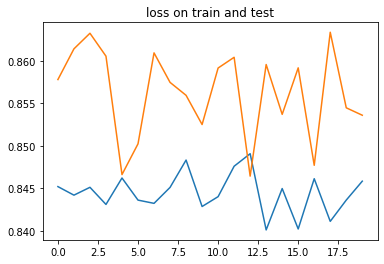

Last loss on train: 0.8458380554102164
Last loss on test: 0.8536151639725033


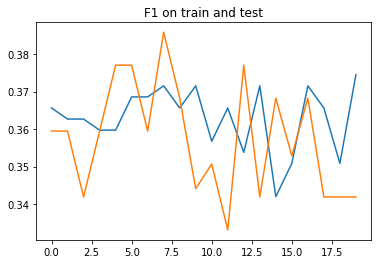

Last F1 on train: 0.3744698766849737
Last F1 on test: 0.34193283633181926


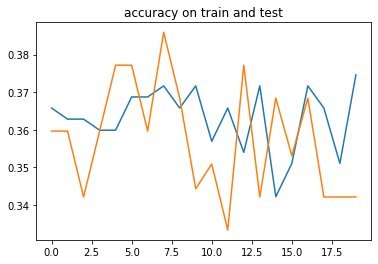

Last accuracy on train: 0.3746312777552984
Last accuracy on test: 0.3421052729612903


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.987440315549097


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

Доля предложений с ДФ среди правильных 0.0
Количество предложений с ДФ среди правильных 0


# Experiment 3, testing 2 cells

* LSTM
* uni
* 2 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = LSTM_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


49it [00:01, 26.98it/s]

Train loss: 0.8451087766223484


94it [00:03, 21.01it/s]

Train loss: 0.8496156778600481


138it [00:05, 25.26it/s]

Train loss: 0.8554822480237042


182it [00:07, 25.46it/s]

Train loss: 0.8552761127551397


226it [00:09, 25.04it/s]


Train loss: 0.8392646283573575

Evaluating on train...


50it [00:01, 46.79it/s]

Val loss: 0.6775433328416612, Val f1: 0.34074510600831776, Val accuracy: 0.8071322513951196


95it [00:02, 43.43it/s]

Val loss: 0.677395040459103, Val f1: 0.33845036625862124, Val accuracy: 0.7570573290189108


140it [00:03, 40.97it/s]

Val loss: 0.6785262558195326, Val f1: 0.33789377013842264, Val accuracy: 0.7540705329842038


188it [00:04, 41.62it/s]

Val loss: 0.6761956383784612, Val f1: 0.33738506966167026, Val accuracy: 0.7608248520228598


226it [00:05, 42.18it/s]


Val loss: 0.6794017367892795, Val f1: 0.3375677688916524, Val accuracy: 0.7596558337741428

Evaluating on test...


20it [00:00, 40.70it/s]

Val loss: 0.6858396609624227, Val f1: 0.3345881621042887, Val accuracy: 0.7155607501665752


35it [00:00, 40.75it/s]

Val loss: 0.681368613243103, Val f1: 0.33662697970867156, Val accuracy: 0.7229262868563334


49it [00:01, 38.46it/s]

Val loss: 0.6846102131737604, Val f1: 0.3370523108376397, Val accuracy: 0.7420109119680193


65it [00:01, 37.83it/s]

Val loss: 0.687734400232633, Val f1: 0.33778770913680395, Val accuracy: 0.7538018768032392


76it [00:01, 39.41it/s]


Val loss: 0.6843544467290242, Val f1: 0.33813927372296654, Val accuracy: 0.7692050099372864

starting Epoch 1
Training...


50it [00:01, 28.27it/s]

Train loss: 0.6378595021035937


93it [00:03, 29.03it/s]

Train loss: 0.6297641098499298


137it [00:04, 28.63it/s]

Train loss: 0.621004193800467


186it [00:06, 29.24it/s]

Train loss: 0.6187508427434497


226it [00:07, 28.38it/s]


Train loss: 0.6149838794602288

Evaluating on train...


51it [00:01, 46.97it/s]

Val loss: 0.5925381806161668, Val f1: 0.35620205733511184, Val accuracy: 0.953743890259001


96it [00:02, 45.79it/s]

Val loss: 0.5935584750440386, Val f1: 0.35584877298937906, Val accuracy: 0.9348930527766546


141it [00:03, 43.89it/s]

Val loss: 0.5913527360668889, Val f1: 0.3583937011383198, Val accuracy: 0.9421741911658534


184it [00:04, 40.40it/s]

Val loss: 0.593898493051529, Val f1: 0.3574760948618253, Val accuracy: 0.9355779709087477


226it [00:05, 43.46it/s]


Val loss: 0.5926301995913188, Val f1: 0.3586135654979282, Val accuracy: 0.936223155260086

Evaluating on test...


20it [00:00, 40.11it/s]

Val loss: 0.6048545002937317, Val f1: 0.3562425514062246, Val accuracy: 0.9453096707661947


35it [00:00, 42.11it/s]

Val loss: 0.6008548974990845, Val f1: 0.3568043142557144, Val accuracy: 0.9304120649894079


50it [00:01, 40.03it/s]

Val loss: 0.607090339395735, Val f1: 0.357573272784551, Val accuracy: 0.9114130331410302


67it [00:01, 37.46it/s]

Val loss: 0.6091086844603221, Val f1: 0.35597613006830214, Val accuracy: 0.9041365534067154


76it [00:01, 40.09it/s]


Val loss: 0.6084866825739542, Val f1: 0.35617940227190653, Val accuracy: 0.9104058885574341

starting Epoch 2
Training...


49it [00:01, 29.83it/s]

Train loss: 0.5964304950502184


95it [00:03, 28.97it/s]

Train loss: 0.5898411459392972


139it [00:04, 28.78it/s]

Train loss: 0.5900898355024832


184it [00:06, 28.23it/s]

Train loss: 0.592724257376459


226it [00:08, 28.05it/s]


Train loss: 0.5926302764150831

Evaluating on train...


50it [00:01, 47.35it/s]

Val loss: 0.5887518008550008, Val f1: 0.3924995952182346, Val accuracy: 0.9444157620271046


95it [00:02, 42.74it/s]

Val loss: 0.5854189164108701, Val f1: 0.39353177779250675, Val accuracy: 0.9580876678228378


138it [00:03, 35.40it/s]

Val loss: 0.5830830419505084, Val f1: 0.3929182564770734, Val accuracy: 0.9593932171662648


181it [00:04, 38.98it/s]

Val loss: 0.5837873564826117, Val f1: 0.39255185061030917, Val accuracy: 0.9533856476346652


226it [00:06, 35.37it/s]


Val loss: 0.5836604754130046, Val f1: 0.3914173371262021, Val accuracy: 0.9501394908958011

Evaluating on test...


19it [00:00, 25.43it/s]

Val loss: 0.6135658105214437, Val f1: 0.38862411777178446, Val accuracy: 0.910749864578247


35it [00:01, 34.97it/s]

Val loss: 0.6028415342171987, Val f1: 0.3816587587197622, Val accuracy: 0.8791227072477341


51it [00:01, 35.74it/s]

Val loss: 0.6062799374262492, Val f1: 0.38207176989979214, Val accuracy: 0.8930709103743235


67it [00:02, 37.21it/s]

Val loss: 0.6048023541768391, Val f1: 0.38593139698108037, Val accuracy: 0.8956175968050957


76it [00:02, 32.33it/s]


Val loss: 0.6039871470133463, Val f1: 0.38509320696194965, Val accuracy: 0.8916580470403036

starting Epoch 3
Training...


47it [00:01, 29.21it/s]

Train loss: 0.5894079367319743


94it [00:03, 28.33it/s]

Train loss: 0.5845385717021094


138it [00:04, 28.53it/s]

Train loss: 0.5852512222749215


182it [00:06, 26.26it/s]

Train loss: 0.5849208090040419


226it [00:08, 28.09it/s]


Train loss: 0.5860395712322659

Evaluating on train...


50it [00:01, 45.70it/s]

Val loss: 0.5774606029192607, Val f1: 0.38847136232588025, Val accuracy: 0.9630136284563277


95it [00:02, 40.86it/s]

Val loss: 0.5776206268204583, Val f1: 0.3853488776418898, Val accuracy: 0.9412328915463554


142it [00:03, 30.08it/s]

Val loss: 0.5784468893651609, Val f1: 0.3847311260523619, Val accuracy: 0.9328457947130556


187it [00:04, 40.36it/s]

Val loss: 0.5785498681995603, Val f1: 0.3833151012659073, Val accuracy: 0.9254941051204999


226it [00:05, 39.34it/s]


Val loss: 0.5785783433914184, Val f1: 0.3845459054576026, Val accuracy: 0.9238243876563178

Evaluating on test...


21it [00:00, 38.92it/s]

Val loss: 0.6078606724739075, Val f1: 0.3717560807863871, Val accuracy: 0.8666083415349325


33it [00:00, 36.51it/s]

Val loss: 0.6032239516576131, Val f1: 0.3736129581928253, Val accuracy: 0.8948401590188344


52it [00:01, 39.22it/s]

Val loss: 0.5957844879892137, Val f1: 0.37328130735291376, Val accuracy: 0.8639876431889004


65it [00:01, 38.35it/s]

Val loss: 0.5980525314807892, Val f1: 0.37771817793448764, Val accuracy: 0.8798706422249476


76it [00:01, 38.65it/s]


Val loss: 0.5966043408711751, Val f1: 0.37958927392959596, Val accuracy: 0.895288127263387

starting Epoch 4
Training...


50it [00:01, 27.98it/s]

Train loss: 0.582796143160926


93it [00:03, 28.43it/s]

Train loss: 0.5815508451726702


140it [00:05, 27.43it/s]

Train loss: 0.5799876707571524


184it [00:06, 28.23it/s]

Train loss: 0.5820829580227534


226it [00:08, 27.35it/s]


Train loss: 0.58177669233746

Evaluating on train...


50it [00:01, 40.94it/s]

Val loss: 0.5735449380344815, Val f1: 0.40768829319212174, Val accuracy: 0.9512202852302127


97it [00:02, 36.66it/s]

Val loss: 0.5746570514308081, Val f1: 0.4042303691307704, Val accuracy: 0.947833929128117


143it [00:03, 39.72it/s]

Val loss: 0.5755644921903257, Val f1: 0.4046130030243485, Val accuracy: 0.9449896434942882


187it [00:04, 39.82it/s]

Val loss: 0.5761178549793031, Val f1: 0.4030473152796427, Val accuracy: 0.9487030888597171


226it [00:05, 39.84it/s]


Val loss: 0.574609715408749, Val f1: 0.40258415818214416, Val accuracy: 0.9542325353622436

Evaluating on test...


21it [00:00, 35.53it/s]

Val loss: 0.578990618387858, Val f1: 0.3999257226785024, Val accuracy: 0.9578767021497091


38it [00:01, 37.11it/s]

Val loss: 0.5904070436954498, Val f1: 0.39657674233118695, Val accuracy: 0.9470263659954071


52it [00:01, 40.29it/s]

Val loss: 0.5909922056727939, Val f1: 0.3908389151096344, Val accuracy: 0.9100373698605432


66it [00:01, 38.86it/s]

Val loss: 0.5962291995684306, Val f1: 0.3914352163672447, Val accuracy: 0.8966495007276535


76it [00:02, 37.68it/s]


Val loss: 0.5976941394805908, Val f1: 0.3947216673692067, Val accuracy: 0.89686013062795

starting Epoch 5
Training...


48it [00:01, 28.49it/s]

Train loss: 0.5745016998714871


93it [00:03, 27.59it/s]

Train loss: 0.5781662245591481


137it [00:04, 26.07it/s]

Train loss: 0.5776023127414562


183it [00:06, 28.05it/s]

Train loss: 0.5758332186275058


226it [00:08, 27.99it/s]


Train loss: 0.5772278727425469

Evaluating on train...


50it [00:01, 44.78it/s]

Val loss: 0.5659382700920105, Val f1: 0.40275756319363915, Val accuracy: 0.9479753388298883


95it [00:02, 44.16it/s]

Val loss: 0.5661524713039399, Val f1: 0.4108198318216536, Val accuracy: 0.954150555200047


140it [00:03, 35.19it/s]

Val loss: 0.5679032290423358, Val f1: 0.41138486508969907, Val accuracy: 0.958021264385294


184it [00:04, 42.35it/s]

Val loss: 0.570831275317404, Val f1: 0.4090789904197057, Val accuracy: 0.9479436026679144


226it [00:05, 41.26it/s]


Val loss: 0.5713018205430772, Val f1: 0.4118061580922869, Val accuracy: 0.9546388673782349

Evaluating on test...


23it [00:00, 40.16it/s]

Val loss: 0.5916402220726014, Val f1: 0.3968849321206411, Val accuracy: 0.9479223291079203


38it [00:00, 41.24it/s]

Val loss: 0.5981565952301026, Val f1: 0.3970449835062027, Val accuracy: 0.8928997993469239


53it [00:01, 40.96it/s]

Val loss: 0.5997798244158427, Val f1: 0.4000162210729387, Val accuracy: 0.9032151778539022


68it [00:01, 41.08it/s]

Val loss: 0.5965592245260875, Val f1: 0.4033889104922613, Val accuracy: 0.915243590871493


76it [00:01, 40.68it/s]


Val loss: 0.5966472951571147, Val f1: 0.40126638412475585, Val accuracy: 0.9161547700564067

starting Epoch 6
Training...


48it [00:01, 27.60it/s]

Train loss: 0.5712312168545193


93it [00:03, 28.67it/s]

Train loss: 0.5737434301111434


140it [00:05, 28.01it/s]

Train loss: 0.5710321139406275


185it [00:06, 27.98it/s]

Train loss: 0.5728822102149328


226it [00:08, 27.44it/s]


Train loss: 0.5745644799868266

Evaluating on train...


54it [00:01, 47.43it/s]

Val loss: 0.5740334312121074, Val f1: 0.380219884051217, Val accuracy: 0.9233101983865102


94it [00:02, 41.24it/s]

Val loss: 0.5749547057681613, Val f1: 0.3836128569311566, Val accuracy: 0.9332427789767583


140it [00:03, 29.26it/s]

Val loss: 0.5743795297763966, Val f1: 0.38712572941073664, Val accuracy: 0.9445547287110929


186it [00:04, 39.81it/s]

Val loss: 0.573351205057568, Val f1: 0.38581215805477564, Val accuracy: 0.9481436856918865


226it [00:05, 38.23it/s]


Val loss: 0.5723690989282396, Val f1: 0.3861195606655545, Val accuracy: 0.9530834758281708

Evaluating on test...


20it [00:00, 41.26it/s]

Val loss: 0.599038855234782, Val f1: 0.3711189866065979, Val accuracy: 0.8955058912436168


35it [00:00, 39.97it/s]

Val loss: 0.6002200245857239, Val f1: 0.3727403700351715, Val accuracy: 0.9175371756156285


48it [00:01, 36.87it/s]

Val loss: 0.6012440588739183, Val f1: 0.37575728164778815, Val accuracy: 0.9059685846169789


65it [00:01, 37.43it/s]

Val loss: 0.5986259003480275, Val f1: 0.37741050869226456, Val accuracy: 0.9152000183860461


76it [00:01, 38.37it/s]


Val loss: 0.5987554144859314, Val f1: 0.3787174677848816, Val accuracy: 0.9176726313432058

starting Epoch 7
Training...


48it [00:01, 26.98it/s]

Train loss: 0.5670865535736084


94it [00:03, 26.12it/s]

Train loss: 0.5707871562904782


140it [00:05, 26.38it/s]

Train loss: 0.5725698466654177


183it [00:06, 27.07it/s]

Train loss: 0.5732273701164458


226it [00:08, 27.04it/s]


Train loss: 0.5732900706926981

Evaluating on train...


53it [00:01, 39.94it/s]

Val loss: 0.5722788678275215, Val f1: 0.4052181528674232, Val accuracy: 0.9523297588030497


98it [00:02, 41.89it/s]

Val loss: 0.5697361575232611, Val f1: 0.40019243756930034, Val accuracy: 0.9348584787713157


141it [00:03, 37.90it/s]

Val loss: 0.570853238635593, Val f1: 0.40321146293922705, Val accuracy: 0.950028572038368


187it [00:04, 37.67it/s]

Val loss: 0.569890026251475, Val f1: 0.40495582388506995, Val accuracy: 0.9601376220583916


226it [00:05, 38.97it/s]


Val loss: 0.5699208569526673, Val f1: 0.40596891774071586, Val accuracy: 0.9649137310187021

Evaluating on test...


20it [00:00, 40.94it/s]

Val loss: 0.5868427515029907, Val f1: 0.39417540431022646, Val accuracy: 0.9162275155385335


34it [00:00, 37.79it/s]

Val loss: 0.6008683184782664, Val f1: 0.39046353797117866, Val accuracy: 0.8894944926102956


53it [00:01, 40.60it/s]

Val loss: 0.5954242957962884, Val f1: 0.3904919955465529, Val accuracy: 0.9147580080562168


63it [00:01, 40.17it/s]

Val loss: 0.59850013256073, Val f1: 0.39345786372820535, Val accuracy: 0.9104135413964589


76it [00:01, 39.69it/s]


Val loss: 0.5954128487904866, Val f1: 0.39220200339953104, Val accuracy: 0.9223294798533122

starting Epoch 8
Training...


49it [00:01, 25.18it/s]

Train loss: 0.5698449995782641


95it [00:03, 28.48it/s]

Train loss: 0.5706425329049428


139it [00:05, 26.34it/s]

Train loss: 0.5710485047764249


184it [00:06, 26.31it/s]

Train loss: 0.5707519878943761


226it [00:08, 26.99it/s]


Train loss: 0.572273457315233

Evaluating on train...


50it [00:01, 46.14it/s]

Val loss: 0.5673645973205567, Val f1: 0.40071793066130745, Val accuracy: 0.9680404120021396


95it [00:02, 39.40it/s]

Val loss: 0.5673539188173082, Val f1: 0.4000769936376148, Val accuracy: 0.9641608281268014


141it [00:03, 37.19it/s]

Val loss: 0.5687196422506262, Val f1: 0.4007102621926202, Val accuracy: 0.9600037351802543


186it [00:04, 36.94it/s]

Val loss: 0.5691980934805341, Val f1: 0.3996928190191587, Val accuracy: 0.9516388667954339


226it [00:05, 38.63it/s]


Val loss: 0.5695836448669434, Val f1: 0.4008890309598711, Val accuracy: 0.9490308097998301

Evaluating on test...


19it [00:00, 40.03it/s]

Val loss: 0.6061027367909749, Val f1: 0.3878380358219147, Val accuracy: 0.9109319448471069


38it [00:00, 39.40it/s]

Val loss: 0.5920239547888438, Val f1: 0.3886135588089625, Val accuracy: 0.9339044094085693


50it [00:01, 38.32it/s]

Val loss: 0.5965989642673069, Val f1: 0.3873372044828203, Val accuracy: 0.9316823535495334


66it [00:01, 36.68it/s]

Val loss: 0.5980077127615611, Val f1: 0.386337344845136, Val accuracy: 0.9205930531024933


76it [00:01, 38.36it/s]


Val loss: 0.599340688387553, Val f1: 0.38973058342933653, Val accuracy: 0.921954239209493

starting Epoch 9
Training...


49it [00:01, 26.72it/s]

Train loss: 0.5669848667250739


94it [00:03, 27.19it/s]

Train loss: 0.5684654845131768


139it [00:05, 25.29it/s]

Train loss: 0.5692872078330429


182it [00:07, 16.56it/s]

Train loss: 0.5707089218828413


226it [00:09, 23.48it/s]


Train loss: 0.5711629308594598

Evaluating on train...


54it [00:01, 44.78it/s]

Val loss: 0.5681795954704285, Val f1: 0.42721643249193825, Val accuracy: 0.9580270740720961


91it [00:02, 28.68it/s]

Val loss: 0.5709702842765384, Val f1: 0.4189246949222353, Val accuracy: 0.9403888944122526


139it [00:05, 21.33it/s]

Val loss: 0.5691827208907516, Val f1: 0.41370306169545207, Val accuracy: 0.9383923031665661


185it [00:06, 32.83it/s]

Val loss: 0.5692064788606431, Val f1: 0.4123635881476932, Val accuracy: 0.9391058375438054


226it [00:08, 27.74it/s]


Val loss: 0.5692269690831502, Val f1: 0.4138110154204898, Val accuracy: 0.9437134525511

Evaluating on test...


19it [00:00, 38.76it/s]

Val loss: 0.6175261457761129, Val f1: 0.3985356052716573, Val accuracy: 0.8294759134451548


36it [00:00, 37.56it/s]

Val loss: 0.6077605485916138, Val f1: 0.39426167209943136, Val accuracy: 0.8654263744751612


49it [00:01, 38.77it/s]

Val loss: 0.6062040660116408, Val f1: 0.39650441474384734, Val accuracy: 0.8829999360773299


67it [00:01, 39.28it/s]

Val loss: 0.5997161080439886, Val f1: 0.3989452471335729, Val accuracy: 0.9034652506311734


76it [00:01, 39.09it/s]


Val loss: 0.6001481715838114, Val f1: 0.4006863327821096, Val accuracy: 0.9084710816542307

starting Epoch 10
Training...


48it [00:01, 27.51it/s]

Train loss: 0.5676267279518975


93it [00:03, 29.26it/s]

Train loss: 0.5693528559472826


138it [00:05, 27.61it/s]

Train loss: 0.5711342687960024


184it [00:06, 28.76it/s]

Train loss: 0.5710787607563866


226it [00:08, 27.34it/s]


Train loss: 0.5711387032932705

Evaluating on train...


50it [00:01, 40.52it/s]

Val loss: 0.5701568855179681, Val f1: 0.41799008117781744, Val accuracy: 0.9385700709289975


95it [00:02, 39.17it/s]

Val loss: 0.5688118159770965, Val f1: 0.41711447570059035, Val accuracy: 0.9412010361750921


141it [00:03, 34.77it/s]

Val loss: 0.5679998450809055, Val f1: 0.41472453232164735, Val accuracy: 0.9378376108628732


185it [00:04, 36.78it/s]

Val loss: 0.5673661980364058, Val f1: 0.41472898059421115, Val accuracy: 0.9402930935223898


226it [00:05, 38.98it/s]


Val loss: 0.5679111112488641, Val f1: 0.4170180706183116, Val accuracy: 0.9457282483577728

Evaluating on test...


19it [00:00, 37.23it/s]

Val loss: 0.6050975720087687, Val f1: 0.38521930774052937, Val accuracy: 0.8552571793397268


36it [00:00, 37.70it/s]

Val loss: 0.6086656987667084, Val f1: 0.3889815549055735, Val accuracy: 0.8509583582480749


49it [00:01, 38.79it/s]

Val loss: 0.6016081266933018, Val f1: 0.3948910885386997, Val accuracy: 0.8824807941913605


66it [00:01, 35.99it/s]

Val loss: 0.6007083922624588, Val f1: 0.39847687234481177, Val accuracy: 0.8841870710253715


76it [00:02, 37.95it/s]


Val loss: 0.6064591399828593, Val f1: 0.3986540218194326, Val accuracy: 0.8711599580446879

starting Epoch 11
Training...


49it [00:01, 26.98it/s]

Train loss: 0.5662996914651659


95it [00:03, 28.44it/s]

Train loss: 0.5670388268099891


140it [00:05, 26.67it/s]

Train loss: 0.5676094169969912


185it [00:06, 25.82it/s]

Train loss: 0.5685251279009713


226it [00:08, 26.85it/s]


Train loss: 0.569140502611796

Evaluating on train...


50it [00:01, 43.19it/s]

Val loss: 0.568193585342831, Val f1: 0.4276886198255751, Val accuracy: 0.9729396277003818


95it [00:02, 43.97it/s]

Val loss: 0.5679802881346808, Val f1: 0.4270662761396832, Val accuracy: 0.9704508437050714


140it [00:03, 37.30it/s]

Val loss: 0.5666290918986002, Val f1: 0.4277620576046131, Val accuracy: 0.9681912302970886


187it [00:04, 36.91it/s]

Val loss: 0.5669604185554716, Val f1: 0.4268535873956151, Val accuracy: 0.9617562762565083


226it [00:05, 40.44it/s]


Val loss: 0.5674395606252882, Val f1: 0.4264224576950073, Val accuracy: 0.9578287235895793

Evaluating on test...


20it [00:00, 34.85it/s]

Val loss: 0.5968550006548564, Val f1: 0.39969924887021385, Val accuracy: 0.8413045326868693


37it [00:01, 37.42it/s]

Val loss: 0.6189974089463551, Val f1: 0.4074097136656443, Val accuracy: 0.8261709243059159


49it [00:01, 38.54it/s]

Val loss: 0.6144168681568569, Val f1: 0.40606221689118277, Val accuracy: 0.8381823499997457


65it [00:01, 37.65it/s]

Val loss: 0.6108496377865473, Val f1: 0.4056596651673317, Val accuracy: 0.8578743060429891


76it [00:02, 37.06it/s]


Val loss: 0.6077985262870789, Val f1: 0.4053716317812602, Val accuracy: 0.8735262211163839

starting Epoch 12
Training...


50it [00:01, 27.14it/s]

Train loss: 0.5708214494917128


95it [00:03, 28.61it/s]

Train loss: 0.5696752945582072


138it [00:05, 25.90it/s]

Train loss: 0.5701499815340395


184it [00:06, 27.03it/s]

Train loss: 0.570045714908176


226it [00:08, 26.94it/s]


Train loss: 0.5705581633249919

Evaluating on train...


50it [00:01, 45.40it/s]

Val loss: 0.5658963163693745, Val f1: 0.42030924757321675, Val accuracy: 0.974602966176139


95it [00:02, 44.45it/s]

Val loss: 0.5686359657181634, Val f1: 0.41667870614263747, Val accuracy: 0.969969626598888


140it [00:03, 42.05it/s]

Val loss: 0.5676020860671998, Val f1: 0.4145702496722892, Val accuracy: 0.9677846745208457


185it [00:04, 42.75it/s]

Val loss: 0.56811985803975, Val f1: 0.4163791151510345, Val accuracy: 0.9687928792503145


226it [00:05, 42.80it/s]


Val loss: 0.5680945558018154, Val f1: 0.41845689641104805, Val accuracy: 0.9663374846511417

Evaluating on test...


20it [00:00, 41.39it/s]

Val loss: 0.5791543046633403, Val f1: 0.4015281657377879, Val accuracy: 0.9666515588760376


35it [00:00, 40.75it/s]

Val loss: 0.5963877379894257, Val f1: 0.39758880337079366, Val accuracy: 0.9300312886635462


50it [00:01, 40.76it/s]

Val loss: 0.6052324149343703, Val f1: 0.40252953900231253, Val accuracy: 0.9107480903466543


64it [00:01, 40.13it/s]

Val loss: 0.6059230903784434, Val f1: 0.3995057652393977, Val accuracy: 0.8949178233742714


76it [00:01, 40.68it/s]


Val loss: 0.6042829195658366, Val f1: 0.3997354849179586, Val accuracy: 0.9021323835849762

starting Epoch 13
Training...


48it [00:01, 27.46it/s]

Train loss: 0.5659770687421163


93it [00:03, 22.14it/s]

Train loss: 0.5679980887307061


138it [00:05, 25.30it/s]

Train loss: 0.5711120119801274


183it [00:07, 28.58it/s]

Train loss: 0.5696980486313502


226it [00:08, 25.63it/s]


Train loss: 0.5688312718603346

Evaluating on train...


49it [00:01, 42.00it/s]

Val loss: 0.5694244119856092, Val f1: 0.4354623476664225, Val accuracy: 0.9759765611754523


94it [00:02, 39.13it/s]

Val loss: 0.5691358698738946, Val f1: 0.4338593327336841, Val accuracy: 0.9715963919957479


139it [00:03, 36.02it/s]

Val loss: 0.5682994193500943, Val f1: 0.4356556272065198, Val accuracy: 0.9721010181638929


184it [00:04, 34.77it/s]

Val loss: 0.5677375455697378, Val f1: 0.43538889835278194, Val accuracy: 0.9716180806358655


226it [00:06, 37.23it/s]


Val loss: 0.5683257449997796, Val f1: 0.4359166951974233, Val accuracy: 0.9698319131798214

Evaluating on test...


20it [00:00, 38.00it/s]

Val loss: 0.6204529364903768, Val f1: 0.4115261236826579, Val accuracy: 0.8642396887143453


36it [00:00, 37.31it/s]

Val loss: 0.6234717766443888, Val f1: 0.41569323738416036, Val accuracy: 0.8468217035134633


52it [00:01, 37.53it/s]

Val loss: 0.6192203773392572, Val f1: 0.4145656751261817, Val accuracy: 0.858749180369907


65it [00:01, 38.32it/s]

Val loss: 0.6177677750587464, Val f1: 0.41075094739596046, Val accuracy: 0.8652674327294032


76it [00:02, 37.86it/s]


Val loss: 0.6151072271664937, Val f1: 0.41320760250091554, Val accuracy: 0.8728470691045125

starting Epoch 14
Training...


49it [00:01, 26.54it/s]

Train loss: 0.5711180647214253


94it [00:03, 28.06it/s]

Train loss: 0.5684813770982954


140it [00:05, 28.49it/s]

Train loss: 0.5706012116538154


184it [00:06, 27.16it/s]

Train loss: 0.5704064826170604


226it [00:08, 27.16it/s]


Train loss: 0.5690580783949958

Evaluating on train...


50it [00:01, 45.42it/s]

Val loss: 0.5668117139074538, Val f1: 0.44982392854160735, Val accuracy: 0.9732385012838576


95it [00:02, 41.86it/s]

Val loss: 0.5653673311074575, Val f1: 0.4517070608006583, Val accuracy: 0.9753515869379044


140it [00:03, 43.18it/s]

Val loss: 0.5652307717888444, Val f1: 0.44519861936569216, Val accuracy: 0.975469876880999


187it [00:04, 35.83it/s]

Val loss: 0.5671183758311802, Val f1: 0.4426944209469689, Val accuracy: 0.9722636709610621


226it [00:05, 41.54it/s]


Val loss: 0.5672794286410013, Val f1: 0.4393572229809231, Val accuracy: 0.9662740363015069

Evaluating on test...


19it [00:00, 42.37it/s]

Val loss: 0.6357310692469279, Val f1: 0.4144128203392029, Val accuracy: 0.8241947968800862


34it [00:00, 42.34it/s]

Val loss: 0.631888500849406, Val f1: 0.4151122152805328, Val accuracy: 0.8399329761664073


49it [00:01, 41.34it/s]

Val loss: 0.6248350302378337, Val f1: 0.41699372397528756, Val accuracy: 0.8555855764283075


64it [00:01, 40.83it/s]

Val loss: 0.6209284991025925, Val f1: 0.4126616969704628, Val accuracy: 0.8663857638835907


76it [00:01, 41.29it/s]


Val loss: 0.6155543835957845, Val f1: 0.41581241488456727, Val accuracy: 0.882257657845815

starting Epoch 15
Training...


48it [00:01, 28.14it/s]

Train loss: 0.5768398761749267


93it [00:03, 28.66it/s]

Train loss: 0.5727733386887445


140it [00:05, 28.06it/s]

Train loss: 0.5715895758734809


184it [00:06, 26.58it/s]

Train loss: 0.5709542208247714


226it [00:08, 27.32it/s]


Train loss: 0.5693830018573337

Evaluating on train...


49it [00:01, 26.79it/s]

Val loss: 0.563272938463423, Val f1: 0.4584048781130049, Val accuracy: 0.9929112354914348


94it [00:03, 34.03it/s]

Val loss: 0.5648373828993903, Val f1: 0.4547281629509396, Val accuracy: 0.9721929096513324


140it [00:04, 39.93it/s]

Val loss: 0.5650804819884123, Val f1: 0.4536463644769457, Val accuracy: 0.9685163252883487


187it [00:05, 38.69it/s]

Val loss: 0.5644101215733422, Val f1: 0.45778639084762995, Val accuracy: 0.9674397011597952


226it [00:06, 32.41it/s]


Val loss: 0.5649279832839966, Val f1: 0.4551083689265781, Val accuracy: 0.9660995108551449

Evaluating on test...


20it [00:00, 35.92it/s]

Val loss: 0.629729402065277, Val f1: 0.4191300948460897, Val accuracy: 0.8541918357213338


37it [00:00, 38.10it/s]

Val loss: 0.607089505592982, Val f1: 0.4230670352776845, Val accuracy: 0.9049208839734395


47it [00:01, 18.66it/s]

Val loss: 0.6143819053967794, Val f1: 0.42559449805153743, Val accuracy: 0.882324872414271


65it [00:02, 22.74it/s]

Val loss: 0.6092406034469604, Val f1: 0.42340538650751114, Val accuracy: 0.8799375946323077


76it [00:02, 25.70it/s]


Val loss: 0.6079645586013794, Val f1: 0.4263295618693034, Val accuracy: 0.8856175212065379

starting Epoch 16
Training...


47it [00:02, 20.99it/s]

Train loss: 0.5678935408592224


95it [00:04, 26.93it/s]

Train loss: 0.56526297794448


138it [00:05, 28.60it/s]

Train loss: 0.5656317225208989


181it [00:08, 17.37it/s]

Train loss: 0.5662821157111062


226it [00:10, 21.54it/s]


Train loss: 0.5662926069895426

Evaluating on train...


54it [00:01, 39.70it/s]

Val loss: 0.5624598940213521, Val f1: 0.4477796898947822, Val accuracy: 0.9653919107384152


96it [00:02, 41.68it/s]

Val loss: 0.5648387736744351, Val f1: 0.4437369700935152, Val accuracy: 0.9539396441645093


141it [00:03, 40.47it/s]

Val loss: 0.564486218823327, Val f1: 0.44024318390422396, Val accuracy: 0.9471977238301877


186it [00:04, 40.47it/s]

Val loss: 0.5654250681400299, Val f1: 0.44020918558041255, Val accuracy: 0.9533233417405023


226it [00:06, 37.48it/s]


Val loss: 0.5656739253467984, Val f1: 0.43665393988291423, Val accuracy: 0.9478205525875092

Evaluating on test...


23it [00:00, 39.75it/s]

Val loss: 0.5880531152089437, Val f1: 0.42203676303227744, Val accuracy: 0.8197452286879222


35it [00:00, 35.51it/s]

Val loss: 0.6078126688798269, Val f1: 0.40725937982400257, Val accuracy: 0.8015504648288091


51it [00:01, 36.93it/s]

Val loss: 0.6080986128913032, Val f1: 0.40830652051501803, Val accuracy: 0.8179495188925001


63it [00:01, 36.27it/s]

Val loss: 0.6123953779538472, Val f1: 0.40919291575749717, Val accuracy: 0.8254242350657781


76it [00:02, 36.32it/s]


Val loss: 0.6118533356984457, Val f1: 0.41248759349187214, Val accuracy: 0.8298857072989146

starting Epoch 17
Training...


48it [00:02, 25.63it/s]

Train loss: 0.5682393285963271


94it [00:03, 27.02it/s]

Train loss: 0.5667616347471873


140it [00:05, 26.91it/s]

Train loss: 0.5657858199543423


185it [00:07, 27.29it/s]

Train loss: 0.5671657267544005


226it [00:08, 25.32it/s]


Train loss: 0.5667048716545104

Evaluating on train...


50it [00:01, 44.95it/s]

Val loss: 0.5644266062312656, Val f1: 0.44141413039631316, Val accuracy: 0.9477165897687276


95it [00:02, 42.76it/s]

Val loss: 0.5646397564146254, Val f1: 0.4488932818174362, Val accuracy: 0.9479961219761107


139it [00:03, 35.20it/s]

Val loss: 0.5656693476217765, Val f1: 0.4469154393231427, Val accuracy: 0.958068310993689


185it [00:04, 38.90it/s]

Val loss: 0.5652792735232247, Val f1: 0.447495324909687, Val accuracy: 0.9592916457189454


226it [00:05, 40.37it/s]


Val loss: 0.5651385344399347, Val f1: 0.449884862502416, Val accuracy: 0.9568994266457028

Evaluating on test...


23it [00:00, 39.12it/s]

Val loss: 0.6103953758875529, Val f1: 0.41556789676348366, Val accuracy: 0.8456188142299652


36it [00:00, 40.04it/s]

Val loss: 0.604199481010437, Val f1: 0.42527004778385163, Val accuracy: 0.8856608678897222


50it [00:01, 41.04it/s]

Val loss: 0.6067902750439114, Val f1: 0.42068323824140763, Val accuracy: 0.8613737649387784


65it [00:01, 40.30it/s]

Val loss: 0.6122859418392181, Val f1: 0.42199416359265646, Val accuracy: 0.8681470096111298


76it [00:01, 40.17it/s]


Val loss: 0.6111388381322225, Val f1: 0.4205970958868663, Val accuracy: 0.8593975472450256

starting Epoch 18
Training...


50it [00:01, 26.67it/s]

Train loss: 0.5635018136766222


95it [00:03, 27.27it/s]

Train loss: 0.5648757722642687


140it [00:05, 28.20it/s]

Train loss: 0.564803942044576


185it [00:06, 27.55it/s]

Train loss: 0.5650465680493248


226it [00:08, 26.93it/s]


Train loss: 0.5659984803199768

Evaluating on train...


50it [00:01, 40.23it/s]

Val loss: 0.5650251984596253, Val f1: 0.4342707329326206, Val accuracy: 0.9774936026997036


96it [00:02, 34.96it/s]

Val loss: 0.5641915930642022, Val f1: 0.4326941235197915, Val accuracy: 0.9707570632298788


141it [00:03, 38.16it/s]

Val loss: 0.5652771327230666, Val f1: 0.4272665833985364, Val accuracy: 0.962033752379594


187it [00:04, 35.25it/s]

Val loss: 0.5653889424271054, Val f1: 0.42547092388073604, Val accuracy: 0.9622785730494393


226it [00:06, 37.21it/s]


Val loss: 0.5654465950859917, Val f1: 0.42701239228248594, Val accuracy: 0.9651538517740038

Evaluating on test...


20it [00:00, 33.89it/s]

Val loss: 0.6075846433639527, Val f1: 0.3975551187992096, Val accuracy: 0.9083715875943502


36it [00:01, 36.26it/s]

Val loss: 0.6095094422499339, Val f1: 0.40342366099357607, Val accuracy: 0.9130959451198578


53it [00:01, 38.65it/s]

Val loss: 0.6120694226688809, Val f1: 0.4035338792535994, Val accuracy: 0.9084546791182624


65it [00:01, 37.65it/s]

Val loss: 0.6061749597390492, Val f1: 0.402033960322539, Val accuracy: 0.9038972824811935


76it [00:02, 37.08it/s]


Val loss: 0.605710563659668, Val f1: 0.40318212072054543, Val accuracy: 0.9062358156840007

starting Epoch 19
Training...


49it [00:01, 28.17it/s]

Train loss: 0.5670844289991591


94it [00:03, 27.59it/s]

Train loss: 0.5664349463250902


140it [00:05, 27.49it/s]

Train loss: 0.5662359555562337


185it [00:06, 26.99it/s]

Train loss: 0.5659579230679406


226it [00:08, 26.91it/s]


Train loss: 0.565905167526669

Evaluating on train...


50it [00:01, 44.99it/s]

Val loss: 0.5646943357255724, Val f1: 0.42998418079482187, Val accuracy: 0.9323005318641663


95it [00:02, 42.99it/s]

Val loss: 0.564015273253123, Val f1: 0.4385642257001665, Val accuracy: 0.9545289466778437


140it [00:03, 42.80it/s]

Val loss: 0.5640260290216517, Val f1: 0.43654538680005955, Val accuracy: 0.9512452677444175


185it [00:04, 42.19it/s]

Val loss: 0.5644296016958025, Val f1: 0.43400258471568426, Val accuracy: 0.9568688622779317


226it [00:05, 42.35it/s]


Val loss: 0.563876830206977, Val f1: 0.4350750728448232, Val accuracy: 0.955647027624978

Evaluating on test...


21it [00:00, 36.69it/s]

Val loss: 0.588596761226654, Val f1: 0.419704532623291, Val accuracy: 0.9404846588770549


33it [00:00, 35.53it/s]

Val loss: 0.6085690498352051, Val f1: 0.4099865823984146, Val accuracy: 0.8901041984558106


49it [00:01, 34.68it/s]

Val loss: 0.612378117773268, Val f1: 0.407196134991116, Val accuracy: 0.8786597530047099


65it [00:01, 34.97it/s]

Val loss: 0.6152434279521306, Val f1: 0.40898900826772056, Val accuracy: 0.8821919153134028


76it [00:02, 35.72it/s]

Val loss: 0.6127610270182292, Val f1: 0.40828684210777283, Val accuracy: 0.8769384678204855


## Graphics

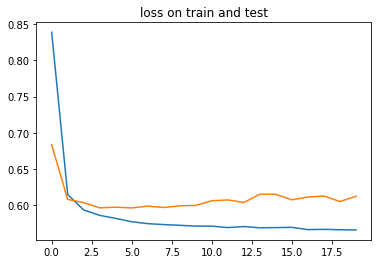

Last loss on train: 0.565880758836206
Last loss on test: 0.6123480694858652


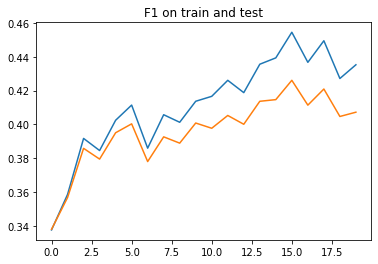

Last F1 on train: 0.43530329626745884
Last F1 on test: 0.40723514988234166


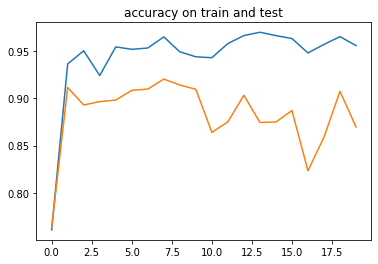

Last accuracy on train: 0.9558189821190539
Last accuracy on test: 0.8696567698528892


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Error on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.6204587917791157


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

klar-B doch-I .-O
keine-B ahnung-I .-O
--O mit-B vergnügen-I .-O
was-B du-I nicht-I sagst-I .-O
ich-B weiß-I .-O
ja-O ,-O ich-B verstehe-I .-O
nicht-B wahr-I ,-O trey-O ?-O
das-B geht-I gar-I nicht-I .-O
--O ach-B ja-I ?-O
ja-O ,-O warum-B nicht-I ?-O
ja-O ,-O aber-O ich-O hab-O das-O gefühl-O ,-O dass-O ihre-O freundin-O ein-O ...-O ein-O zombie-O ist-O ,-O schon-B möglich-I .-O
--O keine-B ahnung-I .-O
wenn-O uns-O ein-O abwehrmechanismus-O durch-O schlechte-O zeiten-O hilft-O ,-O na-B und-I ?-O
keine-B ahnung-I ,-O aber-O ein-O paar-O tage-O bestimmt-O noch-O .-O
auf-B keinen-I fall-I .-O
na-B gut-I ,-O kommt-O ,-O 2-O gegen-O einen-O .-O
keine-B ahnung-I .-O
keine-B ahnung-I ,-O schätzungsweise-O nirgendwohin-O .-O
--O gute-B idee-I .-O
--O klasse-O --O ich-B weiß-I .-O
keine-B ahnung-I .-O
--O so-B sei-I es-I !-O
na-B und-I ?-O
--O du-B hast-I recht-I .-O
du-B hast-I recht-I .-O
ich-B glaube-I schon-I .-O
warum-B nicht-I ?-O
--O na-B klar-I .-O
dein-B ernst-I ?-O
--O machen-B sie-

# Experiment 4, testing Bi-directional

* LSTM
* bi
* 1 cell
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

In [ ]:
model = BiLSTM(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


47it [00:02, 16.62it/s]

Train loss: 0.8560078554683261


91it [00:05, 19.02it/s]

Train loss: 0.8571168303489685


138it [00:08, 17.20it/s]

Train loss: 0.8533041618488453


182it [00:10, 19.94it/s]

Train loss: 0.8490031891398959


226it [00:12, 17.85it/s]


Train loss: 0.8463728510008918

Evaluating on train...


52it [00:01, 36.60it/s]

Val loss: 0.8373886704444885, Val f1: 0.34799598852793373, Val accuracy: 0.34814815786149766


97it [00:02, 35.83it/s]

Val loss: 0.838277268409729, Val f1: 0.3479947881566154, Val accuracy: 0.34814815786149766


142it [00:03, 35.92it/s]

Val loss: 0.8427353134861699, Val f1: 0.3578653189871046, Val accuracy: 0.35802470092420224


186it [00:05, 37.43it/s]

Val loss: 0.8449760264820523, Val f1: 0.3516919505265024, Val accuracy: 0.3518518615100119


226it [00:06, 36.57it/s]


Val loss: 0.8466249532169766, Val f1: 0.35391289591789243, Val accuracy: 0.3540740836991204

Evaluating on test...


22it [00:00, 37.81it/s]

Val loss: 0.8723267157872517, Val f1: 0.33316099445025127, Val accuracy: 0.3333333432674408


34it [00:00, 37.47it/s]

Val loss: 0.854345585902532, Val f1: 0.33317470649878184, Val accuracy: 0.3333333432674408


50it [00:01, 38.03it/s]

Val loss: 0.8743044389618768, Val f1: 0.3479684074719747, Val accuracy: 0.34814815786149766


66it [00:01, 37.72it/s]

Val loss: 0.8570413718620936, Val f1: 0.3442764868338903, Val accuracy: 0.3444444542129835


76it [00:01, 38.05it/s]


Val loss: 0.8538460715611775, Val f1: 0.3420566737651825, Val accuracy: 0.3422222320238749

starting Epoch 1
Training...


48it [00:02, 19.53it/s]

Train loss: 0.8420737995041742


93it [00:04, 19.39it/s]

Train loss: 0.8572860320409139


137it [00:07, 18.85it/s]

Train loss: 0.8527286233725371


181it [00:09, 16.28it/s]

Train loss: 0.8537651952770021


226it [00:12, 18.30it/s]


Train loss: 0.8463608805338542

Evaluating on train...


52it [00:01, 37.21it/s]

Val loss: 0.8768710494041443, Val f1: 0.36278079549471537, Val accuracy: 0.36296297245555453


97it [00:02, 36.09it/s]

Val loss: 0.8613087601131864, Val f1: 0.35538439949353534, Val accuracy: 0.3555555651585261


142it [00:03, 37.40it/s]

Val loss: 0.8582235230339899, Val f1: 0.3529167727187828, Val accuracy: 0.35308642939284995


183it [00:05, 35.40it/s]

Val loss: 0.8495663070016437, Val f1: 0.3553918997446696, Val accuracy: 0.3555555651585261


226it [00:06, 35.64it/s]


Val loss: 0.8435468003484938, Val f1: 0.3539144872294532, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 36.21it/s]

Val loss: 0.8748736063639323, Val f1: 0.3775908092657725, Val accuracy: 0.3777777870496114


37it [00:00, 38.44it/s]

Val loss: 0.8569777687390645, Val f1: 0.3776063323020935, Val accuracy: 0.3777777870496114


49it [00:01, 37.54it/s]

Val loss: 0.8564568784501817, Val f1: 0.37760442627800833, Val accuracy: 0.3777777870496114


65it [00:01, 37.14it/s]

Val loss: 0.8538896441459656, Val f1: 0.3776055723428726, Val accuracy: 0.3777777870496114


76it [00:02, 37.37it/s]


Val loss: 0.8516189559300741, Val f1: 0.3776086735725403, Val accuracy: 0.3777777870496114

starting Epoch 2
Training...


47it [00:02, 19.78it/s]

Train loss: 0.8746500107977125


91it [00:04, 17.24it/s]

Train loss: 0.8330954995420244


137it [00:07, 19.00it/s]

Train loss: 0.8414438998257673


182it [00:09, 19.40it/s]

Train loss: 0.8434791366259257


226it [00:12, 18.69it/s]


Train loss: 0.8427357686890496

Evaluating on train...


48it [00:01, 35.28it/s]

Val loss: 0.8562018023596869, Val f1: 0.34797306259473165, Val accuracy: 0.34814815786149766


97it [00:02, 36.70it/s]

Val loss: 0.8372170633739895, Val f1: 0.3479907052384483, Val accuracy: 0.34814815786149766


142it [00:03, 35.39it/s]

Val loss: 0.8342582009456776, Val f1: 0.3529320741141284, Val accuracy: 0.35308642939284995


187it [00:05, 37.07it/s]

Val loss: 0.8406450483534071, Val f1: 0.3591004856758647, Val accuracy: 0.35925926880704034


226it [00:06, 36.29it/s]


Val loss: 0.8454166486528185, Val f1: 0.3598374378681183, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 33.39it/s]

Val loss: 0.8552006642023723, Val f1: 0.3331708967685699, Val accuracy: 0.3333333432674408


36it [00:01, 31.08it/s]

Val loss: 0.8572984735171, Val f1: 0.35538478394349415, Val accuracy: 0.3555555651585261


52it [00:01, 34.98it/s]

Val loss: 0.8645320600933499, Val f1: 0.34797325399186874, Val accuracy: 0.34814815786149766


65it [00:01, 37.85it/s]

Val loss: 0.8513853003581365, Val f1: 0.3442744627594948, Val accuracy: 0.3444444542129835


76it [00:02, 35.24it/s]


Val loss: 0.8537277650833129, Val f1: 0.3420534213383993, Val accuracy: 0.3422222320238749

starting Epoch 3
Training...


47it [00:02, 20.14it/s]

Train loss: 0.8806750708156161


92it [00:04, 19.09it/s]

Train loss: 0.8572134210003747


139it [00:07, 20.04it/s]

Train loss: 0.8577164517508613


182it [00:09, 17.60it/s]

Train loss: 0.8500904033581416


226it [00:12, 18.80it/s]


Train loss: 0.8415868062443204

Evaluating on train...


52it [00:01, 37.68it/s]

Val loss: 0.8402014440960355, Val f1: 0.3479942719141642, Val accuracy: 0.34814815786149766


97it [00:02, 35.29it/s]

Val loss: 0.8435994989342159, Val f1: 0.34058301680617864, Val accuracy: 0.34074075056446923


141it [00:03, 35.13it/s]

Val loss: 0.8442174973311247, Val f1: 0.34305083641299494, Val accuracy: 0.3432098863301454


185it [00:05, 33.14it/s]

Val loss: 0.8445788671573004, Val f1: 0.34798937456475365, Val accuracy: 0.34814815786149766


226it [00:06, 35.50it/s]


Val loss: 0.8478502122561137, Val f1: 0.35094958119922215, Val accuracy: 0.35111112078030904

Evaluating on test...


20it [00:00, 36.38it/s]

Val loss: 0.8738631844520569, Val f1: 0.3331579824288686, Val accuracy: 0.3333333432674408


36it [00:01, 35.71it/s]

Val loss: 0.8535966316858927, Val f1: 0.37761260171731315, Val accuracy: 0.3777777870496114


49it [00:01, 36.94it/s]

Val loss: 0.8601510908868578, Val f1: 0.3627937992413839, Val accuracy: 0.36296297245555453


66it [00:01, 37.14it/s]

Val loss: 0.8654639959335327, Val f1: 0.35537927895784377, Val accuracy: 0.3555555651585261


76it [00:02, 36.84it/s]


Val loss: 0.8586558715502421, Val f1: 0.35982845624287924, Val accuracy: 0.36000000953674316

starting Epoch 4
Training...


48it [00:02, 20.05it/s]

Train loss: 0.7998446371820238


93it [00:04, 20.33it/s]

Train loss: 0.821725336710612


137it [00:07, 19.30it/s]

Train loss: 0.8274785006487811


183it [00:09, 18.75it/s]

Train loss: 0.8350928703943888


226it [00:12, 18.71it/s]


Train loss: 0.8428949605094062

Evaluating on train...


50it [00:01, 37.40it/s]

Val loss: 0.8286995463901096, Val f1: 0.36281578540802, Val accuracy: 0.36296297245555453


95it [00:02, 38.16it/s]

Val loss: 0.8301620887385475, Val f1: 0.3702202730708652, Val accuracy: 0.37037037975258297


139it [00:03, 37.93it/s]

Val loss: 0.8372876542585868, Val f1: 0.36280766946298104, Val accuracy: 0.36296297245555453


184it [00:05, 36.14it/s]

Val loss: 0.8457724673880471, Val f1: 0.3628015261557367, Val accuracy: 0.36296297245555453


226it [00:06, 36.54it/s]


Val loss: 0.8457140617900425, Val f1: 0.3598385418785943, Val accuracy: 0.36000000953674316

Evaluating on test...


21it [00:00, 36.35it/s]

Val loss: 0.8986154357592265, Val f1: 0.33312982122103374, Val accuracy: 0.3333333432674408


37it [00:01, 36.93it/s]

Val loss: 0.8665406227111816, Val f1: 0.3553772171338399, Val accuracy: 0.3555555651585261


49it [00:01, 33.56it/s]

Val loss: 0.8647676957978143, Val f1: 0.37759858502282034, Val accuracy: 0.3777777870496114


65it [00:01, 33.91it/s]

Val loss: 0.8604178875684738, Val f1: 0.37759970327218373, Val accuracy: 0.3777777870496114


76it [00:02, 34.60it/s]


Val loss: 0.8552231152852376, Val f1: 0.3776036250591278, Val accuracy: 0.3777777870496114

starting Epoch 5
Training...


48it [00:02, 19.04it/s]

Train loss: 0.8570275995466444


92it [00:04, 18.88it/s]

Train loss: 0.8541542020108964


137it [00:07, 16.78it/s]

Train loss: 0.8595542664881106


183it [00:09, 19.94it/s]

Train loss: 0.8458371069696214


226it [00:12, 18.27it/s]


Train loss: 0.8449771428108215

Evaluating on train...


51it [00:01, 37.98it/s]

Val loss: 0.8185701131820678, Val f1: 0.36282185051176286, Val accuracy: 0.36296297245555453


95it [00:02, 33.70it/s]

Val loss: 0.8330962823496925, Val f1: 0.355406462152799, Val accuracy: 0.3555555651585261


139it [00:04, 35.73it/s]

Val loss: 0.8428424799883807, Val f1: 0.3529294404718611, Val accuracy: 0.35308642939284995


184it [00:05, 37.29it/s]

Val loss: 0.8512745940022999, Val f1: 0.35539118631018535, Val accuracy: 0.3555555651585261


226it [00:06, 35.47it/s]


Val loss: 0.8473424164454142, Val f1: 0.3598374859491984, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 33.39it/s]

Val loss: 0.8777603467305501, Val f1: 0.3331487576166789, Val accuracy: 0.3333333432674408


36it [00:01, 34.41it/s]

Val loss: 0.8647929290930431, Val f1: 0.3331567237774531, Val accuracy: 0.3333333432674408


52it [00:01, 36.98it/s]

Val loss: 0.848406171798706, Val f1: 0.3331682006518046, Val accuracy: 0.3333333432674408


65it [00:01, 38.51it/s]

Val loss: 0.8627327521642049, Val f1: 0.33315359652042387, Val accuracy: 0.3333333432674408


76it [00:02, 35.95it/s]


Val loss: 0.8614527980486552, Val f1: 0.3331570629278819, Val accuracy: 0.3333333432674408

starting Epoch 6
Training...


47it [00:02, 20.02it/s]

Train loss: 0.8663157012727526


92it [00:04, 17.91it/s]

Train loss: 0.8426845676369137


138it [00:07, 17.76it/s]

Train loss: 0.8412825597657098


181it [00:09, 18.80it/s]

Train loss: 0.8444703171650568


226it [00:12, 18.60it/s]


Train loss: 0.8421436248885261

Evaluating on train...


49it [00:01, 36.45it/s]

Val loss: 0.8417891422907512, Val f1: 0.362801687584983, Val accuracy: 0.36296297245555453


95it [00:02, 38.73it/s]

Val loss: 0.8494695530997383, Val f1: 0.35538599292437234, Val accuracy: 0.3555555651585261


139it [00:03, 36.01it/s]

Val loss: 0.8473252420072203, Val f1: 0.36279697042924386, Val accuracy: 0.36296297245555453


187it [00:05, 36.08it/s]

Val loss: 0.8431976970699099, Val f1: 0.3628009354074796, Val accuracy: 0.36296297245555453


226it [00:06, 36.57it/s]


Val loss: 0.8408650178379483, Val f1: 0.3657660904195574, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 34.96it/s]

Val loss: 0.8223055402437845, Val f1: 0.37763175964355467, Val accuracy: 0.3777777870496114


36it [00:01, 36.25it/s]

Val loss: 0.811007171869278, Val f1: 0.3776429424683253, Val accuracy: 0.3777777870496114


52it [00:01, 36.47it/s]

Val loss: 0.8364486654599508, Val f1: 0.37762362559636437, Val accuracy: 0.3777777870496114


64it [00:01, 36.33it/s]

Val loss: 0.8600894649823506, Val f1: 0.3664914473891258, Val accuracy: 0.3666666761040688


76it [00:02, 36.20it/s]


Val loss: 0.856065837542216, Val f1: 0.3598304454485575, Val accuracy: 0.36000000953674316

starting Epoch 7
Training...


48it [00:02, 18.21it/s]

Train loss: 0.8385702557033963


93it [00:05, 18.02it/s]

Train loss: 0.8454144404994117


137it [00:07, 16.92it/s]

Train loss: 0.8434120107580114


182it [00:10, 18.62it/s]

Train loss: 0.8389651536941528


226it [00:12, 18.40it/s]


Train loss: 0.8456988877720303

Evaluating on train...


52it [00:01, 35.70it/s]

Val loss: 0.8515221966637505, Val f1: 0.3627968258327908, Val accuracy: 0.36296297245555453


96it [00:02, 35.45it/s]

Val loss: 0.8340060406261021, Val f1: 0.3702148016956117, Val accuracy: 0.37037037975258297


142it [00:03, 36.58it/s]

Val loss: 0.8383242227413036, Val f1: 0.36280513516178836, Val accuracy: 0.36296297245555453


186it [00:05, 35.79it/s]

Val loss: 0.8356141083770328, Val f1: 0.3628064006567001, Val accuracy: 0.36296297245555453


226it [00:06, 35.86it/s]


Val loss: 0.8439673720465766, Val f1: 0.3568757320774926, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 31.49it/s]

Val loss: 0.8756113489468892, Val f1: 0.3331495801607768, Val accuracy: 0.3333333432674408


36it [00:01, 33.01it/s]

Val loss: 0.8712160527706146, Val f1: 0.3331568310658137, Val accuracy: 0.3333333432674408


48it [00:01, 31.67it/s]

Val loss: 0.869517183303833, Val f1: 0.333159026172426, Val accuracy: 0.3333333432674408


64it [00:01, 33.47it/s]

Val loss: 0.8666995724042257, Val f1: 0.34427051891883215, Val accuracy: 0.3444444542129835


76it [00:02, 32.93it/s]


Val loss: 0.8605887301762899, Val f1: 0.3420534618695577, Val accuracy: 0.3422222320238749

starting Epoch 8
Training...


49it [00:02, 20.25it/s]

Train loss: 0.8494758658938938


92it [00:04, 19.21it/s]

Train loss: 0.8468002100785573


138it [00:07, 17.49it/s]

Train loss: 0.8558516899744669


183it [00:09, 18.95it/s]

Train loss: 0.849299763308631


226it [00:12, 18.46it/s]


Train loss: 0.848216458691491

Evaluating on train...


49it [00:01, 34.83it/s]

Val loss: 0.852422833442688, Val f1: 0.3331653734048208, Val accuracy: 0.3333333432674408


94it [00:02, 35.09it/s]

Val loss: 0.8542026811175876, Val f1: 0.3479784389336904, Val accuracy: 0.34814815786149766


143it [00:04, 37.02it/s]

Val loss: 0.8425510675818831, Val f1: 0.3479889898388474, Val accuracy: 0.34814815786149766


183it [00:05, 32.77it/s]

Val loss: 0.845075774523947, Val f1: 0.3479876599378056, Val accuracy: 0.34814815786149766


226it [00:06, 35.04it/s]


Val loss: 0.8425107706917657, Val f1: 0.35095126973258123, Val accuracy: 0.35111112078030904

Evaluating on test...


20it [00:00, 36.23it/s]

Val loss: 0.9076830705006917, Val f1: 0.42198439637819923, Val accuracy: 0.422222230831782


36it [00:01, 35.34it/s]

Val loss: 0.9218583961327871, Val f1: 0.3775378495454788, Val accuracy: 0.3777777870496114


52it [00:01, 36.60it/s]

Val loss: 0.8853561494085523, Val f1: 0.37757116357485454, Val accuracy: 0.3777777870496114


64it [00:01, 36.85it/s]

Val loss: 0.8568278421958287, Val f1: 0.3775963773330053, Val accuracy: 0.3777777870496114


76it [00:02, 36.59it/s]


Val loss: 0.8570698300997416, Val f1: 0.3687117898464203, Val accuracy: 0.3688888982931773

starting Epoch 9
Training...


46it [00:02, 17.14it/s]

Train loss: 0.8434032771322463


93it [00:05, 18.31it/s]

Train loss: 0.8387391004297469


136it [00:07, 17.88it/s]

Train loss: 0.8412220372094048


184it [00:09, 19.48it/s]

Train loss: 0.8436748868889279


226it [00:12, 18.67it/s]


Train loss: 0.8444598944981893

Evaluating on train...


52it [00:01, 36.57it/s]

Val loss: 0.850009826819102, Val f1: 0.34797800249523586, Val accuracy: 0.34814815786149766


98it [00:02, 38.50it/s]

Val loss: 0.8308734648757511, Val f1: 0.3554017636511061, Val accuracy: 0.3555555651585261


142it [00:03, 38.37it/s]

Val loss: 0.8441640310817294, Val f1: 0.3578601483945493, Val accuracy: 0.35802470092420224


187it [00:05, 27.12it/s]

Val loss: 0.8438439064555698, Val f1: 0.3553926996058888, Val accuracy: 0.3555555651585261


226it [00:06, 34.90it/s]


Val loss: 0.8434154454867046, Val f1: 0.35687543988227843, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 37.32it/s]

Val loss: 0.856108566125234, Val f1: 0.3331633448600769, Val accuracy: 0.3333333432674408


36it [00:00, 37.59it/s]

Val loss: 0.8643216411272685, Val f1: 0.3553748816251755, Val accuracy: 0.3555555651585261


49it [00:01, 38.48it/s]

Val loss: 0.859067149957021, Val f1: 0.34797374804814657, Val accuracy: 0.34814815786149766


65it [00:01, 37.89it/s]

Val loss: 0.8620120426019032, Val f1: 0.3442705432573954, Val accuracy: 0.3444444542129835


76it [00:02, 37.96it/s]


Val loss: 0.8519765464464824, Val f1: 0.35983168919881187, Val accuracy: 0.36000000953674316

starting Epoch 10
Training...


47it [00:02, 18.09it/s]

Train loss: 0.8467222531636556


91it [00:04, 18.53it/s]

Train loss: 0.8435959769619836


136it [00:07, 17.01it/s]

Train loss: 0.8433262670481646


183it [00:09, 20.10it/s]

Train loss: 0.8446613093217213


226it [00:12, 18.63it/s]


Train loss: 0.843809146616194

Evaluating on train...


48it [00:01, 34.84it/s]

Val loss: 0.8377979967329238, Val f1: 0.34798956447177465, Val accuracy: 0.34814815786149766


96it [00:02, 34.19it/s]

Val loss: 0.8288719203737047, Val f1: 0.36280610892507764, Val accuracy: 0.36296297245555453


141it [00:04, 36.32it/s]

Val loss: 0.8321289592319064, Val f1: 0.35786668614104944, Val accuracy: 0.35802470092420224


186it [00:05, 35.39it/s]

Val loss: 0.8349584089385138, Val f1: 0.3665075954463747, Val accuracy: 0.3666666761040688


226it [00:06, 34.73it/s]


Val loss: 0.8414966893196106, Val f1: 0.36280099087291295, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 34.21it/s]

Val loss: 0.8794361233711243, Val f1: 0.3775816738605499, Val accuracy: 0.3777777870496114


36it [00:01, 32.03it/s]

Val loss: 0.8714733680089315, Val f1: 0.35537075698375703, Val accuracy: 0.3555555651585261


48it [00:01, 32.03it/s]

Val loss: 0.8779614885648092, Val f1: 0.34795951909489103, Val accuracy: 0.34814815786149766


64it [00:01, 34.66it/s]

Val loss: 0.878790944814682, Val f1: 0.3442570279041926, Val accuracy: 0.3444444542129835


76it [00:02, 33.36it/s]


Val loss: 0.8628088291486105, Val f1: 0.3509357504049937, Val accuracy: 0.35111112078030904

starting Epoch 11
Training...


48it [00:02, 18.15it/s]

Train loss: 0.8434521277745565


92it [00:05, 17.61it/s]

Train loss: 0.8513854086399079


137it [00:07, 19.05it/s]

Train loss: 0.8502448448428401


182it [00:09, 18.15it/s]

Train loss: 0.8382392535607021


226it [00:12, 18.32it/s]


Train loss: 0.843571610185835

Evaluating on train...


49it [00:01, 35.74it/s]

Val loss: 0.8564090490341186, Val f1: 0.3331667489475674, Val accuracy: 0.3333333432674408


94it [00:02, 35.74it/s]

Val loss: 0.8486466957463159, Val f1: 0.3331711298889584, Val accuracy: 0.3333333432674408


142it [00:03, 37.26it/s]

Val loss: 0.849797785723651, Val f1: 0.3430467144206718, Val accuracy: 0.3432098863301454


184it [00:05, 38.46it/s]

Val loss: 0.8475102341837353, Val f1: 0.34428177575270336, Val accuracy: 0.3444444542129835


226it [00:06, 35.91it/s]


Val loss: 0.8413084125518799, Val f1: 0.34799062530199687, Val accuracy: 0.34814815786149766

Evaluating on test...


20it [00:00, 37.62it/s]

Val loss: 0.8756504535675049, Val f1: 0.3331523001194, Val accuracy: 0.3333333432674408


36it [00:00, 35.32it/s]

Val loss: 0.8619173129399618, Val f1: 0.3331636130809784, Val accuracy: 0.3333333432674408


52it [00:01, 35.33it/s]

Val loss: 0.860859231154124, Val f1: 0.3479751699500614, Val accuracy: 0.34814815786149766


64it [00:01, 33.24it/s]

Val loss: 0.8656375785668691, Val f1: 0.34426599244276684, Val accuracy: 0.3444444542129835


76it [00:02, 35.56it/s]


Val loss: 0.8600946275393168, Val f1: 0.3509343373775482, Val accuracy: 0.35111112078030904

starting Epoch 12
Training...


46it [00:02, 19.39it/s]

Train loss: 0.7865960505273607


93it [00:05, 18.61it/s]

Train loss: 0.8183349344465468


137it [00:07, 18.18it/s]

Train loss: 0.8288020350314953


183it [00:09, 19.51it/s]

Train loss: 0.8409947484731675


226it [00:12, 18.50it/s]


Train loss: 0.8455367408858405

Evaluating on train...


49it [00:01, 37.78it/s]

Val loss: 0.8388515048556857, Val f1: 0.3628065288066864, Val accuracy: 0.36296297245555453


94it [00:02, 36.64it/s]

Val loss: 0.8432007537947761, Val f1: 0.37020702759424845, Val accuracy: 0.37037037975258297


142it [00:03, 36.29it/s]

Val loss: 0.8423692045388398, Val f1: 0.37761607479166104, Val accuracy: 0.3777777870496114


187it [00:05, 36.76it/s]

Val loss: 0.8465853763951195, Val f1: 0.36650204559167227, Val accuracy: 0.3666666761040688


226it [00:06, 37.14it/s]


Val loss: 0.8424680617120531, Val f1: 0.36280154440138074, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 35.99it/s]

Val loss: 0.8332353870073954, Val f1: 0.42206594745318093, Val accuracy: 0.422222230831782


36it [00:00, 36.79it/s]

Val loss: 0.836575049161911, Val f1: 0.37762633164723713, Val accuracy: 0.3777777870496114


52it [00:01, 37.58it/s]

Val loss: 0.8450187510914273, Val f1: 0.3628040671348572, Val accuracy: 0.36296297245555453


64it [00:01, 37.48it/s]

Val loss: 0.848917555809021, Val f1: 0.35816781371831896, Val accuracy: 0.3583333427707354


76it [00:02, 36.80it/s]


Val loss: 0.8543689195315043, Val f1: 0.35316526611646015, Val accuracy: 0.3533333428700765

starting Epoch 13
Training...


47it [00:02, 18.29it/s]

Train loss: 0.8396538045671251


93it [00:05, 17.04it/s]

Train loss: 0.8354229675398932


137it [00:07, 18.15it/s]

Train loss: 0.8402601974981803


182it [00:09, 18.41it/s]

Train loss: 0.8429608126481374


226it [00:12, 18.38it/s]


Train loss: 0.8449949561225043

Evaluating on train...


49it [00:01, 38.06it/s]

Val loss: 0.839871965514289, Val f1: 0.34798895981576705, Val accuracy: 0.34814815786149766


94it [00:02, 37.07it/s]

Val loss: 0.8335401051574283, Val f1: 0.3554027302397622, Val accuracy: 0.3555555651585261


140it [00:03, 36.68it/s]

Val loss: 0.8376169628567166, Val f1: 0.36280604667133753, Val accuracy: 0.36296297245555453


185it [00:04, 38.17it/s]

Val loss: 0.8401998983489143, Val f1: 0.3553968068626192, Val accuracy: 0.3555555651585261


226it [00:06, 37.10it/s]


Val loss: 0.8454327676031325, Val f1: 0.3539125174946255, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 36.71it/s]

Val loss: 0.8497441609700521, Val f1: 0.33317697246869404, Val accuracy: 0.3333333432674408


36it [00:00, 36.91it/s]

Val loss: 0.8757603168487549, Val f1: 0.3331503301858902, Val accuracy: 0.3333333432674408


52it [00:01, 37.74it/s]

Val loss: 0.8509696417384678, Val f1: 0.3479862060811785, Val accuracy: 0.34814815786149766


64it [00:01, 37.44it/s]

Val loss: 0.8571118841568629, Val f1: 0.3442771017551422, Val accuracy: 0.3444444542129835


76it [00:02, 37.26it/s]


Val loss: 0.8586051424344381, Val f1: 0.342055025100708, Val accuracy: 0.3422222320238749

starting Epoch 14
Training...


46it [00:02, 18.16it/s]

Train loss: 0.853721042474111


93it [00:05, 17.86it/s]

Train loss: 0.8568444689114888


137it [00:07, 19.02it/s]

Train loss: 0.8493874227559125


183it [00:09, 18.60it/s]

Train loss: 0.8541940824853049


226it [00:12, 18.43it/s]


Train loss: 0.8471945677863227

Evaluating on train...


50it [00:01, 38.20it/s]

Val loss: 0.8433910568555196, Val f1: 0.3628048082192739, Val accuracy: 0.36296297245555453


94it [00:02, 32.01it/s]

Val loss: 0.831581813759274, Val f1: 0.3628135065237681, Val accuracy: 0.36296297245555453


139it [00:03, 38.11it/s]

Val loss: 0.8540262103080749, Val f1: 0.35785518685976664, Val accuracy: 0.35802470092420224


185it [00:05, 37.47it/s]

Val loss: 0.8501842770311567, Val f1: 0.35909310595856775, Val accuracy: 0.35925926880704034


226it [00:06, 36.08it/s]


Val loss: 0.8456186077329848, Val f1: 0.362799793349372, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 37.04it/s]

Val loss: 0.8527002215385437, Val f1: 0.33317620158195493, Val accuracy: 0.3333333432674408


36it [00:00, 37.39it/s]

Val loss: 0.8451622863610585, Val f1: 0.3331774632136027, Val accuracy: 0.3333333432674408


52it [00:01, 37.13it/s]

Val loss: 0.867167055606842, Val f1: 0.3331585930453406, Val accuracy: 0.3333333432674408


64it [00:01, 38.13it/s]

Val loss: 0.8585911025603612, Val f1: 0.33316444555918373, Val accuracy: 0.3333333432674408


76it [00:02, 37.56it/s]


Val loss: 0.8598760453859965, Val f1: 0.34205161809921264, Val accuracy: 0.3422222320238749

starting Epoch 15
Training...


47it [00:02, 19.65it/s]

Train loss: 0.8770258877012465


93it [00:05, 16.85it/s]

Train loss: 0.8646520906024509


136it [00:07, 17.80it/s]

Train loss: 0.8572171211242676


183it [00:10, 19.02it/s]

Train loss: 0.8496894571516249


226it [00:12, 18.17it/s]


Train loss: 0.8439940118789673

Evaluating on train...


52it [00:01, 34.95it/s]

Val loss: 0.8349683033095465, Val f1: 0.34799597793155246, Val accuracy: 0.34814815786149766


97it [00:02, 38.12it/s]

Val loss: 0.8516374799940322, Val f1: 0.3627970301442676, Val accuracy: 0.36296297245555453


141it [00:03, 38.13it/s]

Val loss: 0.8440140393045213, Val f1: 0.3529262926843431, Val accuracy: 0.35308642939284995


187it [00:05, 38.19it/s]

Val loss: 0.8497048195865419, Val f1: 0.3590955843528112, Val accuracy: 0.35925926880704034


226it [00:06, 36.22it/s]


Val loss: 0.841264837582906, Val f1: 0.36280386103524104, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 34.80it/s]

Val loss: 0.8680638353029887, Val f1: 0.3331629395484924, Val accuracy: 0.3333333432674408


37it [00:01, 37.30it/s]

Val loss: 0.8335071822007497, Val f1: 0.33318490982055665, Val accuracy: 0.3333333432674408


49it [00:01, 36.88it/s]

Val loss: 0.8322676459948222, Val f1: 0.3331873774528503, Val accuracy: 0.3333333432674408


66it [00:01, 37.65it/s]

Val loss: 0.8388779640197754, Val f1: 0.34428680737813316, Val accuracy: 0.3444444542129835


76it [00:02, 36.91it/s]


Val loss: 0.8553246808052063, Val f1: 0.34204753597577414, Val accuracy: 0.3422222320238749

starting Epoch 16
Training...


48it [00:02, 20.33it/s]

Train loss: 0.8304147495163812


93it [00:04, 19.87it/s]

Train loss: 0.8472736246056027


138it [00:07, 19.18it/s]

Train loss: 0.8450174300758927


181it [00:09, 17.94it/s]

Train loss: 0.8446576244301266


226it [00:12, 18.59it/s]


Train loss: 0.8464139835039775

Evaluating on train...


51it [00:01, 37.36it/s]

Val loss: 0.8530327253871494, Val f1: 0.34798704584439594, Val accuracy: 0.34814815786149766


96it [00:02, 34.86it/s]

Val loss: 0.8528474728266399, Val f1: 0.34798531697856055, Val accuracy: 0.34814815786149766


140it [00:03, 31.66it/s]

Val loss: 0.8519727490566394, Val f1: 0.3430460943116082, Val accuracy: 0.3432098863301454


184it [00:05, 37.32it/s]

Val loss: 0.8454891863796447, Val f1: 0.3553955304953787, Val accuracy: 0.3555555651585261


226it [00:06, 35.83it/s]


Val loss: 0.8458986165788439, Val f1: 0.35391290889845956, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 37.50it/s]

Val loss: 0.8357474366823833, Val f1: 0.4220680216948191, Val accuracy: 0.422222230831782


36it [00:00, 36.59it/s]

Val loss: 0.8434680342674256, Val f1: 0.37761485973993936, Val accuracy: 0.3777777870496114


52it [00:01, 37.50it/s]

Val loss: 0.8483868320782979, Val f1: 0.362799741824468, Val accuracy: 0.36296297245555453


64it [00:01, 37.21it/s]

Val loss: 0.8598689645528793, Val f1: 0.3553832476337751, Val accuracy: 0.3555555651585261


76it [00:02, 37.24it/s]


Val loss: 0.8621369131406148, Val f1: 0.3598263947168986, Val accuracy: 0.36000000953674316

starting Epoch 17
Training...


48it [00:02, 16.34it/s]

Train loss: 0.8680464214748806


93it [00:05, 18.59it/s]

Train loss: 0.8452505528926849


139it [00:07, 19.10it/s]

Train loss: 0.8417125997719941


182it [00:09, 18.71it/s]

Train loss: 0.8405033982462353


226it [00:12, 18.46it/s]


Train loss: 0.8466621952586704

Evaluating on train...


49it [00:01, 37.27it/s]

Val loss: 0.847949402862125, Val f1: 0.333169252342648, Val accuracy: 0.3333333432674408


97it [00:02, 36.89it/s]

Val loss: 0.8369533035490248, Val f1: 0.3553980072339376, Val accuracy: 0.3555555651585261


142it [00:03, 36.18it/s]

Val loss: 0.8456462590782731, Val f1: 0.35292110553494205, Val accuracy: 0.35308642939284995


186it [00:05, 34.85it/s]

Val loss: 0.8435550411542256, Val f1: 0.3516887989309099, Val accuracy: 0.3518518615100119


226it [00:06, 36.43it/s]


Val loss: 0.8433610595597161, Val f1: 0.3539118852880266, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 31.97it/s]

Val loss: 0.8069979151089987, Val f1: 0.42206602692604067, Val accuracy: 0.422222230831782


36it [00:01, 34.30it/s]

Val loss: 0.8110524455706278, Val f1: 0.4220742384592692, Val accuracy: 0.422222230831782


52it [00:01, 35.37it/s]

Val loss: 0.82850048939387, Val f1: 0.39243359367052716, Val accuracy: 0.39259260164366827


64it [00:01, 35.12it/s]

Val loss: 0.8416617482900619, Val f1: 0.3776119997104009, Val accuracy: 0.3777777870496114


76it [00:02, 34.85it/s]


Val loss: 0.8507062228520711, Val f1: 0.3687179883321126, Val accuracy: 0.3688888982931773

starting Epoch 18
Training...


48it [00:02, 18.75it/s]

Train loss: 0.8634348842832777


93it [00:05, 18.02it/s]

Train loss: 0.8469318840238783


138it [00:07, 17.49it/s]

Train loss: 0.8323313774885954


183it [00:09, 19.08it/s]

Train loss: 0.8353209594885508


226it [00:12, 18.48it/s]


Train loss: 0.8427100200123258

Evaluating on train...


52it [00:01, 35.63it/s]

Val loss: 0.8384838541348775, Val f1: 0.3479997045463986, Val accuracy: 0.34814815786149766


96it [00:02, 36.55it/s]

Val loss: 0.8492967698309156, Val f1: 0.34798871444331275, Val accuracy: 0.34814815786149766


140it [00:03, 36.58it/s]

Val loss: 0.8388109180662368, Val f1: 0.35787089422897056, Val accuracy: 0.35802470092420224


185it [00:05, 38.71it/s]

Val loss: 0.8452407310406367, Val f1: 0.35910002854135303, Val accuracy: 0.35925926880704034


226it [00:06, 36.94it/s]


Val loss: 0.8464820875061883, Val f1: 0.3539146433936225, Val accuracy: 0.3540740836991204

Evaluating on test...


19it [00:00, 33.96it/s]

Val loss: 0.8759719610214234, Val f1: 0.33315712014834087, Val accuracy: 0.3333333432674408


35it [00:01, 34.73it/s]

Val loss: 0.8459323585033417, Val f1: 0.33317800561587013, Val accuracy: 0.3333333432674408


51it [00:01, 37.76it/s]

Val loss: 0.8584000945091248, Val f1: 0.33316526545418634, Val accuracy: 0.3333333432674408


63it [00:01, 37.07it/s]

Val loss: 0.84911956290404, Val f1: 0.3331736962000529, Val accuracy: 0.3333333432674408


76it [00:02, 36.14it/s]


Val loss: 0.8592830626169841, Val f1: 0.33316285292307535, Val accuracy: 0.3333333432674408

starting Epoch 19
Training...


46it [00:02, 15.88it/s]

Train loss: 0.839916898144616


94it [00:05, 19.86it/s]

Train loss: 0.8283750812212626


137it [00:07, 20.29it/s]

Train loss: 0.8388984238659895


183it [00:10, 17.89it/s]

Train loss: 0.8417481667465634


226it [00:12, 17.74it/s]


Train loss: 0.8452929014629788

Evaluating on train...


52it [00:01, 36.19it/s]

Val loss: 0.8597378836737739, Val f1: 0.3331593990325928, Val accuracy: 0.3333333432674408


96it [00:02, 36.53it/s]

Val loss: 0.8550325632095337, Val f1: 0.3331652005513509, Val accuracy: 0.3333333432674408


140it [00:03, 36.76it/s]

Val loss: 0.8542014616507071, Val f1: 0.3381047760998761, Val accuracy: 0.3382716147987931


184it [00:04, 35.41it/s]

Val loss: 0.8529680222272873, Val f1: 0.3442772949735324, Val accuracy: 0.3444444542129835


226it [00:06, 36.79it/s]


Val loss: 0.8489281524552239, Val f1: 0.34205838600794475, Val accuracy: 0.3422222320238749

Evaluating on test...


20it [00:00, 32.50it/s]

Val loss: 0.8465588609377543, Val f1: 0.37761237025260924, Val accuracy: 0.3777777870496114


36it [00:01, 31.93it/s]

Val loss: 0.8532076478004456, Val f1: 0.3553831587235133, Val accuracy: 0.3555555651585261


52it [00:01, 34.30it/s]

Val loss: 0.839497885439131, Val f1: 0.39242887761857775, Val accuracy: 0.39259260164366827


64it [00:01, 34.31it/s]

Val loss: 0.844921592871348, Val f1: 0.3803901289900144, Val accuracy: 0.3805555646618207


76it [00:02, 33.60it/s]

Val loss: 0.8537107650438944, Val f1: 0.3798291591803233, Val accuracy: 0.38000000913937887


## Graphics

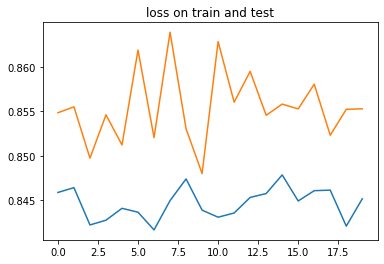

Last loss on train: 0.8451824776366749
Last loss on test: 0.8552876397183067


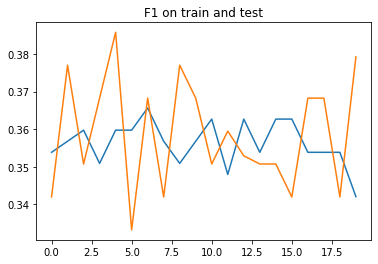

Last F1 on train: 0.34201891153259617
Last F1 on test: 0.37921414485103205


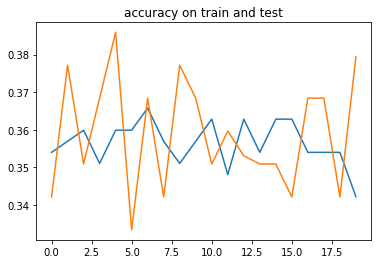

Last accuracy on train: 0.342182900657696
Last accuracy on test: 0.37938597406211655


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.987440315549097


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

Доля предложений с ДФ среди правильных 0.0
Количество предложений с ДФ среди правильных 0


# Experiment 5, testing Bi-directional 2 Cells

* LSTM
* bi
* 2 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = BiLSTM_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


47it [00:02, 20.31it/s]

Train loss: 0.8190225336286757


93it [00:05, 19.19it/s]

Train loss: 0.7371934519873725


139it [00:07, 22.54it/s]

Train loss: 0.7002144517721953


184it [00:09, 23.00it/s]

Train loss: 0.6772401150729921


226it [00:11, 20.45it/s]


Train loss: 0.6617176532745361

Evaluating on train...


50it [00:01, 43.24it/s]

Val loss: 0.5921741273668077, Val f1: 0.38208351135253904, Val accuracy: 0.8927068399058448


94it [00:02, 40.03it/s]

Val loss: 0.5933248599370321, Val f1: 0.3783240493800905, Val accuracy: 0.9100158936447568


139it [00:03, 37.30it/s]

Val loss: 0.5902777084597834, Val f1: 0.37661938269933065, Val accuracy: 0.9168329574443675


187it [00:04, 38.31it/s]

Val loss: 0.5905349353949229, Val f1: 0.3776180232564608, Val accuracy: 0.9154170138968362


226it [00:05, 38.59it/s]


Val loss: 0.5892435706986321, Val f1: 0.3771329058541192, Val accuracy: 0.912957833343082

Evaluating on test...


20it [00:00, 34.35it/s]

Val loss: 0.6337450782457987, Val f1: 0.37113046646118164, Val accuracy: 0.8393843591213226


37it [00:01, 36.78it/s]

Val loss: 0.6130812187989553, Val f1: 0.3748340904712677, Val accuracy: 0.8739809473355611


50it [00:01, 37.68it/s]

Val loss: 0.6171775738398234, Val f1: 0.3718908256954617, Val accuracy: 0.8703389710850186


65it [00:01, 39.82it/s]

Val loss: 0.6109613706668218, Val f1: 0.37329690853754677, Val accuracy: 0.8702629774808883


76it [00:02, 36.76it/s]


Val loss: 0.6130000964800517, Val f1: 0.3736258403460185, Val accuracy: 0.8688218903541565

starting Epoch 1
Training...


48it [00:02, 22.02it/s]

Train loss: 0.5991431487931146


93it [00:03, 24.56it/s]

Train loss: 0.5914886017640432


138it [00:05, 22.49it/s]

Train loss: 0.5847152489202994


183it [00:07, 23.40it/s]

Train loss: 0.5835168037149642


226it [00:09, 22.95it/s]


Train loss: 0.585533459716373

Evaluating on train...


48it [00:01, 40.43it/s]

Val loss: 0.5734559973080953, Val f1: 0.39465240505006577, Val accuracy: 0.931425811847051


93it [00:02, 40.56it/s]

Val loss: 0.5710642788145277, Val f1: 0.3908681141005622, Val accuracy: 0.9109202520714865


139it [00:03, 38.74it/s]

Val loss: 0.5727042886945937, Val f1: 0.39360852903789945, Val accuracy: 0.92264758988663


186it [00:04, 39.06it/s]

Val loss: 0.5730865607659023, Val f1: 0.39444530490371915, Val accuracy: 0.9324496780832608


226it [00:05, 39.58it/s]


Val loss: 0.572170832157135, Val f1: 0.3947879248195224, Val accuracy: 0.9347232949733734

Evaluating on test...


19it [00:00, 38.50it/s]

Val loss: 0.5821911454200744, Val f1: 0.396582023302714, Val accuracy: 0.9187098999818166


36it [00:00, 36.84it/s]

Val loss: 0.581354159116745, Val f1: 0.39638079206148785, Val accuracy: 0.9436928004026413


53it [00:01, 37.83it/s]

Val loss: 0.5821872433026631, Val f1: 0.39748390449417964, Val accuracy: 0.9338237391577826


65it [00:01, 35.64it/s]

Val loss: 0.5855822573105495, Val f1: 0.3920791576306025, Val accuracy: 0.9323938300212224


76it [00:02, 37.47it/s]


Val loss: 0.5896810936927795, Val f1: 0.388391432762146, Val accuracy: 0.9132794471581777

starting Epoch 2
Training...


48it [00:02, 22.66it/s]

Train loss: 0.5701992167366876


93it [00:04, 22.81it/s]

Train loss: 0.5726075073083242


138it [00:06, 23.72it/s]

Train loss: 0.5750807576709324


183it [00:08, 22.84it/s]

Train loss: 0.5751731120877795


226it [00:09, 22.62it/s]


Train loss: 0.5742903550465902

Evaluating on train...


50it [00:01, 41.51it/s]

Val loss: 0.5624552011489868, Val f1: 0.42078929675949944, Val accuracy: 0.9349302377965715


95it [00:02, 41.42it/s]

Val loss: 0.5633386737770505, Val f1: 0.4236188365353478, Val accuracy: 0.9248540398147371


140it [00:03, 39.63it/s]

Val loss: 0.5632798340585496, Val f1: 0.42475927207205033, Val accuracy: 0.9370333956347572


183it [00:04, 36.27it/s]

Val loss: 0.5645051439603169, Val f1: 0.42265315867132613, Val accuracy: 0.9472293865349558


226it [00:06, 35.24it/s]


Val loss: 0.565804922580719, Val f1: 0.42404481914308334, Val accuracy: 0.9525620310836368

Evaluating on test...


19it [00:00, 23.66it/s]

Val loss: 0.5800292015075683, Val f1: 0.4132404347260793, Val accuracy: 0.9562515417734782


35it [00:01, 32.45it/s]

Val loss: 0.5853013495604197, Val f1: 0.4103921075661977, Val accuracy: 0.9454400698343913


51it [00:01, 35.77it/s]

Val loss: 0.5881830188963149, Val f1: 0.41168110503090755, Val accuracy: 0.9168302483028836


67it [00:02, 35.05it/s]

Val loss: 0.5858595212300618, Val f1: 0.4109290207425753, Val accuracy: 0.9164400721589724


76it [00:02, 31.29it/s]


Val loss: 0.585344066619873, Val f1: 0.4126736549536387, Val accuracy: 0.9142230729262034

starting Epoch 3
Training...


47it [00:02, 21.44it/s]

Train loss: 0.5718158894115024


92it [00:04, 24.01it/s]

Train loss: 0.5683130946424272


137it [00:06, 22.34it/s]

Train loss: 0.5663182925294947


181it [00:08, 18.72it/s]

Train loss: 0.5659168829520543


226it [00:10, 20.86it/s]


Train loss: 0.5655083900027805

Evaluating on train...


52it [00:01, 36.74it/s]

Val loss: 0.5640105260743036, Val f1: 0.5033165925078922, Val accuracy: 0.9693954361809625


94it [00:02, 34.84it/s]

Val loss: 0.5652783817715115, Val f1: 0.5052764134274589, Val accuracy: 0.9577198247114818


141it [00:03, 40.26it/s]

Val loss: 0.5638579593764411, Val f1: 0.4969605361973798, Val accuracy: 0.9673392158967478


184it [00:04, 36.46it/s]

Val loss: 0.5627842717700534, Val f1: 0.5010012201137013, Val accuracy: 0.9689091599649853


226it [00:05, 38.17it/s]


Val loss: 0.561973135471344, Val f1: 0.5004828296767341, Val accuracy: 0.974046413368649

Evaluating on test...


20it [00:00, 40.09it/s]

Val loss: 0.5888908306757609, Val f1: 0.4626768370469411, Val accuracy: 0.8861359576384227


34it [00:00, 38.10it/s]

Val loss: 0.5955789466698964, Val f1: 0.4540122350056966, Val accuracy: 0.8899974793195724


52it [00:01, 37.41it/s]

Val loss: 0.5917797062132094, Val f1: 0.4609192629655202, Val accuracy: 0.8913994583818647


63it [00:01, 24.36it/s]

Val loss: 0.5912646720806758, Val f1: 0.4583584835131963, Val accuracy: 0.9022709146142006


76it [00:02, 33.28it/s]


Val loss: 0.5952753202120463, Val f1: 0.46028929710388183, Val accuracy: 0.9021927177906036

starting Epoch 4
Training...


46it [00:02, 17.18it/s]

Train loss: 0.5628604531288147


92it [00:05, 16.09it/s]

Train loss: 0.5642194549242655


137it [00:07, 22.01it/s]

Train loss: 0.5645811672563906


182it [00:09, 22.26it/s]

Train loss: 0.5630022105243471


226it [00:11, 19.31it/s]


Train loss: 0.5631748880280388

Evaluating on train...


49it [00:01, 40.84it/s]

Val loss: 0.5638555182351006, Val f1: 0.43552076551649305, Val accuracy: 0.9810969644122653


96it [00:02, 35.44it/s]

Val loss: 0.5631603916486104, Val f1: 0.4339004092746311, Val accuracy: 0.9641037725740009


140it [00:03, 38.84it/s]

Val loss: 0.564433154794905, Val f1: 0.43751396161538586, Val accuracy: 0.9607554956718728


186it [00:04, 35.89it/s]

Val loss: 0.5633804513348474, Val f1: 0.4424566861655977, Val accuracy: 0.965137446920077


226it [00:05, 38.76it/s]


Val loss: 0.5626679595311482, Val f1: 0.44323670546213784, Val accuracy: 0.9648199990060594

Evaluating on test...


23it [00:00, 39.76it/s]

Val loss: 0.5677332321802775, Val f1: 0.41578677694002786, Val accuracy: 0.9376531302928924


37it [00:00, 41.06it/s]

Val loss: 0.5762766480445862, Val f1: 0.4252231409152349, Val accuracy: 0.9434297253688176


51it [00:01, 36.63it/s]

Val loss: 0.580133236779107, Val f1: 0.4245341029432085, Val accuracy: 0.9107023821936713


63it [00:01, 34.10it/s]

Val loss: 0.5811043739318847, Val f1: 0.4199425811568896, Val accuracy: 0.9059939170877139


76it [00:02, 37.08it/s]


Val loss: 0.5825109299023946, Val f1: 0.41726787606875104, Val accuracy: 0.9136532851060232

starting Epoch 5
Training...


48it [00:03, 17.59it/s]

Train loss: 0.5587648749351501


94it [00:05, 20.39it/s]

Train loss: 0.5613032758235932


139it [00:07, 23.76it/s]

Train loss: 0.5634808743441546


182it [00:09, 18.85it/s]

Train loss: 0.5630486057864295


226it [00:12, 18.55it/s]


Train loss: 0.5619183484713236

Evaluating on train...


49it [00:02, 25.21it/s]

Val loss: 0.5554798430866665, Val f1: 0.4763040522734324, Val accuracy: 0.9388981428411272


92it [00:03, 24.76it/s]

Val loss: 0.5564320935143365, Val f1: 0.49272438188393913, Val accuracy: 0.9374534795681636


138it [00:05, 22.99it/s]

Val loss: 0.5570758333912602, Val f1: 0.4963052820276331, Val accuracy: 0.9461972146122544


183it [00:07, 21.87it/s]

Val loss: 0.5572791433996624, Val f1: 0.5024558484554291, Val accuracy: 0.9506560509403547


226it [00:09, 23.77it/s]


Val loss: 0.5579765682750278, Val f1: 0.5032123833232456, Val accuracy: 0.9498850639661153

Evaluating on test...


20it [00:00, 34.19it/s]

Val loss: 0.5801037073135376, Val f1: 0.4484659989674886, Val accuracy: 0.9398748437563579


36it [00:01, 36.04it/s]

Val loss: 0.5792895078659057, Val f1: 0.4613112936417262, Val accuracy: 0.9480401714642842


52it [00:01, 36.20it/s]

Val loss: 0.5805790768729315, Val f1: 0.45409460398885937, Val accuracy: 0.9316553738382127


64it [00:01, 36.21it/s]

Val loss: 0.5823811491330465, Val f1: 0.4501656353473663, Val accuracy: 0.9095254977544148


76it [00:02, 35.86it/s]


Val loss: 0.5847242601712545, Val f1: 0.45321999669075014, Val accuracy: 0.9128091208140056

starting Epoch 6
Training...


50it [00:02, 23.02it/s]

Train loss: 0.5591506958007812


92it [00:04, 21.65it/s]

Train loss: 0.5580996870994568


137it [00:06, 23.42it/s]

Train loss: 0.55761313924083


182it [00:08, 22.14it/s]

Train loss: 0.5583757231632869


226it [00:10, 21.43it/s]


Train loss: 0.5582938424746196

Evaluating on train...


48it [00:01, 26.85it/s]

Val loss: 0.559981984562344, Val f1: 0.5503529138035245, Val accuracy: 0.9476680417855581


95it [00:03, 27.59it/s]

Val loss: 0.5570467392603556, Val f1: 0.5593107455306583, Val accuracy: 0.958437654044893


140it [00:05, 25.06it/s]

Val loss: 0.5573435712743688, Val f1: 0.5547555972028662, Val accuracy: 0.9591811943937231


182it [00:07, 22.77it/s]

Val loss: 0.5576516426271863, Val f1: 0.5550083746512731, Val accuracy: 0.9589248400595453


226it [00:08, 25.16it/s]


Val loss: 0.5571035740110609, Val f1: 0.5534922991858588, Val accuracy: 0.9577020537853241

Evaluating on test...


17it [00:00, 38.73it/s]

Val loss: 0.565398347377777, Val f1: 0.46781643231709796, Val accuracy: 0.8847626944382986


32it [00:01, 27.25it/s]

Val loss: 0.576120529572169, Val f1: 0.4901772360006968, Val accuracy: 0.8822391917308171


47it [00:01, 24.45it/s]

Val loss: 0.5771567000283135, Val f1: 0.4847159604231516, Val accuracy: 0.8747527142365773


62it [00:02, 24.22it/s]

Val loss: 0.5857156664133072, Val f1: 0.48369064380725224, Val accuracy: 0.8657399465640386


76it [00:02, 26.62it/s]


Val loss: 0.5882946681976319, Val f1: 0.48918286283810936, Val accuracy: 0.8753716929753621

starting Epoch 7
Training...


46it [00:02, 18.67it/s]

Train loss: 0.5588679141468472


92it [00:04, 20.34it/s]

Train loss: 0.5609386788474189


137it [00:06, 22.04it/s]

Train loss: 0.5591307617999889


182it [00:08, 21.73it/s]

Train loss: 0.5583650271097819


226it [00:10, 20.61it/s]


Train loss: 0.558487295044793

Evaluating on train...


49it [00:01, 37.42it/s]

Val loss: 0.555052916208903, Val f1: 0.5728844841321309, Val accuracy: 0.967903134557936


97it [00:02, 40.81it/s]

Val loss: 0.5563197778330908, Val f1: 0.5711171279350916, Val accuracy: 0.9581257498926586


140it [00:03, 34.66it/s]

Val loss: 0.5570779433956853, Val f1: 0.5631872280880257, Val accuracy: 0.9593441327412923


185it [00:04, 39.24it/s]

Val loss: 0.5565788596868515, Val f1: 0.5609823821319474, Val accuracy: 0.9574596524238587


226it [00:05, 38.73it/s]


Val loss: 0.5566483452585008, Val f1: 0.555969839890798, Val accuracy: 0.956167952881919

Evaluating on test...


20it [00:00, 40.40it/s]

Val loss: 0.5680413206418355, Val f1: 0.4780592163403829, Val accuracy: 0.9313931783040365


37it [00:00, 37.20it/s]

Val loss: 0.5764419615268708, Val f1: 0.4820238023996353, Val accuracy: 0.9437424977620442


51it [00:01, 39.93it/s]

Val loss: 0.5824679811795552, Val f1: 0.4856670359770457, Val accuracy: 0.9220042341285282


67it [00:01, 36.43it/s]

Val loss: 0.5818328549464543, Val f1: 0.48289882043997445, Val accuracy: 0.9281755402684212


76it [00:02, 37.65it/s]


Val loss: 0.5859708499908447, Val f1: 0.48448681553204853, Val accuracy: 0.9269373206297556

starting Epoch 8
Training...


47it [00:02, 22.75it/s]

Train loss: 0.561486828327179


92it [00:04, 20.77it/s]

Train loss: 0.5601026687357161


137it [00:06, 22.70it/s]

Train loss: 0.5588207633407027


182it [00:08, 20.80it/s]

Train loss: 0.558705167637931


226it [00:10, 21.97it/s]


Train loss: 0.5581062984466553

Evaluating on train...


53it [00:01, 42.35it/s]

Val loss: 0.5537715646955702, Val f1: 0.5760005374749502, Val accuracy: 0.9841941303677029


96it [00:02, 40.67it/s]

Val loss: 0.5552570720513662, Val f1: 0.5685849146710502, Val accuracy: 0.957966716753112


142it [00:03, 38.09it/s]

Val loss: 0.5565620925691392, Val f1: 0.5742194990317027, Val accuracy: 0.9518902215692732


186it [00:04, 41.19it/s]

Val loss: 0.5562726848655277, Val f1: 0.5756010858549012, Val accuracy: 0.9482608455750677


226it [00:05, 40.06it/s]


Val loss: 0.5557635095384386, Val f1: 0.582581379810969, Val accuracy: 0.9583117764525944

Evaluating on test...


23it [00:00, 40.19it/s]

Val loss: 0.6022451917330424, Val f1: 0.5260070502758026, Val accuracy: 0.8953198432922364


36it [00:00, 38.19it/s]

Val loss: 0.5963645180066427, Val f1: 0.5049045870701472, Val accuracy: 0.8567677021026612


53it [00:01, 39.14it/s]

Val loss: 0.5932243254449633, Val f1: 0.5070371097988553, Val accuracy: 0.8674820952945286


67it [00:01, 39.91it/s]

Val loss: 0.5917456656694412, Val f1: 0.500421479344368, Val accuracy: 0.8647123421231906


76it [00:01, 39.40it/s]


Val loss: 0.5895728754997254, Val f1: 0.5058664858341217, Val accuracy: 0.8829102424780527

starting Epoch 9
Training...


47it [00:02, 22.65it/s]

Train loss: 0.5562782684961954


92it [00:04, 22.27it/s]

Train loss: 0.5574080248673757


137it [00:06, 21.19it/s]

Train loss: 0.5564024134918496


182it [00:08, 21.47it/s]

Train loss: 0.5561569068166945


226it [00:10, 21.95it/s]


Train loss: 0.5565532482994927

Evaluating on train...


52it [00:01, 37.09it/s]

Val loss: 0.5617500755521986, Val f1: 0.5433148960272471, Val accuracy: 0.9570307268036736


96it [00:02, 38.29it/s]

Val loss: 0.5580443269676633, Val f1: 0.5491683410273658, Val accuracy: 0.9556350962983238


140it [00:03, 38.38it/s]

Val loss: 0.5567572077115377, Val f1: 0.5483145998583899, Val accuracy: 0.9601354601206603


186it [00:04, 38.90it/s]

Val loss: 0.5572027266025543, Val f1: 0.5457458269264963, Val accuracy: 0.9573324771391021


226it [00:05, 38.66it/s]


Val loss: 0.556637699868944, Val f1: 0.5434339422649808, Val accuracy: 0.9567220037513309

Evaluating on test...


21it [00:00, 38.76it/s]

Val loss: 0.5868698477745056, Val f1: 0.47288336157798766, Val accuracy: 0.8686853011449178


34it [00:00, 38.98it/s]

Val loss: 0.5954169531663259, Val f1: 0.4822264115015666, Val accuracy: 0.891105963786443


51it [00:01, 36.92it/s]

Val loss: 0.5898144642512003, Val f1: 0.48017452160517377, Val accuracy: 0.9112929039531283


67it [00:01, 37.92it/s]

Val loss: 0.591732328136762, Val f1: 0.4762288143237432, Val accuracy: 0.9044201259811719


76it [00:02, 37.36it/s]


Val loss: 0.5900877944628398, Val f1: 0.4755145112673442, Val accuracy: 0.9016354640324911

starting Epoch 10
Training...


47it [00:02, 21.03it/s]

Train loss: 0.555083786116706


92it [00:04, 22.51it/s]

Train loss: 0.5571895347701179


137it [00:06, 19.55it/s]

Train loss: 0.5568987095797503


183it [00:08, 22.73it/s]

Train loss: 0.5568516155083975


226it [00:10, 21.17it/s]


Train loss: 0.557541548675961

Evaluating on train...


50it [00:01, 40.68it/s]

Val loss: 0.5538742462793986, Val f1: 0.5775303767787086, Val accuracy: 0.9544325662983788


95it [00:02, 40.98it/s]

Val loss: 0.5539093706342909, Val f1: 0.566361669699351, Val accuracy: 0.9766447249386045


141it [00:03, 34.38it/s]

Val loss: 0.5544488862708763, Val f1: 0.5677645219696893, Val accuracy: 0.9782965395185682


183it [00:04, 37.96it/s]

Val loss: 0.555061493648423, Val f1: 0.5631893381476403, Val accuracy: 0.9637917068269518


226it [00:05, 38.37it/s]


Val loss: 0.5552470702595181, Val f1: 0.5639738704098596, Val accuracy: 0.9668776622083453

Evaluating on test...


20it [00:00, 37.12it/s]

Val loss: 0.5833964784940083, Val f1: 0.47106760541598003, Val accuracy: 0.8872186044851939


36it [00:00, 38.46it/s]

Val loss: 0.583479638894399, Val f1: 0.46697433590888976, Val accuracy: 0.9027527262767155


52it [00:01, 36.36it/s]

Val loss: 0.5844999776946174, Val f1: 0.47254166470633613, Val accuracy: 0.8936748180124495


64it [00:01, 37.25it/s]

Val loss: 0.5837289681037267, Val f1: 0.4762013653914134, Val accuracy: 0.8859948029120763


76it [00:02, 37.01it/s]


Val loss: 0.5855295729637146, Val f1: 0.48153024474779765, Val accuracy: 0.8967450261116028

starting Epoch 11
Training...


48it [00:02, 21.98it/s]

Train loss: 0.5571075942781236


93it [00:04, 21.56it/s]

Train loss: 0.5585307081540426


138it [00:06, 22.06it/s]

Train loss: 0.5572422182118452


183it [00:08, 21.15it/s]

Train loss: 0.5568149897787306


226it [00:10, 21.99it/s]


Train loss: 0.5568299158414205

Evaluating on train...


51it [00:01, 36.69it/s]

Val loss: 0.5549982984860738, Val f1: 0.5690821230411529, Val accuracy: 0.966565896405114


94it [00:02, 37.91it/s]

Val loss: 0.5542985743946499, Val f1: 0.5825469381279416, Val accuracy: 0.9679901527033912


140it [00:03, 36.27it/s]

Val loss: 0.5549525993841665, Val f1: 0.5861930984037894, Val accuracy: 0.9676316793318148


184it [00:04, 35.24it/s]

Val loss: 0.5554175744454066, Val f1: 0.579498269657294, Val accuracy: 0.9632422020037968


226it [00:06, 37.00it/s]


Val loss: 0.5553035714891221, Val f1: 0.5782416542371114, Val accuracy: 0.9643177057637109

Evaluating on test...


21it [00:00, 37.48it/s]

Val loss: 0.5812549948692322, Val f1: 0.49710424145062765, Val accuracy: 0.8936948855717977


37it [00:00, 37.39it/s]

Val loss: 0.5876146793365479, Val f1: 0.4856677840153376, Val accuracy: 0.8621171683073043


49it [00:01, 37.92it/s]

Val loss: 0.5849841117858887, Val f1: 0.48353744943936666, Val accuracy: 0.8936605698532528


65it [00:01, 35.65it/s]

Val loss: 0.5840550432602565, Val f1: 0.477115420003732, Val accuracy: 0.901525755226612


76it [00:02, 37.02it/s]


Val loss: 0.5889987428983052, Val f1: 0.4836362628142039, Val accuracy: 0.9039926159381867

starting Epoch 12
Training...


48it [00:02, 21.17it/s]

Train loss: 0.5559902085198296


93it [00:04, 22.00it/s]

Train loss: 0.5554770860407088


135it [00:06, 21.08it/s]

Train loss: 0.5553657677438524


183it [00:08, 21.82it/s]

Train loss: 0.5559654255708059


226it [00:10, 21.25it/s]


Train loss: 0.5565495732095507

Evaluating on train...


49it [00:01, 40.09it/s]

Val loss: 0.5592064049508837, Val f1: 0.5824987365139855, Val accuracy: 0.9466970092720456


94it [00:02, 33.70it/s]

Val loss: 0.5562688555982378, Val f1: 0.5957137174076504, Val accuracy: 0.950666277938419


138it [00:03, 33.94it/s]

Val loss: 0.5553547510394343, Val f1: 0.5947251920346861, Val accuracy: 0.9667844895963316


185it [00:05, 38.05it/s]

Val loss: 0.5550512833727731, Val f1: 0.591103567679723, Val accuracy: 0.9634387210011482


226it [00:06, 36.48it/s]


Val loss: 0.5553053368462456, Val f1: 0.5902952149179247, Val accuracy: 0.9667169540458256

Evaluating on test...


21it [00:00, 38.46it/s]

Val loss: 0.6005062500635783, Val f1: 0.47190231482187905, Val accuracy: 0.8245911161104839


34it [00:00, 37.37it/s]

Val loss: 0.5946649293104808, Val f1: 0.48914374113082887, Val accuracy: 0.8715396682421367


50it [00:01, 37.49it/s]

Val loss: 0.5908403052224054, Val f1: 0.49329397479693093, Val accuracy: 0.8826911634869046


67it [00:01, 38.40it/s]

Val loss: 0.586155641078949, Val f1: 0.49751367966334026, Val accuracy: 0.9020651161670685


76it [00:02, 37.60it/s]


Val loss: 0.5848477673530579, Val f1: 0.5024236754576366, Val accuracy: 0.9086204441388448

starting Epoch 13
Training...


49it [00:02, 21.61it/s]

Train loss: 0.553878664970398


94it [00:04, 23.44it/s]

Train loss: 0.5567887524763743


136it [00:06, 19.70it/s]

Train loss: 0.5582067604418154


183it [00:08, 21.70it/s]

Train loss: 0.5569629725482729


226it [00:10, 21.73it/s]


Train loss: 0.5565276339319017

Evaluating on train...


50it [00:01, 37.24it/s]

Val loss: 0.5536143845982022, Val f1: 0.6224536458651225, Val accuracy: 0.9807406438721551


95it [00:02, 36.47it/s]

Val loss: 0.5544095330768162, Val f1: 0.6229372945096757, Val accuracy: 0.9814340846406089


140it [00:03, 32.90it/s]

Val loss: 0.5554084852889732, Val f1: 0.6299278537432352, Val accuracy: 0.9757262587547302


185it [00:04, 35.05it/s]

Val loss: 0.5555294642845789, Val f1: 0.6377512549360593, Val accuracy: 0.9804729749759038


226it [00:06, 36.95it/s]


Val loss: 0.5550782317585415, Val f1: 0.6288342920939127, Val accuracy: 0.9753372181786432

Evaluating on test...


20it [00:00, 37.01it/s]

Val loss: 0.6071736931800842, Val f1: 0.4999019662539164, Val accuracy: 0.8054648200670879


36it [00:00, 37.92it/s]

Val loss: 0.5893259823322297, Val f1: 0.5321301947037379, Val accuracy: 0.8593981802463532


52it [00:01, 36.06it/s]

Val loss: 0.5856031748983596, Val f1: 0.5414004352357652, Val accuracy: 0.8783148937755161


64it [00:01, 34.85it/s]

Val loss: 0.5889840930700302, Val f1: 0.5364346931378047, Val accuracy: 0.878778275847435


76it [00:02, 36.46it/s]


Val loss: 0.5896374050776164, Val f1: 0.5325608909130096, Val accuracy: 0.8774713540077209

starting Epoch 14
Training...


48it [00:02, 20.70it/s]

Train loss: 0.5541797134611341


93it [00:04, 21.99it/s]

Train loss: 0.5559141483571794


138it [00:06, 22.03it/s]

Train loss: 0.5556940975012603


183it [00:08, 21.86it/s]

Train loss: 0.5565872980488671


226it [00:10, 21.49it/s]


Train loss: 0.5568181043201023

Evaluating on train...


50it [00:01, 38.38it/s]

Val loss: 0.5571950369411045, Val f1: 0.5917643792099423, Val accuracy: 0.9694166580835978


96it [00:02, 37.18it/s]

Val loss: 0.5578402751021915, Val f1: 0.5939711468087302, Val accuracy: 0.9752884599897597


141it [00:03, 33.89it/s]

Val loss: 0.5567585243119134, Val f1: 0.5985278776398412, Val accuracy: 0.9826988335008975


185it [00:05, 35.88it/s]

Val loss: 0.5559980101055569, Val f1: 0.5919270480672518, Val accuracy: 0.9830770860115687


226it [00:06, 35.62it/s]


Val loss: 0.5559802770614624, Val f1: 0.5894227296776242, Val accuracy: 0.982062107457055

Evaluating on test...


20it [00:00, 36.94it/s]

Val loss: 0.5567405581474304, Val f1: 0.47792075872421264, Val accuracy: 0.9500101029872894


36it [00:00, 36.99it/s]

Val loss: 0.5692768573760987, Val f1: 0.49277359048525493, Val accuracy: 0.927104585369428


48it [00:01, 36.21it/s]

Val loss: 0.5813663919766744, Val f1: 0.47634717557165357, Val accuracy: 0.9206260118219588


65it [00:01, 37.93it/s]

Val loss: 0.5796795527140299, Val f1: 0.47907501508792244, Val accuracy: 0.9287130271395048


76it [00:02, 37.20it/s]


Val loss: 0.5862931982676188, Val f1: 0.47710277477900187, Val accuracy: 0.9257571065425872

starting Epoch 15
Training...


48it [00:02, 21.97it/s]

Train loss: 0.5530341532495286


93it [00:04, 21.75it/s]

Train loss: 0.5554111659526825


138it [00:06, 21.90it/s]

Train loss: 0.5576071999691151


183it [00:08, 21.23it/s]

Train loss: 0.5568507052130169


226it [00:10, 21.94it/s]


Train loss: 0.5573994008700053

Evaluating on train...


53it [00:01, 40.41it/s]

Val loss: 0.5534663319587707, Val f1: 0.5873366435368855, Val accuracy: 0.9397940814495087


98it [00:02, 41.05it/s]

Val loss: 0.5543911457061768, Val f1: 0.594853264093399, Val accuracy: 0.9607225312127008


140it [00:03, 35.01it/s]

Val loss: 0.5561214795819035, Val f1: 0.596852445602417, Val accuracy: 0.9558841360939874


185it [00:04, 33.17it/s]

Val loss: 0.5560477240218057, Val f1: 0.5965388173858325, Val accuracy: 0.9577334086100261


226it [00:05, 38.20it/s]


Val loss: 0.5555623213450114, Val f1: 0.5897174314657847, Val accuracy: 0.9541380315356784

Evaluating on test...


20it [00:00, 36.58it/s]

Val loss: 0.6053231477737426, Val f1: 0.49321759343147276, Val accuracy: 0.8911447842915853


37it [00:01, 37.78it/s]

Val loss: 0.5854730347792307, Val f1: 0.47353932658831277, Val accuracy: 0.881920192639033


50it [00:01, 38.06it/s]

Val loss: 0.5795218348503113, Val f1: 0.48236752019988166, Val accuracy: 0.9112806518872579


67it [00:01, 36.73it/s]

Val loss: 0.5879160175720851, Val f1: 0.48081251432498295, Val accuracy: 0.8757062236467997


76it [00:02, 36.75it/s]


Val loss: 0.5848235360781352, Val f1: 0.4867005181312561, Val accuracy: 0.8844131215413411

starting Epoch 16
Training...


47it [00:02, 21.40it/s]

Train loss: 0.5553259505165948


92it [00:04, 22.59it/s]

Train loss: 0.5558697634273105


137it [00:06, 21.45it/s]

Train loss: 0.5554912999824241


184it [00:08, 21.21it/s]

Train loss: 0.5547561003102197


226it [00:10, 21.15it/s]


Train loss: 0.5557481037245856

Evaluating on train...


50it [00:01, 38.66it/s]

Val loss: 0.5546821342574225, Val f1: 0.6588828457726372, Val accuracy: 0.9778189619382223


96it [00:02, 37.01it/s]

Val loss: 0.5573830544948578, Val f1: 0.6510385168923272, Val accuracy: 0.9817885610792372


139it [00:03, 35.01it/s]

Val loss: 0.5580342403164616, Val f1: 0.659541869605029, Val accuracy: 0.9846502701441447


187it [00:05, 35.73it/s]

Val loss: 0.5577438904179467, Val f1: 0.6536634546187189, Val accuracy: 0.9754604950547219


226it [00:06, 37.34it/s]


Val loss: 0.557751669883728, Val f1: 0.6490940271483527, Val accuracy: 0.9695781507756975

Evaluating on test...


21it [00:00, 39.03it/s]

Val loss: 0.6190598607063293, Val f1: 0.5186339100201924, Val accuracy: 0.8829176704088847


34it [00:00, 38.93it/s]

Val loss: 0.6042722086111705, Val f1: 0.5118813614050547, Val accuracy: 0.8837519129117329


51it [00:01, 38.46it/s]

Val loss: 0.5999946342574225, Val f1: 0.5140441278616588, Val accuracy: 0.8944580409261915


67it [00:01, 38.02it/s]

Val loss: 0.5961213032404582, Val f1: 0.5049963379899661, Val accuracy: 0.873016490538915


76it [00:01, 38.68it/s]


Val loss: 0.5962697211901347, Val f1: 0.5117762899398803, Val accuracy: 0.8806031195322672

starting Epoch 17
Training...


48it [00:02, 21.33it/s]

Train loss: 0.5582821700308058


91it [00:04, 20.60it/s]

Train loss: 0.5568091730276744


139it [00:06, 22.13it/s]

Train loss: 0.556368351424182


184it [00:08, 22.27it/s]

Train loss: 0.556116063064999


226it [00:10, 21.54it/s]


Train loss: 0.5562372922897338

Evaluating on train...


50it [00:01, 40.65it/s]

Val loss: 0.5581714378462898, Val f1: 0.6616356247001224, Val accuracy: 0.9632545775837369


97it [00:02, 35.59it/s]

Val loss: 0.5560102264086405, Val f1: 0.6581801566812727, Val accuracy: 0.9661597496933407


142it [00:03, 37.38it/s]

Val loss: 0.5551181545963993, Val f1: 0.6637979006325757, Val accuracy: 0.9665581663449605


187it [00:04, 38.72it/s]

Val loss: 0.5551983777019712, Val f1: 0.6546302093399896, Val accuracy: 0.9664305279652278


226it [00:05, 38.76it/s]


Val loss: 0.5549169148339166, Val f1: 0.6594643743832906, Val accuracy: 0.9666558072302076

Evaluating on test...


20it [00:00, 38.17it/s]

Val loss: 0.5686559637387594, Val f1: 0.5655773003896077, Val accuracy: 0.8769263704617818


38it [00:00, 39.69it/s]

Val loss: 0.5742311259110768, Val f1: 0.5531473010778427, Val accuracy: 0.918397867679596


53it [00:01, 40.03it/s]

Val loss: 0.5926015721427069, Val f1: 0.5370050562752617, Val accuracy: 0.9006807102097405


67it [00:01, 39.02it/s]

Val loss: 0.5914958278338115, Val f1: 0.5304638564586639, Val accuracy: 0.8932210355997086


76it [00:01, 39.02it/s]


Val loss: 0.5875640042622884, Val f1: 0.5255647401014963, Val accuracy: 0.9083434653282165

starting Epoch 18
Training...


47it [00:02, 22.34it/s]

Train loss: 0.5550581773122152


92it [00:04, 22.25it/s]

Train loss: 0.5541912092102899


137it [00:06, 22.81it/s]

Train loss: 0.5549940652317471


182it [00:08, 20.74it/s]

Train loss: 0.5550627281268438


226it [00:10, 21.02it/s]


Train loss: 0.5558042894469367

Evaluating on train...


49it [00:01, 37.31it/s]

Val loss: 0.5599379512998793, Val f1: 0.6350530140929752, Val accuracy: 0.9772751165760888


94it [00:02, 39.94it/s]

Val loss: 0.5575687083933089, Val f1: 0.6093086981111102, Val accuracy: 0.9723092691765891


141it [00:03, 38.54it/s]

Val loss: 0.55653364305143, Val f1: 0.6047620643068243, Val accuracy: 0.9639883904545395


188it [00:04, 40.41it/s]

Val loss: 0.5558526111973656, Val f1: 0.5964234095480707, Val accuracy: 0.961284637120035


226it [00:05, 39.09it/s]


Val loss: 0.5556016654438443, Val f1: 0.5966115363438924, Val accuracy: 0.9651424249013265

Evaluating on test...


21it [00:00, 38.67it/s]

Val loss: 0.5813064773877462, Val f1: 0.5031338791052501, Val accuracy: 0.9487309773763021


34it [00:00, 39.26it/s]

Val loss: 0.5885563373565674, Val f1: 0.5143397331237793, Val accuracy: 0.9400483032067617


50it [00:01, 37.85it/s]

Val loss: 0.595921766757965, Val f1: 0.5120787620544434, Val accuracy: 0.9266572409205966


67it [00:01, 39.12it/s]

Val loss: 0.5940633167823156, Val f1: 0.5064113537470499, Val accuracy: 0.9167151952783267


76it [00:01, 38.88it/s]


Val loss: 0.5900831039746602, Val f1: 0.504559709628423, Val accuracy: 0.9085494689146678

starting Epoch 19
Training...


47it [00:02, 21.34it/s]

Train loss: 0.5566236707899306


92it [00:04, 22.84it/s]

Train loss: 0.5551851544115278


137it [00:06, 22.85it/s]

Train loss: 0.555826997756958


182it [00:08, 22.09it/s]

Train loss: 0.5561314404010773


226it [00:10, 21.86it/s]


Train loss: 0.5558643126487732

Evaluating on train...


51it [00:01, 39.86it/s]

Val loss: 0.5550333102544148, Val f1: 0.653171040614446, Val accuracy: 0.9648875481552548


97it [00:02, 36.54it/s]

Val loss: 0.5540065838230981, Val f1: 0.6447757962677214, Val accuracy: 0.9672581159406238


139it [00:03, 38.42it/s]

Val loss: 0.5546531072369328, Val f1: 0.6400970364058459, Val accuracy: 0.9653457489278582


186it [00:04, 38.35it/s]

Val loss: 0.5551613257990943, Val f1: 0.6309502651294072, Val accuracy: 0.9520612367325358


226it [00:05, 38.07it/s]


Val loss: 0.5547503966755337, Val f1: 0.6305210304260254, Val accuracy: 0.9555680819352468

Evaluating on test...


21it [00:00, 37.96it/s]

Val loss: 0.5965519666671752, Val f1: 0.5253228604793548, Val accuracy: 0.9176289478937785


34it [00:00, 38.59it/s]

Val loss: 0.5999330063660939, Val f1: 0.49621234138806664, Val accuracy: 0.8598556260267893


50it [00:01, 38.15it/s]

Val loss: 0.5993593917952643, Val f1: 0.49956190122498406, Val accuracy: 0.8654655045933194


66it [00:01, 37.79it/s]

Val loss: 0.5958874175945917, Val f1: 0.4984372898936272, Val accuracy: 0.8852319439252218


76it [00:01, 38.22it/s]

Val loss: 0.5914492519696554, Val f1: 0.5011705680688222, Val accuracy: 0.8843466548124949


## Graphics

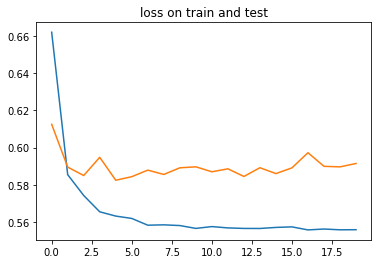

Last loss on train: 0.5558532344556488
Last loss on test: 0.5914310263959985


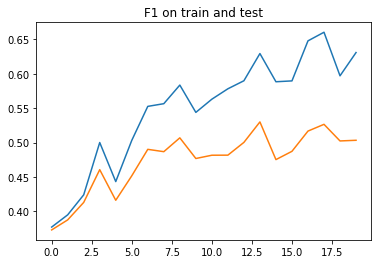

Last F1 on train: 0.6307038142617825
Last F1 on test: 0.5032610238382691


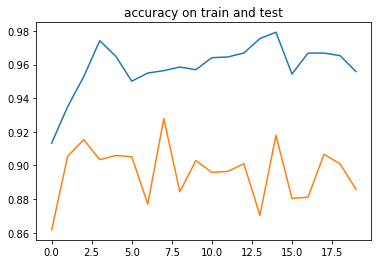

Last accuracy on train: 0.9557599603338579
Last accuracy on test: 0.8857979315676188


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.9116670126634835


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

--O dann-O ist-O sie-O eben-O 'ne-O frau-O ,-O na-B und-I ?-O
--O du-O kannst-O mich-O verstehen-O ,-O nicht-B wahr-I ?-O
ja-O ,-O ich-B glaube-I schon-I .-O
--O das-B geht-I nicht-I .-O
--O ach-B ja-I ?-O
weiß-B ich-I nicht-I .-O
--O ganz-B und-I gar-I nicht-I .-O
was-B sie-I nicht-I sagen-I .-O
--O ich-B weiß-I .-O
nicht-B wahr-I ?-O
ich-B weiß-I .-O
--O ist-B schon-I gut-I .-O
wenn-O uns-O ein-O abwehrmechanismus-O durch-O schlechte-O zeiten-O hilft-O ,-O na-B und-I ?-O
ganz-B und-I gar-I nicht-I .-O
hör-B auf-I !-O
--O klasse-O --O ich-B weiß-I .-O
--O nicht-B wirklich-I .-O
--O elvira-O ,-O ich-O hab-O ...-O --O ich-B verstehe-I ja-I .-O
tja-O ,-O keine-B ahnung-I .-O
--O keine-B ahnung-I .-O
na-B gut-I ,-O äh-O ,-O wir-O sehen-O uns-O dann-O nachher-O .-O
ja-O ,-O ich-B verstehe-I .-O
dein-B ernst-I ?-O
ich-B glaube-I schon-I .-O
na-B gut-I ,-O kommt-O ,-O 2-O gegen-O einen-O .-O
ich-O brauch-O keine-O ,-O stimmt-B 's-I ?-O
--O ich-B bin-I dabei-I .-O
--O ich-O werde-O ...-O --O 

# Experiment 6, testing Bi-directional 2 Cells + embeddings
* LSTM
* bi
* 2 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation
* embeddings

## Training

In [ ]:
model = BiLSTM_2Cells_Embs(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, weights=weights, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


48it [00:02, 22.79it/s]

Train loss: 0.839383335908254


93it [00:04, 20.69it/s]

Train loss: 0.8312090913454692


138it [00:06, 19.51it/s]

Train loss: 0.8071905537887856


183it [00:08, 19.62it/s]

Train loss: 0.7776735961437226


226it [00:11, 20.15it/s]


Train loss: 0.743040402730306

Evaluating on train...


48it [00:01, 42.05it/s]

Val loss: 0.5897007836235895, Val f1: 0.35754475527339513, Val accuracy: 0.936227003733317


98it [00:02, 42.20it/s]

Val loss: 0.590736816989051, Val f1: 0.35889015793800355, Val accuracy: 0.9333495630158318


137it [00:03, 28.84it/s]

Val loss: 0.5897138304180569, Val f1: 0.35840458340115017, Val accuracy: 0.9359050936169094


183it [00:05, 24.08it/s]

Val loss: 0.5916310158040788, Val f1: 0.3590648939212163, Val accuracy: 0.9331005649434195


226it [00:07, 31.11it/s]


Val loss: 0.5909868542353313, Val f1: 0.3594156363275316, Val accuracy: 0.9325330936908722

Evaluating on test...


18it [00:00, 24.57it/s]

Val loss: 0.601025132338206, Val f1: 0.3681396802266439, Val accuracy: 0.9478136976559957


33it [00:01, 23.20it/s]

Val loss: 0.6088523944218953, Val f1: 0.3616819351911545, Val accuracy: 0.9237171630064647


48it [00:02, 23.92it/s]

Val loss: 0.612942726082272, Val f1: 0.36200707687271966, Val accuracy: 0.9147755715582105


66it [00:02, 29.74it/s]

Val loss: 0.6059696515401204, Val f1: 0.3617026006182035, Val accuracy: 0.9291800032059352


76it [00:02, 26.20it/s]


Val loss: 0.603297986984253, Val f1: 0.3588667698701223, Val accuracy: 0.9174802406628927

starting Epoch 1
Training...


48it [00:02, 20.05it/s]

Train loss: 0.5860375550058153


95it [00:04, 24.47it/s]

Train loss: 0.5837719440460205


137it [00:06, 24.42it/s]

Train loss: 0.5880788935555352


182it [00:08, 24.29it/s]

Train loss: 0.5850032567977905


226it [00:10, 22.33it/s]


Train loss: 0.5846682861116197

Evaluating on train...


49it [00:01, 31.13it/s]

Val loss: 0.5668279422654046, Val f1: 0.39995941188600326, Val accuracy: 0.9375674406687419


92it [00:03, 21.62it/s]

Val loss: 0.5694591071870592, Val f1: 0.4030528124835756, Val accuracy: 0.9374061170551512


137it [00:05, 20.86it/s]

Val loss: 0.5711417423354255, Val f1: 0.4074613065631301, Val accuracy: 0.9386400860768778


186it [00:07, 31.02it/s]

Val loss: 0.5710160583257675, Val f1: 0.40667221976651086, Val accuracy: 0.9342954370710584


226it [00:09, 25.03it/s]


Val loss: 0.5697091801961263, Val f1: 0.40836123943328856, Val accuracy: 0.9368075782722897

Evaluating on test...


18it [00:00, 23.29it/s]

Val loss: 0.6018717368443807, Val f1: 0.38065181573232015, Val accuracy: 0.8582811713218689


33it [00:01, 23.52it/s]

Val loss: 0.5896479785442352, Val f1: 0.3930846989154816, Val accuracy: 0.9131174862384797


48it [00:02, 20.59it/s]

Val loss: 0.593656063079834, Val f1: 0.3968351787990994, Val accuracy: 0.9080493754810757


63it [00:02, 20.21it/s]

Val loss: 0.5908852348725001, Val f1: 0.3977811510364215, Val accuracy: 0.9206697642803192


76it [00:03, 21.45it/s]


Val loss: 0.5925180610020956, Val f1: 0.39893417914708457, Val accuracy: 0.919180359840393

starting Epoch 2
Training...


50it [00:02, 23.15it/s]

Train loss: 0.5704338643285963


92it [00:04, 22.80it/s]

Train loss: 0.5701158669259813


137it [00:06, 23.35it/s]

Train loss: 0.5720237418457313


185it [00:08, 23.67it/s]

Train loss: 0.5695703466733296


226it [00:10, 21.77it/s]


Train loss: 0.5717459151479933

Evaluating on train...


49it [00:01, 39.66it/s]

Val loss: 0.5638885882165697, Val f1: 0.4282761686378055, Val accuracy: 0.9729417072402107


94it [00:02, 38.73it/s]

Val loss: 0.569447539250056, Val f1: 0.4250022441148758, Val accuracy: 0.96514982216888


142it [00:03, 40.47it/s]

Val loss: 0.5664595475903264, Val f1: 0.42433145377371045, Val accuracy: 0.9602123412821028


187it [00:04, 39.59it/s]

Val loss: 0.565851284066836, Val f1: 0.4252611916926172, Val accuracy: 0.9678503902422058


226it [00:05, 40.14it/s]


Val loss: 0.5658294664488899, Val f1: 0.42426545606719124, Val accuracy: 0.9647240519523621

Evaluating on test...


19it [00:00, 39.60it/s]

Val loss: 0.5790808161099752, Val f1: 0.4237687865893046, Val accuracy: 0.9524088581403096


37it [00:00, 40.77it/s]

Val loss: 0.579367591937383, Val f1: 0.41790808935960133, Val accuracy: 0.9158569345871608


52it [00:01, 40.10it/s]

Val loss: 0.5816846781306797, Val f1: 0.4149887846575843, Val accuracy: 0.9186839971277448


67it [00:01, 40.34it/s]

Val loss: 0.5849544912576675, Val f1: 0.41119356254736583, Val accuracy: 0.9150130465626717


76it [00:01, 40.20it/s]


Val loss: 0.5851288477579752, Val f1: 0.41060983419418334, Val accuracy: 0.9216414829095204

starting Epoch 3
Training...


48it [00:02, 20.97it/s]

Train loss: 0.5687252706951565


93it [00:04, 21.90it/s]

Train loss: 0.565146040254169


138it [00:06, 22.29it/s]

Train loss: 0.5661104599634806


183it [00:08, 24.03it/s]

Train loss: 0.5650047908226649


226it [00:09, 22.74it/s]


Train loss: 0.5641035257445441

Evaluating on train...


48it [00:01, 39.01it/s]

Val loss: 0.5684276964929369, Val f1: 0.577157943116294, Val accuracy: 0.9722619758711921


93it [00:02, 35.49it/s]

Val loss: 0.5630668388472663, Val f1: 0.5719010127915276, Val accuracy: 0.9591771023141014


141it [00:04, 36.91it/s]

Val loss: 0.5624916659461128, Val f1: 0.5672835096164986, Val accuracy: 0.9526481617380071


185it [00:05, 37.14it/s]

Val loss: 0.5606097247865465, Val f1: 0.5645919450455241, Val accuracy: 0.960132064918677


226it [00:06, 35.80it/s]


Val loss: 0.5619496509763929, Val f1: 0.5672343085871803, Val accuracy: 0.9565805780887604

Evaluating on test...


20it [00:00, 41.24it/s]

Val loss: 0.5938453396161397, Val f1: 0.5463675796985626, Val accuracy: 0.9257827043533325


35it [00:00, 40.39it/s]

Val loss: 0.5976076006889344, Val f1: 0.5425861914952596, Val accuracy: 0.907548048098882


50it [00:01, 40.47it/s]

Val loss: 0.5901214281717936, Val f1: 0.543748222457038, Val accuracy: 0.9273649321662055


64it [00:01, 37.51it/s]

Val loss: 0.5884314229091009, Val f1: 0.5548925350109736, Val accuracy: 0.9339172661304473


76it [00:01, 39.80it/s]


Val loss: 0.5881724937756856, Val f1: 0.5361225934823354, Val accuracy: 0.9142634614308676

starting Epoch 4
Training...


45it [00:01, 24.43it/s]

Train loss: 0.5579336961110433


93it [00:04, 22.20it/s]

Train loss: 0.5600863635540009


138it [00:06, 23.14it/s]

Train loss: 0.5628711815233584


183it [00:08, 23.71it/s]

Train loss: 0.5621077726284663


226it [00:10, 22.53it/s]


Train loss: 0.5636080898178948

Evaluating on train...


49it [00:01, 40.66it/s]

Val loss: 0.5591155634986029, Val f1: 0.5003127965662214, Val accuracy: 0.9637169698874156


94it [00:02, 39.60it/s]

Val loss: 0.5600122564368778, Val f1: 0.49551889730824367, Val accuracy: 0.9611188054084778


141it [00:03, 37.63it/s]

Val loss: 0.5613063101415281, Val f1: 0.4986766168364772, Val accuracy: 0.9632098513620871


185it [00:04, 40.63it/s]

Val loss: 0.5602545705106523, Val f1: 0.4997080788016319, Val accuracy: 0.9633605390787124


226it [00:05, 38.98it/s]


Val loss: 0.5600791449016995, Val f1: 0.5001313916842143, Val accuracy: 0.9544778525829315

Evaluating on test...


21it [00:00, 38.63it/s]

Val loss: 0.5734863678614298, Val f1: 0.482757979631424, Val accuracy: 0.9699852625528972


34it [00:00, 37.41it/s]

Val loss: 0.5888066470623017, Val f1: 0.4687973618507385, Val accuracy: 0.9318132301171621


52it [00:01, 39.72it/s]

Val loss: 0.583874229590098, Val f1: 0.4631613910198212, Val accuracy: 0.9110697633690304


67it [00:01, 40.98it/s]

Val loss: 0.5841508239507676, Val f1: 0.4661896457274755, Val accuracy: 0.9222461208701134


76it [00:01, 39.30it/s]


Val loss: 0.5815956608454387, Val f1: 0.46325030048688254, Val accuracy: 0.9320614580313364

starting Epoch 5
Training...


48it [00:02, 23.90it/s]

Train loss: 0.5632182081540426


93it [00:04, 19.64it/s]

Train loss: 0.5631976339552137


138it [00:06, 23.55it/s]

Train loss: 0.5603923364921852


183it [00:08, 23.92it/s]

Train loss: 0.5595915231439802


226it [00:10, 22.20it/s]


Train loss: 0.560151727994283

Evaluating on train...


52it [00:01, 38.84it/s]

Val loss: 0.5562463323275249, Val f1: 0.5948456360234154, Val accuracy: 0.9494221727053325


97it [00:02, 41.40it/s]

Val loss: 0.5586454398102231, Val f1: 0.5665839943620894, Val accuracy: 0.9439761764473386


139it [00:03, 35.08it/s]

Val loss: 0.5585715978233903, Val f1: 0.5707164715837549, Val accuracy: 0.9534344112431562


187it [00:04, 37.39it/s]

Val loss: 0.5590834852721956, Val f1: 0.5725377117594083, Val accuracy: 0.9497713107201788


226it [00:05, 37.79it/s]


Val loss: 0.5593408958117168, Val f1: 0.5746758000055949, Val accuracy: 0.9514348177115123

Evaluating on test...


19it [00:00, 38.87it/s]

Val loss: 0.5884560346603394, Val f1: 0.525779910882314, Val accuracy: 0.9317151347796122


35it [00:00, 36.84it/s]

Val loss: 0.5862198154131572, Val f1: 0.5259242425362269, Val accuracy: 0.9282909413178762


49it [00:01, 38.99it/s]

Val loss: 0.5840641789966159, Val f1: 0.5180035319593218, Val accuracy: 0.9000282022688124


65it [00:01, 36.03it/s]

Val loss: 0.5863959352175395, Val f1: 0.5201697826385498, Val accuracy: 0.895054709414641


76it [00:02, 37.32it/s]


Val loss: 0.5874799593289693, Val f1: 0.5215977783997854, Val accuracy: 0.9012552320957183

starting Epoch 6
Training...


48it [00:02, 23.85it/s]

Train loss: 0.5557393113772074


93it [00:04, 22.26it/s]

Train loss: 0.5583814058038924


138it [00:06, 22.15it/s]

Train loss: 0.5593869266686616


183it [00:08, 22.34it/s]

Train loss: 0.5588106943501366


226it [00:10, 22.00it/s]


Train loss: 0.5597431641154819

Evaluating on train...


50it [00:01, 42.53it/s]

Val loss: 0.5602232562171088, Val f1: 0.43252245187759397, Val accuracy: 0.979917687177658


95it [00:02, 37.71it/s]

Val loss: 0.5642810397677951, Val f1: 0.42789273361365, Val accuracy: 0.9640974915689893


142it [00:03, 38.96it/s]

Val loss: 0.5636940488108882, Val f1: 0.42521478489593223, Val accuracy: 0.9490214312518085


185it [00:04, 36.25it/s]

Val loss: 0.563293954398897, Val f1: 0.4251855946249432, Val accuracy: 0.9560335205660926


226it [00:05, 38.94it/s]


Val loss: 0.5629885334438748, Val f1: 0.42713218914137946, Val accuracy: 0.9572780885961321

Evaluating on test...


19it [00:00, 39.02it/s]

Val loss: 0.5723686138788859, Val f1: 0.3978409012158712, Val accuracy: 0.9662141521771749


35it [00:00, 39.14it/s]

Val loss: 0.5770004729429881, Val f1: 0.40850820342699684, Val accuracy: 0.9396341303984325


49it [00:01, 40.49it/s]

Val loss: 0.5768690281444125, Val f1: 0.40972684886720445, Val accuracy: 0.94934966829088


66it [00:01, 35.85it/s]

Val loss: 0.5780657062927882, Val f1: 0.4086968357364337, Val accuracy: 0.9308498347798984


76it [00:02, 37.81it/s]


Val loss: 0.5788410536448161, Val f1: 0.4062487236658732, Val accuracy: 0.925840220451355

starting Epoch 7
Training...


47it [00:02, 23.66it/s]

Train loss: 0.5613810234599643


92it [00:04, 22.23it/s]

Train loss: 0.558874151441786


137it [00:06, 22.11it/s]

Train loss: 0.5583412594265408


182it [00:08, 20.96it/s]

Train loss: 0.5579910775025686


226it [00:10, 21.76it/s]


Train loss: 0.5585541235076057

Evaluating on train...


50it [00:01, 41.54it/s]

Val loss: 0.5572482652134365, Val f1: 0.5655931115150452, Val accuracy: 0.9778146545092264


95it [00:02, 40.33it/s]

Val loss: 0.5596179929044511, Val f1: 0.5614895307355456, Val accuracy: 0.9520896159940295


138it [00:03, 38.85it/s]

Val loss: 0.5587554304688065, Val f1: 0.5649808868213936, Val accuracy: 0.9662311617974881


186it [00:04, 40.41it/s]

Val loss: 0.55881025062667, Val f1: 0.5649929347965452, Val accuracy: 0.9672420985168881


226it [00:05, 39.41it/s]


Val loss: 0.5584720826148987, Val f1: 0.5585017054610782, Val accuracy: 0.9609518824683295

Evaluating on test...


19it [00:00, 38.14it/s]

Val loss: 0.585779086748759, Val f1: 0.5126433571179708, Val accuracy: 0.9197060982386271


35it [00:00, 38.64it/s]

Val loss: 0.5947563230991364, Val f1: 0.49620313545068107, Val accuracy: 0.894390790661176


48it [00:01, 35.34it/s]

Val loss: 0.5900603532791138, Val f1: 0.49976805514759487, Val accuracy: 0.9004142940044403


66it [00:02, 28.40it/s]

Val loss: 0.5925450096527736, Val f1: 0.4891804203391075, Val accuracy: 0.890106682976087


76it [00:02, 32.39it/s]


Val loss: 0.5907535894711813, Val f1: 0.4913909367720286, Val accuracy: 0.8984409880638122

starting Epoch 8
Training...


47it [00:03, 13.85it/s]

Train loss: 0.5613926662339105


92it [00:05, 17.29it/s]

Train loss: 0.5619942400190565


137it [00:08, 12.36it/s]

Train loss: 0.5607492089271545


183it [00:11, 16.53it/s]

Train loss: 0.5601661947038439


226it [00:14, 16.12it/s]


Train loss: 0.5600980048709445

Evaluating on train...


48it [00:01, 26.22it/s]

Val loss: 0.5586756679746839, Val f1: 0.49789239631758797, Val accuracy: 0.9625620232688056


93it [00:03, 25.70it/s]

Val loss: 0.5596592830287086, Val f1: 0.4981145573986901, Val accuracy: 0.9609382592969471


138it [00:05, 22.45it/s]

Val loss: 0.5594575864297372, Val f1: 0.5058720701270634, Val accuracy: 0.9609243368660962


184it [00:07, 33.02it/s]

Val loss: 0.5590554045306312, Val f1: 0.5066714649399121, Val accuracy: 0.9688545907537143


226it [00:08, 26.59it/s]


Val loss: 0.5591381035910712, Val f1: 0.5037775470150841, Val accuracy: 0.9586525591214498

Evaluating on test...


22it [00:00, 39.66it/s]

Val loss: 0.5822688142458597, Val f1: 0.43135231335957847, Val accuracy: 0.859550952911377


35it [00:00, 38.42it/s]

Val loss: 0.5847287356853486, Val f1: 0.43448077340920765, Val accuracy: 0.8567335565884908


52it [00:01, 37.75it/s]

Val loss: 0.58878775967492, Val f1: 0.4401364399327172, Val accuracy: 0.8677046431435479


64it [00:01, 36.73it/s]

Val loss: 0.5887428104877472, Val f1: 0.4422298163175583, Val accuracy: 0.8873742580413818


76it [00:02, 38.00it/s]


Val loss: 0.5851532737414042, Val f1: 0.4420402113596598, Val accuracy: 0.9041332666079204

starting Epoch 9
Training...


48it [00:02, 22.90it/s]

Train loss: 0.5557442426681518


92it [00:04, 20.73it/s]

Train loss: 0.5558747569719951


137it [00:06, 21.91it/s]

Train loss: 0.5561037990781996


182it [00:08, 23.67it/s]

Train loss: 0.5590619176626206


226it [00:10, 22.02it/s]


Train loss: 0.5587748005655077

Evaluating on train...


53it [00:01, 41.59it/s]

Val loss: 0.5539570993847317, Val f1: 0.581957197189331, Val accuracy: 0.9692543718549941


97it [00:02, 38.16it/s]

Val loss: 0.5566096166769664, Val f1: 0.580270074473487, Val accuracy: 0.972369020846155


140it [00:03, 39.27it/s]

Val loss: 0.5556086054554692, Val f1: 0.5802640164339984, Val accuracy: 0.9713716425277569


186it [00:04, 39.18it/s]

Val loss: 0.5552866041660309, Val f1: 0.57575643443399, Val accuracy: 0.9778781299789746


226it [00:05, 39.80it/s]


Val loss: 0.5559769794676039, Val f1: 0.5718277841144138, Val accuracy: 0.9716908016469743

Evaluating on test...


20it [00:00, 35.81it/s]

Val loss: 0.5715704441070557, Val f1: 0.4717498441537221, Val accuracy: 0.9631151358286539


36it [00:00, 36.49it/s]

Val loss: 0.5788670698801677, Val f1: 0.47076114316781364, Val accuracy: 0.9482524812221527


52it [00:01, 37.71it/s]

Val loss: 0.5821765965885586, Val f1: 0.4688116636541155, Val accuracy: 0.9436883992618985


64it [00:01, 35.12it/s]

Val loss: 0.5811477412780126, Val f1: 0.47805558194716774, Val accuracy: 0.9472910692294438


76it [00:02, 36.20it/s]


Val loss: 0.5834937334060669, Val f1: 0.48470106164614357, Val accuracy: 0.9448106773694356

starting Epoch 10
Training...


48it [00:02, 22.19it/s]

Train loss: 0.553981606165568


93it [00:04, 22.01it/s]

Train loss: 0.5547283331553141


138it [00:06, 22.35it/s]

Train loss: 0.5561357462847675


183it [00:08, 20.92it/s]

Train loss: 0.55657875570986


226it [00:10, 21.43it/s]


Train loss: 0.5567493017514547

Evaluating on train...


49it [00:01, 41.12it/s]

Val loss: 0.5558414498964945, Val f1: 0.5377978867954678, Val accuracy: 0.9389886856079102


95it [00:02, 40.01it/s]

Val loss: 0.5568272080686357, Val f1: 0.5465552505519655, Val accuracy: 0.9522795074515873


140it [00:03, 39.85it/s]

Val loss: 0.5569777638823897, Val f1: 0.5510017485530289, Val accuracy: 0.9660296594655072


186it [00:04, 38.51it/s]

Val loss: 0.557976194553905, Val f1: 0.5547916372617085, Val accuracy: 0.9683860671189096


226it [00:05, 38.55it/s]


Val loss: 0.557537869612376, Val f1: 0.5509798667165968, Val accuracy: 0.9625135978062948

Evaluating on test...


22it [00:00, 39.10it/s]

Val loss: 0.5852184375127156, Val f1: 0.45941597819328306, Val accuracy: 0.9546619097391764


35it [00:00, 39.39it/s]

Val loss: 0.586169030268987, Val f1: 0.4573225388924281, Val accuracy: 0.9490555922190348


52it [00:01, 39.66it/s]

Val loss: 0.5870240489641826, Val f1: 0.4647875401708815, Val accuracy: 0.9437705927424961


67it [00:01, 40.27it/s]

Val loss: 0.587458735704422, Val f1: 0.4601918871204058, Val accuracy: 0.9251716395219167


76it [00:01, 39.58it/s]


Val loss: 0.583460521697998, Val f1: 0.4599261446793874, Val accuracy: 0.9365664831797282

starting Epoch 11
Training...


47it [00:02, 22.94it/s]

Train loss: 0.5588333341810439


92it [00:04, 20.85it/s]

Train loss: 0.5589946097797818


137it [00:06, 21.59it/s]

Train loss: 0.5571454675109299


182it [00:08, 22.14it/s]

Train loss: 0.5577793482277128


226it [00:10, 21.59it/s]


Train loss: 0.5573464499579536

Evaluating on train...


51it [00:01, 41.06it/s]

Val loss: 0.555833109219869, Val f1: 0.48781881862216525, Val accuracy: 0.9388768209351434


96it [00:02, 40.10it/s]

Val loss: 0.5569682869646284, Val f1: 0.49185199042161304, Val accuracy: 0.9489058398538166


142it [00:03, 40.83it/s]

Val loss: 0.5565973206802651, Val f1: 0.4972167436723356, Val accuracy: 0.9451173336417587


186it [00:04, 38.62it/s]

Val loss: 0.556480990184678, Val f1: 0.5025459620687697, Val accuracy: 0.9505346304840512


226it [00:05, 39.29it/s]


Val loss: 0.5573280461629232, Val f1: 0.5063373822636075, Val accuracy: 0.9462291863229539

Evaluating on test...


21it [00:00, 37.49it/s]

Val loss: 0.5849238038063049, Val f1: 0.42992205421129864, Val accuracy: 0.8760921279589335


33it [00:00, 33.65it/s]

Val loss: 0.5844202041625977, Val f1: 0.4411313056945801, Val accuracy: 0.9027013719081879


49it [00:01, 34.91it/s]

Val loss: 0.579839113023546, Val f1: 0.44111915230751036, Val accuracy: 0.9279392374886407


65it [00:01, 36.86it/s]

Val loss: 0.5844452261924744, Val f1: 0.43861104448636373, Val accuracy: 0.9121935799717903


76it [00:02, 36.33it/s]


Val loss: 0.5835109877586365, Val f1: 0.4389652081330617, Val accuracy: 0.9223700924714406

starting Epoch 12
Training...


47it [00:02, 22.54it/s]

Train loss: 0.5671820574336581


92it [00:04, 21.99it/s]

Train loss: 0.5605538752343919


137it [00:06, 23.28it/s]

Train loss: 0.5597286043343721


182it [00:08, 21.85it/s]

Train loss: 0.5586581293079588


226it [00:10, 21.76it/s]


Train loss: 0.5578881541887919

Evaluating on train...


49it [00:01, 38.20it/s]

Val loss: 0.5595333761639065, Val f1: 0.5964239829116398, Val accuracy: 0.9749532063802083


98it [00:02, 40.97it/s]

Val loss: 0.5575316773520576, Val f1: 0.6065294053819444, Val accuracy: 0.984777338637246


140it [00:03, 35.15it/s]

Val loss: 0.556800209151374, Val f1: 0.5940790670889395, Val accuracy: 0.9657409087375358


185it [00:04, 36.68it/s]

Val loss: 0.5562903904252582, Val f1: 0.5963971869813072, Val accuracy: 0.9547065989838706


226it [00:05, 38.10it/s]


Val loss: 0.5565693322817484, Val f1: 0.5914199340343476, Val accuracy: 0.9457839838663737

Evaluating on test...


21it [00:00, 36.17it/s]

Val loss: 0.5692685802777608, Val f1: 0.4717889050642649, Val accuracy: 0.9344825605551402


38it [00:01, 37.66it/s]

Val loss: 0.5857537031173706, Val f1: 0.4739046315352122, Val accuracy: 0.8776927997668584


51it [00:01, 38.30it/s]

Val loss: 0.5932826479276021, Val f1: 0.4773831413851844, Val accuracy: 0.8780508922206031


64it [00:01, 38.46it/s]

Val loss: 0.5919687887032826, Val f1: 0.48686793595552447, Val accuracy: 0.8872196401158968


76it [00:02, 37.73it/s]


Val loss: 0.5857682132720947, Val f1: 0.48484903732935586, Val accuracy: 0.8815045018990835

starting Epoch 13
Training...


48it [00:02, 18.43it/s]

Train loss: 0.5559688144259982


93it [00:04, 22.07it/s]

Train loss: 0.5563585586018033


138it [00:06, 22.21it/s]

Train loss: 0.5567376101458514


183it [00:08, 22.27it/s]

Train loss: 0.5570066567924288


226it [00:10, 20.88it/s]


Train loss: 0.5561781891187032

Evaluating on train...


48it [00:01, 38.17it/s]

Val loss: 0.5541075362099541, Val f1: 0.6785898884137471, Val accuracy: 0.980789883269204


98it [00:02, 35.35it/s]

Val loss: 0.5539306567774879, Val f1: 0.6790617068608602, Val accuracy: 0.9747777260012097


140it [00:04, 37.55it/s]

Val loss: 0.554629181491004, Val f1: 0.6713491726804662, Val accuracy: 0.9666220481748934


186it [00:05, 37.45it/s]

Val loss: 0.5547922323147456, Val f1: 0.6681448265910148, Val accuracy: 0.9657115037242572


226it [00:06, 35.89it/s]


Val loss: 0.5550525781843397, Val f1: 0.6638402831554413, Val accuracy: 0.9654165481196509

Evaluating on test...


22it [00:00, 39.34it/s]

Val loss: 0.5784790277481079, Val f1: 0.5538166900475819, Val accuracy: 0.9355054537455241


35it [00:00, 40.17it/s]

Val loss: 0.5770143568515778, Val f1: 0.558598381280899, Val accuracy: 0.9433864096800486


48it [00:01, 37.79it/s]

Val loss: 0.5774895747502645, Val f1: 0.5443979415628645, Val accuracy: 0.9280431813663906


64it [00:01, 36.67it/s]

Val loss: 0.590987096230189, Val f1: 0.5433059796690941, Val accuracy: 0.9090542117754619


76it [00:01, 38.36it/s]


Val loss: 0.5889153560002645, Val f1: 0.5412683351834615, Val accuracy: 0.9159373601277669

starting Epoch 14
Training...


47it [00:02, 21.88it/s]

Train loss: 0.5563150352901882


92it [00:04, 21.72it/s]

Train loss: 0.5602123856544494


137it [00:06, 21.27it/s]

Train loss: 0.5586776609773989


182it [00:08, 21.43it/s]

Train loss: 0.5581306447585423


226it [00:10, 21.75it/s]


Train loss: 0.5571973824501038

Evaluating on train...


52it [00:01, 35.33it/s]

Val loss: 0.5528928385840521, Val f1: 0.6412903779082828, Val accuracy: 0.9252700044049157


96it [00:02, 34.92it/s]

Val loss: 0.5550439251793755, Val f1: 0.6351438674661848, Val accuracy: 0.9366026371717453


141it [00:04, 36.29it/s]

Val loss: 0.5550225412404096, Val f1: 0.6445337964428796, Val accuracy: 0.9463370987662563


184it [00:05, 36.29it/s]

Val loss: 0.5545561330185996, Val f1: 0.6510121138559447, Val accuracy: 0.9521829732590251


226it [00:06, 35.24it/s]


Val loss: 0.5546364108721415, Val f1: 0.650080006784863, Val accuracy: 0.9519488006167942

Evaluating on test...


20it [00:00, 31.48it/s]

Val loss: 0.5986068844795227, Val f1: 0.5816676437854766, Val accuracy: 0.9306293249130249


36it [00:01, 30.12it/s]

Val loss: 0.584922339518865, Val f1: 0.5505739231904347, Val accuracy: 0.9294006705284119


52it [00:01, 34.06it/s]

Val loss: 0.5826751404338413, Val f1: 0.541737190220091, Val accuracy: 0.9212884068489074


64it [00:01, 35.14it/s]

Val loss: 0.5857344975074132, Val f1: 0.5375698710481326, Val accuracy: 0.9208201592167219


76it [00:02, 33.29it/s]


Val loss: 0.5906756742795308, Val f1: 0.5400429574648539, Val accuracy: 0.9133628563086191

starting Epoch 15
Training...


49it [00:02, 23.38it/s]

Train loss: 0.5582407183117337


94it [00:04, 20.58it/s]

Train loss: 0.5567955056826274


139it [00:06, 23.46it/s]

Train loss: 0.5558135968667489


184it [00:08, 20.95it/s]

Train loss: 0.5560147030486001


226it [00:10, 21.49it/s]


Train loss: 0.5559078839090136

Evaluating on train...


53it [00:01, 41.40it/s]

Val loss: 0.5568861246109009, Val f1: 0.6573056863413916, Val accuracy: 0.9778337955474854


97it [00:02, 38.93it/s]

Val loss: 0.5554801318380568, Val f1: 0.6465699745549096, Val accuracy: 0.9656010081370672


142it [00:03, 37.90it/s]

Val loss: 0.5547002933643482, Val f1: 0.6323619504769643, Val accuracy: 0.9669280654854244


184it [00:04, 37.34it/s]

Val loss: 0.5553831226295896, Val f1: 0.6316112644142575, Val accuracy: 0.9657809797260496


226it [00:05, 38.45it/s]


Val loss: 0.555725961526235, Val f1: 0.633045849137836, Val accuracy: 0.9623989278740354

Evaluating on test...


20it [00:00, 34.74it/s]

Val loss: 0.6030149102210999, Val f1: 0.47015792528788247, Val accuracy: 0.7848466495672862


36it [00:01, 34.27it/s]

Val loss: 0.5906368136405945, Val f1: 0.4994932383298874, Val accuracy: 0.8679955691099167


48it [00:01, 32.55it/s]

Val loss: 0.595600053999159, Val f1: 0.5057081480820974, Val accuracy: 0.8447164376576741


64it [00:01, 32.66it/s]

Val loss: 0.5895101358493169, Val f1: 0.5138665243983269, Val accuracy: 0.8646014531453451


76it [00:02, 33.81it/s]


Val loss: 0.5874861288070679, Val f1: 0.516507871945699, Val accuracy: 0.8742695744832357

starting Epoch 16
Training...


48it [00:02, 20.84it/s]

Train loss: 0.5556347754266527


93it [00:04, 21.19it/s]

Train loss: 0.5546497272120582


138it [00:06, 22.23it/s]

Train loss: 0.5550309331328781


183it [00:08, 19.86it/s]

Train loss: 0.5552243997653326


226it [00:10, 21.65it/s]


Train loss: 0.5555299639701843

Evaluating on train...


52it [00:01, 35.42it/s]

Val loss: 0.5589589092466566, Val f1: 0.6450975179672241, Val accuracy: 0.957458680205875


95it [00:02, 39.58it/s]

Val loss: 0.5558710475762685, Val f1: 0.6689000838332706, Val accuracy: 0.9710165831777785


141it [00:03, 40.34it/s]

Val loss: 0.5551944856290464, Val f1: 0.6675507413016425, Val accuracy: 0.9742576009697385


184it [00:04, 33.49it/s]

Val loss: 0.5551894267400106, Val f1: 0.6749545983142323, Val accuracy: 0.9760112562113338


226it [00:06, 36.02it/s]


Val loss: 0.5551732691129049, Val f1: 0.6666333927048578, Val accuracy: 0.9709703617625767

Evaluating on test...


20it [00:00, 35.26it/s]

Val loss: 0.5910340507825216, Val f1: 0.48582807977994286, Val accuracy: 0.8576135794321696


36it [00:01, 32.81it/s]

Val loss: 0.5800104359785716, Val f1: 0.5061510413885116, Val accuracy: 0.9157704095045726


48it [00:01, 31.96it/s]

Val loss: 0.578541444407569, Val f1: 0.5055987099806468, Val accuracy: 0.9280759506755405


64it [00:01, 31.95it/s]

Val loss: 0.5836893181006114, Val f1: 0.5116059025128682, Val accuracy: 0.9108293910821279


76it [00:02, 32.42it/s]


Val loss: 0.5878605151176453, Val f1: 0.5107808335622152, Val accuracy: 0.9047987182935079

starting Epoch 17
Training...


47it [00:02, 22.22it/s]

Train loss: 0.5549499816364712


92it [00:04, 21.10it/s]

Train loss: 0.5546269661850399


137it [00:06, 21.46it/s]

Train loss: 0.5560143170533357


182it [00:08, 21.22it/s]

Train loss: 0.5564271214935514


226it [00:10, 21.74it/s]


Train loss: 0.5562195089128282

Evaluating on train...


50it [00:01, 39.98it/s]

Val loss: 0.5596570491790771, Val f1: 0.6493736604849497, Val accuracy: 0.950400624010298


94it [00:02, 40.55it/s]

Val loss: 0.5578196472591824, Val f1: 0.6446732785966661, Val accuracy: 0.9579732226000892


140it [00:03, 35.96it/s]

Val loss: 0.5561356703440349, Val f1: 0.6417347146405115, Val accuracy: 0.9569654908445147


185it [00:04, 38.45it/s]

Val loss: 0.5555413756105635, Val f1: 0.643815697895156, Val accuracy: 0.9629398877422015


226it [00:05, 38.72it/s]


Val loss: 0.555734105904897, Val f1: 0.6457889685365888, Val accuracy: 0.9635490200254653

Evaluating on test...


23it [00:00, 39.76it/s]

Val loss: 0.6241946935653686, Val f1: 0.45696200132369996, Val accuracy: 0.8210371692975362


37it [00:00, 40.15it/s]

Val loss: 0.5998195827007293, Val f1: 0.4935531864563624, Val accuracy: 0.8697806030511857


51it [00:01, 39.01it/s]

Val loss: 0.5856115884251065, Val f1: 0.4962797549035814, Val accuracy: 0.882096861468421


64it [00:01, 39.23it/s]

Val loss: 0.5884349346160889, Val f1: 0.4983730907241503, Val accuracy: 0.8817045936981837


76it [00:01, 39.81it/s]


Val loss: 0.5839565618832906, Val f1: 0.5003361721833547, Val accuracy: 0.8835270086924235

starting Epoch 18
Training...


47it [00:02, 21.23it/s]

Train loss: 0.5532627105712891


92it [00:04, 21.30it/s]

Train loss: 0.5566535201337602


137it [00:06, 21.68it/s]

Train loss: 0.557041127593429


182it [00:08, 22.82it/s]

Train loss: 0.5563606884744432


226it [00:10, 21.74it/s]


Train loss: 0.5562042223082648

Evaluating on train...


50it [00:01, 40.53it/s]

Val loss: 0.5526850355996026, Val f1: 0.6638190342320336, Val accuracy: 0.954985875553555


95it [00:02, 34.75it/s]

Val loss: 0.5544997155666351, Val f1: 0.6461335168944464, Val accuracy: 0.9322155541843838


139it [00:03, 35.40it/s]

Val loss: 0.5558763927883572, Val f1: 0.6545136879991602, Val accuracy: 0.943682184042754


184it [00:05, 36.46it/s]

Val loss: 0.5551261017719905, Val f1: 0.6568871796131134, Val accuracy: 0.9539185533920924


226it [00:06, 36.03it/s]


Val loss: 0.555247789753808, Val f1: 0.6629318522082435, Val accuracy: 0.9562528579764896

Evaluating on test...


20it [00:00, 33.64it/s]

Val loss: 0.580414605140686, Val f1: 0.5158598204453786, Val accuracy: 0.942197859287262


36it [00:01, 32.80it/s]

Val loss: 0.5848171850045522, Val f1: 0.5052389889955521, Val accuracy: 0.9180621604124705


48it [00:01, 33.23it/s]

Val loss: 0.5841550283961826, Val f1: 0.5032816621992323, Val accuracy: 0.9293184346622891


64it [00:01, 35.87it/s]

Val loss: 0.5890227456887563, Val f1: 0.5143120636542639, Val accuracy: 0.9240451564391454


76it [00:02, 34.71it/s]


Val loss: 0.5879400746027629, Val f1: 0.5242485729853312, Val accuracy: 0.9290779908498128

starting Epoch 19
Training...


48it [00:02, 20.11it/s]

Train loss: 0.5529494497511122


93it [00:04, 21.49it/s]

Train loss: 0.5562498019801245


139it [00:06, 19.34it/s]

Train loss: 0.5566731779663651


184it [00:08, 21.76it/s]

Train loss: 0.5563300400972366


226it [00:10, 21.34it/s]


Train loss: 0.5563688185479906

Evaluating on train...


51it [00:01, 39.19it/s]

Val loss: 0.555503171020084, Val f1: 0.5978920678297679, Val accuracy: 0.9720421075820923


95it [00:02, 40.45it/s]

Val loss: 0.5545850508742862, Val f1: 0.5969124767515395, Val accuracy: 0.9708023548126221


142it [00:03, 38.88it/s]

Val loss: 0.5553935828032317, Val f1: 0.6078161678932331, Val accuracy: 0.9779537796974183


186it [00:04, 33.35it/s]

Val loss: 0.5548444757858912, Val f1: 0.6128482490777969, Val accuracy: 0.9795547296603521


226it [00:06, 36.63it/s]


Val loss: 0.5553527678383722, Val f1: 0.6154175304041969, Val accuracy: 0.9761791010697682

Evaluating on test...


20it [00:00, 36.80it/s]

Val loss: 0.5666287779808045, Val f1: 0.48272650043169657, Val accuracy: 0.9507371266682942


36it [00:00, 37.89it/s]

Val loss: 0.5778259436289469, Val f1: 0.48880176146825155, Val accuracy: 0.9222726464271546


52it [00:01, 37.78it/s]

Val loss: 0.5900516655710009, Val f1: 0.4991006897555457, Val accuracy: 0.9078374730216132


64it [00:01, 37.47it/s]

Val loss: 0.5873958120743433, Val f1: 0.5028990030288696, Val accuracy: 0.917741130789121


76it [00:02, 37.48it/s]

Val loss: 0.5894172811508178, Val f1: 0.4945115252335866, Val accuracy: 0.894066303173701


## Graphics

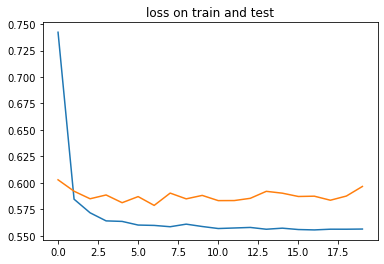

Last loss on train: 0.5563524067401886
Last loss on test: 0.5965940560165205


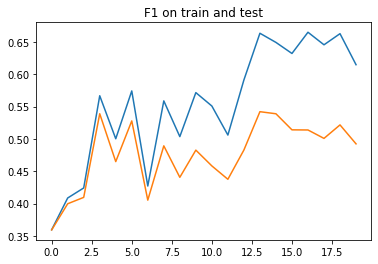

Last F1 on train: 0.6149154319963624
Last F1 on test: 0.4923691541740769


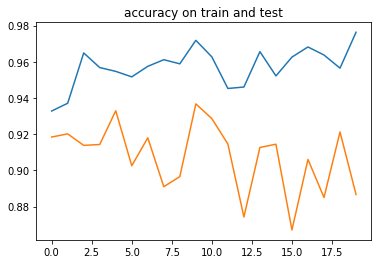

Last accuracy on train: 0.9762783017569938
Last accuracy on test: 0.8866580493356052


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.9028959933568611


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

na-B gut-I ,-O äh-O ,-O wir-O sehen-O uns-O dann-O nachher-O .-O
na-B gut-I .-O
ja-O ,-O ja-O ,-O keine-B frage-I .-O
mir-B auch-I recht-I .-O
--O das-B stimmt-I .-O
--O im-B ernst-I .-O
--O keine-B ahnung-I .-O
in-B ordnung-I .-O
--O ich-B bin-I dabei-I .-O
ach-B ja-I ?-O
--O aber-B natürlich-I .-O
ja-O ,-O ich-B verstehe-I .-O
--O ich-B bin-I dabei-I .-O
keine-B ahnung-I .-O
ja-O ,-O aber-O ich-O hab-O das-O gefühl-O ,-O dass-O ihre-O freundin-O ein-O ...-O ein-O zombie-O ist-O ,-O schon-B möglich-I .-O
was-B soll-I das-I ?-O
--O keine-B ahnung-I .-O
ich-B verstehe-I .-O
--O keine-B ahnung-I .-O
spinnst-B du-I ?-O !-O
ist-B schon-I gut-I .-O
ja-O ,-O gute-B idee-I .-O
ich-O brauch-O keine-O ,-O stimmt-B 's-I ?-O
--O ach-B ja-I ?-O
ich-B glaub-I nicht-I .-O
na-B und-I ?-O
--O gute-B idee-I .-O
--O ganz-B und-I gar-I nicht-I .-O
--O ich-B weiß-I .-O
ganz-B und-I gar-I nicht-I .-O
schon-B gut-I .-O
keine-B ahnung-I .-O
es-B geht-I nicht-I !-O
nein-O ,-O das-B geht-I nicht-I .-O
ganz-B s